In [44]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D
from pathlib import Path
import pandas as pd
import seaborn as sns
import gc

import sys
sys.path.append('../src')
from bossa.imf import Star
from bossa.zams import CompanionFrequencyDistribution, MassRatioDistribution, EccentricityDistribution
from bossa.constants import DATA_PATH

In [45]:
plt.style.use('./plotstyle.mplstyle')
FIGURE_FOLDER = Path('./figures')

In [46]:
def normalized(array):
    norm = np.linalg.norm(array)
    return array/norm

In [47]:
fulldf_cols = ['Mass_ZAMS1_Found', 'Mass_ZAMS2_Found', 'MassRatioFound_ZAMS', 'LogOrbitalPeriod_ZAMS', 'Eccentricity_ZAMS', 'CompanionNumber', 'SystemMass']

## Paths setup

In [48]:
IGIMF_ZAMS_DIR_PATH = Path(DATA_PATH, 'zams_grids')
ONLYBIN_SAMPLE_DIR_PATH = Path(IGIMF_ZAMS_DIR_PATH, '12x10_2222_zams_grid')
ALLMULT_SAMPLE_DIR_PATH = Path(IGIMF_ZAMS_DIR_PATH, '12x10_2212_zams_grid')
ONLYBIN_CANON_SAMPLE_DIR_PATH = Path(IGIMF_ZAMS_DIR_PATH, '12x10_1122_zams_grid')
ALLMULT_CANON_SAMPLE_DIR_PATH = Path(IGIMF_ZAMS_DIR_PATH, '12x10_1112_zams_grid')

In [49]:
onlybin_sample_paths = list(ONLYBIN_SAMPLE_DIR_PATH.glob('*.parquet'))
allmult_sample_paths = list(ALLMULT_SAMPLE_DIR_PATH.glob('*.parquet'))
onlybin_canon_sample_paths = list(ONLYBIN_CANON_SAMPLE_DIR_PATH.glob('*.parquet'))
allmult_canon_sample_paths = list(ALLMULT_CANON_SAMPLE_DIR_PATH.glob('*.parquet'))
#sample_paths = list(CO_DIR_PATH.glob('*.parquet'))

In [50]:
onlybin_sample_paths_dict = {}
for path in onlybin_sample_paths:
    z = float(path.name.split('_')[0].split('=')[1])
    if z not in onlybin_sample_paths_dict:
        onlybin_sample_paths_dict[z] = []
    onlybin_sample_paths_dict[z].append(path)

In [51]:
allmult_sample_paths_dict = {}
for path in allmult_sample_paths:
    z = float(path.name.split('_')[0].split('=')[1])
    if z not in allmult_sample_paths_dict:
        allmult_sample_paths_dict[z] = []
    allmult_sample_paths_dict[z].append(path)

In [52]:
onlybin_canon_sample_paths_dict = {}
for path in onlybin_canon_sample_paths:
    z = float(path.name.split('_')[0].split('=')[1])
    if z not in onlybin_canon_sample_paths_dict:
        onlybin_canon_sample_paths_dict[z] = []
    onlybin_canon_sample_paths_dict[z].append(path)

In [53]:
allmult_canon_sample_paths_dict = {}
for path in allmult_canon_sample_paths:
    z = float(path.name.split('_')[0].split('=')[1])
    if z not in allmult_canon_sample_paths_dict:
        allmult_canon_sample_paths_dict[z] = []
    allmult_canon_sample_paths_dict[z].append(path)

In [54]:
for z in onlybin_sample_paths_dict:
    unsorted_paths = onlybin_sample_paths_dict[z]
    unsorted_sfrs = [float(path.name.split('_')[2].split('=')[1]) for path in unsorted_paths]
    sorted_indexes = np.argsort(unsorted_sfrs)
    sorted_paths = np.array(unsorted_paths)[sorted_indexes]
    onlybin_sample_paths_dict[z] = sorted_paths

In [55]:
for z in allmult_sample_paths_dict:
    unsorted_paths = allmult_sample_paths_dict[z]
    unsorted_sfrs = [float(path.name.split('_')[2].split('=')[1]) for path in unsorted_paths]
    sorted_indexes = np.argsort(unsorted_sfrs)
    sorted_paths = np.array(unsorted_paths)[sorted_indexes]
    allmult_sample_paths_dict[z] = sorted_paths

In [56]:
for z in onlybin_canon_sample_paths_dict:
    unsorted_paths = onlybin_canon_sample_paths_dict[z]
    unsorted_sfrs = [float(path.name.split('_')[2].split('=')[1]) for path in unsorted_paths]
    sorted_indexes = np.argsort(unsorted_sfrs)
    sorted_paths = np.array(unsorted_paths)[sorted_indexes]
    onlybin_canon_sample_paths_dict[z] = sorted_paths

In [57]:
for z in allmult_canon_sample_paths_dict:
    unsorted_paths = allmult_canon_sample_paths_dict[z]
    unsorted_sfrs = [float(path.name.split('_')[2].split('=')[1]) for path in unsorted_paths]
    sorted_indexes = np.argsort(unsorted_sfrs)
    sorted_paths = np.array(unsorted_paths)[sorted_indexes]
    allmult_canon_sample_paths_dict[z] = sorted_paths

## Loading the sample

In [58]:
rename_dict = {'Mass_ZAMS1_Found': 'm1',
               'Mass_ZAMS2_Found': 'm2',
               'MassRatioFound_ZAMS': 'q',
               'LogOrbitalPeriod_ZAMS': 'logp',
               'Eccentricity_ZAMS': 'e',
               'CompanionNumber': 'ncp',
               'SystemMass': 'msys'}

In [59]:
full_df = pd.DataFrame(columns=fulldf_cols, dtype='float16')
sample_paths = onlybin_sample_paths
sample_paths_dict = onlybin_sample_paths_dict

row_i = 1
for z in sample_paths_dict:
    paths = sample_paths_dict[z]
    for path in paths:
        feh = float(path.name.split('_')[1].split('=')[1])
        try:
            df = pd.read_parquet(path, engine='pyarrow', columns=fulldf_cols)
        except:
            continue
        else:
            nrow = len(df)
            df['Redshift'] = np.array([z]*len(df))
            df['[Fe/H]'] = np.array([feh]*len(df))
            full_df = pd.concat((full_df,df))
            del df
            gc.collect()
            print(f'Added {nrow} rows from {path.name}. Total: {len(full_df):.2e} rows. ({row_i}/{len(sample_paths)})')
        finally:
            row_i += 1
            
onlybin_df = full_df

Added 1552072 rows from z=3.052_feh=-2.760_logsfr=-0.980_1e4ZOH=65702_1e2Mgal=679_1e2logn=-146_logpool=6.60_igimf_zams_sample.parquet. Total: 1.55e+06 rows. (1/120)
Added 1497981 rows from z=3.052_feh=-1.461_logsfr=0.418_1e4ZOH=78685_1e2Mgal=900_1e2logn=-246_logpool=6.60_igimf_zams_sample.parquet. Total: 3.05e+06 rows. (2/120)
Added 1470876 rows from z=3.052_feh=-1.209_logsfr=0.724_1e4ZOH=81210_1e2Mgal=948_1e2logn=-278_logpool=6.60_igimf_zams_sample.parquet. Total: 4.52e+06 rows. (3/120)
Added 1449236 rows from z=3.052_feh=-1.044_logsfr=0.943_1e4ZOH=82860_1e2Mgal=983_1e2logn=-302_logpool=6.60_igimf_zams_sample.parquet. Total: 5.97e+06 rows. (4/120)
Added 1429328 rows from z=3.052_feh=-0.851_logsfr=1.116_1e4ZOH=84046_1e2Mgal=1011_1e2logn=-323_logpool=6.60_igimf_zams_sample.parquet. Total: 7.40e+06 rows. (5/120)
Added 1408745 rows from z=3.052_feh=-0.671_logsfr=1.268_1e4ZOH=84945_1e2Mgal=1036_1e2logn=-342_logpool=6.60_igimf_zams_sample.parquet. Total: 8.81e+06 rows. (6/120)
Added 1386802

KeyboardInterrupt: 

In [20]:
onlybin_df.rename(columns=rename_dict, inplace=True)

In [21]:
df_cols = onlybin_df.columns

In [22]:
for col in df_cols:
    onlybin_df[col] = onlybin_df[col].astype('float16')

In [23]:
full_df = pd.DataFrame(columns=fulldf_cols, dtype='float16')
sample_paths = allmult_sample_paths
sample_paths_dict = allmult_sample_paths_dict

row_i = 1
for z in sample_paths_dict:
    paths = sample_paths_dict[z]
    for path in paths:
        feh = float(path.name.split('_')[1].split('=')[1])
        try:
            df = pd.read_parquet(path, engine='pyarrow', columns=fulldf_cols)
        except:
            continue
        else:
            nrow = len(df)
            df['Redshift'] = np.array([z]*len(df))
            df['[Fe/H]'] = np.array([feh]*len(df))
            full_df = pd.concat((full_df,df))
            del df
            gc.collect()
            print(f'Added {nrow} rows from {path.name}. Total: {len(full_df):.2e} rows. ({row_i}/{len(sample_paths)})')
        finally:
            row_i += 1
            
allmult_df = full_df

Added 1373372 rows from z=3.052_feh=-2.760_logsfr=-0.980_1e4ZOH=65702_1e2Mgal=679_1e2logn=-146_logpool=6.60_igimf_zams_sample.parquet. Total: 1.37e+06 rows. (1/120)
Added 1289369 rows from z=3.052_feh=-1.461_logsfr=0.418_1e4ZOH=78685_1e2Mgal=900_1e2logn=-246_logpool=6.60_igimf_zams_sample.parquet. Total: 2.66e+06 rows. (2/120)
Added 1246730 rows from z=3.052_feh=-1.209_logsfr=0.724_1e4ZOH=81210_1e2Mgal=948_1e2logn=-278_logpool=6.60_igimf_zams_sample.parquet. Total: 3.91e+06 rows. (3/120)
Added 1214779 rows from z=3.052_feh=-1.044_logsfr=0.943_1e4ZOH=82860_1e2Mgal=983_1e2logn=-302_logpool=6.60_igimf_zams_sample.parquet. Total: 5.12e+06 rows. (4/120)
Added 1185578 rows from z=3.052_feh=-0.851_logsfr=1.116_1e4ZOH=84046_1e2Mgal=1011_1e2logn=-323_logpool=6.60_igimf_zams_sample.parquet. Total: 6.31e+06 rows. (5/120)
Added 1154282 rows from z=3.052_feh=-0.671_logsfr=1.268_1e4ZOH=84945_1e2Mgal=1036_1e2logn=-342_logpool=6.60_igimf_zams_sample.parquet. Total: 7.46e+06 rows. (6/120)
Added 1117699

In [24]:
allmult_df.rename(columns=rename_dict, inplace=True)

In [25]:
for col in df_cols:
    allmult_df[col] = allmult_df[col].astype('float16')

In [26]:
full_df = pd.DataFrame(columns=fulldf_cols, dtype='float16')
sample_paths = onlybin_canon_sample_paths
sample_paths_dict = onlybin_canon_sample_paths_dict

row_i = 1
for z in sample_paths_dict:
    paths = sample_paths_dict[z]
    for path in paths:
        feh = float(path.name.split('_')[1].split('=')[1])
        try:
            df = pd.read_parquet(path, engine='pyarrow', columns=fulldf_cols)
        except:
            continue
        else:
            nrow = len(df)
            df['Redshift'] = np.array([z]*len(df))
            df['[Fe/H]'] = np.array([feh]*len(df))
            full_df = pd.concat((full_df,df))
            del df
            gc.collect()
            print(f'Added {nrow} rows from {path.name}. Total: {len(full_df):.2e} rows. ({row_i}/{len(sample_paths)})')
        finally:
            row_i += 1
            
onlybin_canon_df = full_df

Added 1605386 rows from z=3.052_feh=-2.760_logsfr=-0.980_1e4ZOH=65702_1e2Mgal=679_1e2logn=-146_logpool=6.60_igimf_zams_sample.parquet. Total: 1.61e+06 rows. (1/120)
Added 1605352 rows from z=3.052_feh=-1.461_logsfr=0.418_1e4ZOH=78685_1e2Mgal=900_1e2logn=-246_logpool=6.60_igimf_zams_sample.parquet. Total: 3.21e+06 rows. (2/120)
Added 1606339 rows from z=3.052_feh=-1.209_logsfr=0.724_1e4ZOH=81210_1e2Mgal=948_1e2logn=-278_logpool=6.60_igimf_zams_sample.parquet. Total: 4.82e+06 rows. (3/120)
Added 1606339 rows from z=3.052_feh=-1.044_logsfr=0.943_1e4ZOH=82860_1e2Mgal=983_1e2logn=-302_logpool=6.60_igimf_zams_sample.parquet. Total: 6.42e+06 rows. (4/120)
Added 1606339 rows from z=3.052_feh=-0.851_logsfr=1.116_1e4ZOH=84046_1e2Mgal=1011_1e2logn=-323_logpool=6.60_igimf_zams_sample.parquet. Total: 8.03e+06 rows. (5/120)
Added 1606339 rows from z=3.052_feh=-0.671_logsfr=1.268_1e4ZOH=84945_1e2Mgal=1036_1e2logn=-342_logpool=6.60_igimf_zams_sample.parquet. Total: 9.64e+06 rows. (6/120)
Added 1606339

In [27]:
onlybin_canon_df.rename(columns=rename_dict, inplace=True)

In [28]:
for col in df_cols:
    onlybin_canon_df[col] = onlybin_canon_df[col].astype('float16')

In [29]:
full_df = pd.DataFrame(columns=fulldf_cols, dtype='float16')
sample_paths = allmult_canon_sample_paths
sample_paths_dict = allmult_canon_sample_paths_dict

row_i = 1
for z in sample_paths_dict:
    paths = sample_paths_dict[z]
    for path in paths:
        feh = float(path.name.split('_')[1].split('=')[1])
        try:
            df = pd.read_parquet(path, engine='pyarrow', columns=fulldf_cols)
        except:
            continue
        else:
            nrow = len(df)
            df['Redshift'] = np.array([z]*len(df))
            df['[Fe/H]'] = np.array([feh]*len(df))
            full_df = pd.concat((full_df,df))
            del df
            gc.collect()
            print(f'Added {nrow} rows from {path.name}. Total: {len(full_df):.2e} rows. ({row_i}/{len(sample_paths)})')
        finally:
            row_i += 1
            
allmult_canon_df = full_df

Added 1478171 rows from z=3.052_feh=-2.760_logsfr=-0.980_1e4ZOH=65702_1e2Mgal=679_1e2logn=-146_logpool=6.60_igimf_zams_sample.parquet. Total: 1.48e+06 rows. (1/120)
Added 1477679 rows from z=3.052_feh=-1.461_logsfr=0.418_1e4ZOH=78685_1e2Mgal=900_1e2logn=-246_logpool=6.60_igimf_zams_sample.parquet. Total: 2.96e+06 rows. (2/120)
Added 1478066 rows from z=3.052_feh=-1.209_logsfr=0.724_1e4ZOH=81210_1e2Mgal=948_1e2logn=-278_logpool=6.60_igimf_zams_sample.parquet. Total: 4.43e+06 rows. (3/120)
Added 1478066 rows from z=3.052_feh=-1.044_logsfr=0.943_1e4ZOH=82860_1e2Mgal=983_1e2logn=-302_logpool=6.60_igimf_zams_sample.parquet. Total: 5.91e+06 rows. (4/120)
Added 1478066 rows from z=3.052_feh=-0.851_logsfr=1.116_1e4ZOH=84046_1e2Mgal=1011_1e2logn=-323_logpool=6.60_igimf_zams_sample.parquet. Total: 7.39e+06 rows. (5/120)
Added 1478066 rows from z=3.052_feh=-0.671_logsfr=1.268_1e4ZOH=84945_1e2Mgal=1036_1e2logn=-342_logpool=6.60_igimf_zams_sample.parquet. Total: 8.87e+06 rows. (6/120)
Added 1478066

In [30]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 177357905 entries, 0 to 1477819
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Mass_ZAMS1_Found       float32
 1   Mass_ZAMS2_Found       float32
 2   MassRatioFound_ZAMS    float32
 3   LogOrbitalPeriod_ZAMS  float32
 4   Eccentricity_ZAMS      float32
 5   CompanionNumber        float32
 6   SystemMass             float32
 7   Redshift               float64
 8   [Fe/H]                 float64
dtypes: float32(7), float64(2)
memory usage: 8.6 GB


In [31]:
allmult_canon_df.rename(columns=rename_dict, inplace=True)

In [32]:
allmult_canon_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 177357905 entries, 0 to 1477819
Data columns (total 9 columns):
 #   Column    Dtype  
---  ------    -----  
 0   m1        float32
 1   m2        float32
 2   q         float32
 3   logp      float32
 4   e         float32
 5   ncp       float32
 6   msys      float32
 7   Redshift  float64
 8   [Fe/H]    float64
dtypes: float32(7), float64(2)
memory usage: 8.6 GB


In [33]:
df_cols

Index(['m1', 'm2', 'q', 'logp', 'e', 'ncp', 'msys', 'Redshift', '[Fe/H]'], dtype='object')

In [34]:
del full_df
gc.collect()

0

In [35]:
onlybin_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 174039311 entries, 0 to 1362429
Data columns (total 9 columns):
 #   Column    Dtype  
---  ------    -----  
 0   m1        float16
 1   m2        float16
 2   q         float16
 3   logp      float16
 4   e         float16
 5   ncp       float16
 6   msys      float16
 7   Redshift  float16
 8   [Fe/H]    float16
dtypes: float16(9)
memory usage: 4.2 GB


## Does our sampling preserve the $q$ distribution?

In [36]:
plot_qs = np.linspace(0.1,1,50)
plot_m1s = np.array([0.8, 1.5, 10])
#plot_logps = np.concatenate(([0.21, 0.4, 0.6, 0.8, 1.0], np.arange(2, 9, 2)))
plot_logps = np.array([1, 4, 8])

plot_p_qs_array = np.empty((plot_m1s.shape[0], 
                            plot_logps.shape[0], 
                            plot_qs.shape[0]), np.float64)

q_distr = MassRatioDistribution()
for m1_i, m1 in enumerate(plot_m1s):
    for logp_i, logp in enumerate(plot_logps):
        q_distr.set_parameters(m1, logp)
        for q_i, q in enumerate(plot_qs):
            plot_p_qs_array[m1_i, logp_i, q_i] = q_distr.prob(q)

In [37]:
q_width = 0.05
q_bins = np.arange(0, 1 + 2*q_width, q_width)
q_centers = np.array([(q0+q1)/2 for q0,q1 in zip(q_bins[:-1], q_bins[1:])])

In [38]:
df = onlybin_df
q_hs = []
closest_m1s = []
closest_logps = []

unique_m1s = np.sort(np.unique(df.m1.to_numpy()))
for m1 in plot_m1s:
    closest_m1_i = np.argmin(np.abs(unique_m1s- m1))
    closest_m1 = unique_m1s[closest_m1_i]
    closest_m1s.append(closest_m1)
    subdf = df[df.m1 == closest_m1]
    subdf = subdf[subdf.ncp >= 1]
    q_hs_m1 = []
    closest_logps_ = []
    for logp in plot_logps:
        unique_logps = np.sort(np.unique(subdf.logp.to_numpy()))
        closest_logp_i = np.argmin(np.abs(unique_logps - logp))
        closest_logp = unique_logps[closest_logp_i]
        closest_logps_.append(closest_logp)
        subsubdf = subdf[subdf.logp == closest_logp]
        qs = np.sort(subsubdf.q.to_numpy())
        q_hs_, _ = np.histogram(qs, bins=q_bins, density=True)
        q_hs_m1.append(q_hs_)
    closest_logps.append(closest_logps_)
    q_hs.append(q_hs_m1)
    
onlybin_q_hs = q_hs

Figure 11

<>:22: SyntaxWarning: invalid escape sequence '\,'
<>:22: SyntaxWarning: invalid escape sequence '\o'
<>:23: SyntaxWarning: invalid escape sequence '\,'
<>:23: SyntaxWarning: invalid escape sequence '\o'
<>:24: SyntaxWarning: invalid escape sequence '\,'
<>:24: SyntaxWarning: invalid escape sequence '\o'
<>:22: SyntaxWarning: invalid escape sequence '\,'
<>:22: SyntaxWarning: invalid escape sequence '\o'
<>:23: SyntaxWarning: invalid escape sequence '\,'
<>:23: SyntaxWarning: invalid escape sequence '\o'
<>:24: SyntaxWarning: invalid escape sequence '\,'
<>:24: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_697613/3473001705.py:22: SyntaxWarning: invalid escape sequence '\,'
  fig.text(1.02, 0.5, f'$m_1={np.round(plot_m1s[0], decimals=1):.1f}\,\mathrm{{M}}_\odot$', ha='left', va='center', rotation=-90, fontsize=36, transform=axes[0].transAxes)
/tmp/ipykernel_697613/3473001705.py:22: SyntaxWarning: invalid escape sequence '\o'
  fig.text(1.02, 0.5, f'$m_1={np.round(plot_m1s[

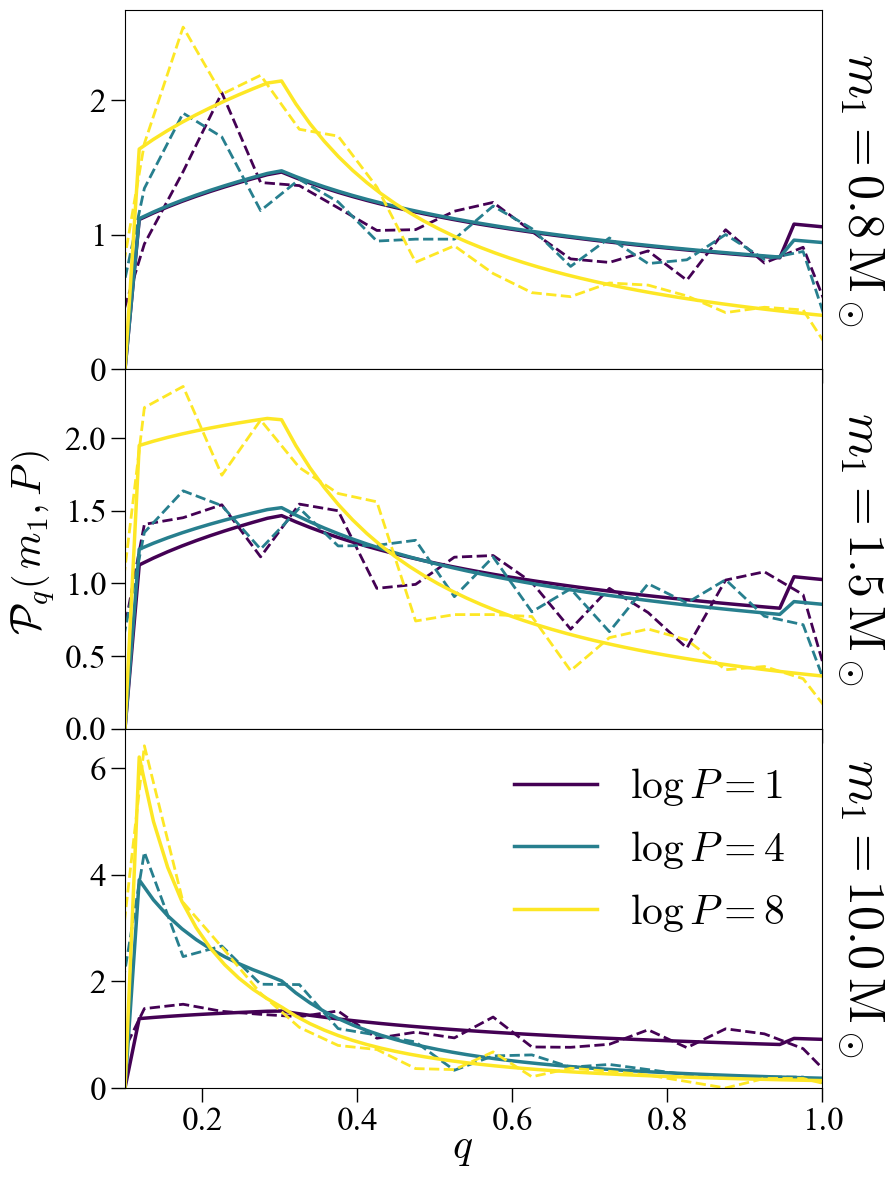

In [60]:
fig, axes = plt.subplots(3, 1, figsize=(9,14), sharex=True, sharey=False)
fig.subplots_adjust(hspace=0, wspace=0)
rect = fig.patch
rect.set_facecolor('white')
logp_cnorm = plot_logps.max() - plot_logps.min()

for ax, m1, logp_arr, plot_m1_array, plot_sample_m1_arr in zip(axes, closest_m1s, closest_logps, plot_p_qs_array, onlybin_q_hs):
    for logp, plot_logp_array, plot_sample_logp_arr in zip(logp_arr, plot_m1_array, plot_sample_m1_arr):
        c = cm.viridis((logp-plot_logps.min())/logp_cnorm)
        ax.plot(q_centers, plot_sample_logp_arr, c=c, lw=2, ls='--')
        ax.plot(plot_qs, plot_logp_array, c=c, label = r'$\log P= %.0f$' % logp, lw=2.5)
        #ax.text(0.5, 0.95, r'$m_1 = %.2f\,\mathrm{M}_\odot$' % m1, ha='center', va='top', transform=ax.transAxes)
        
for ax in axes:
    ax.set_xlim(0.1, 1)
    ax.set_ylim(0)
    
axes[2].legend(*axes[1].get_legend_handles_labels(), loc='upper right', bbox_to_anchor=(1, 1), frameon=False)
fig.text(0.5, 0.08, '$q$', va='top', ha='center')
fig.text(0.05, 0.5, r'$\mathcal{P}_q\left(\,m_1,P\,\right)$', rotation=90, va='center', ha='right')

fig.text(1.02, 0.5, f'$m_1={np.round(plot_m1s[0], decimals=1):.1f}\,\mathrm{{M}}_\odot$', ha='left', va='center', rotation=-90, fontsize=36, transform=axes[0].transAxes)
fig.text(1.02, 0.5, f'$m_1={np.round(plot_m1s[1], decimals=1):.1f}\,\mathrm{{M}}_\odot$', ha='left', va='center', rotation=-90, fontsize=36, transform=axes[1].transAxes)
fig.text(1.02, 0.5, f'$m_1={np.round(plot_m1s[2], decimals=1):.1f}\,\mathrm{{M}}_\odot$', ha='left', va='center', rotation=-90, fontsize=36, transform=axes[2].transAxes)

fig.savefig(FIGURE_FOLDER/'q_sampling_comparison_1e6.pdf', bbox_inches='tight')
fig.savefig(FIGURE_FOLDER/'q_sampling_comparison_1e6.png', bbox_inches='tight')

## Inner binaries X pure binaries for $q,e$ sampling

### $q$ samples

In [61]:
plot_m1s = np.array([0.8, 1.5, 10])
plot_logps = np.array([1, 4, 8])

In [62]:
q_width = 0.05
q_bins = np.arange(0, 1 + 2*q_width, q_width)
q_centers = np.array([(q0+q1)/2 for q0,q1 in zip(q_bins[:-1], q_bins[1:])])

In [63]:
canon_q_width = 0.1
canon_q_bins = np.arange(0, 1 + 2*canon_q_width, canon_q_width)
canon_q_centers = np.array([(q0+q1)/2 for q0,q1 in zip(canon_q_bins[:-1], canon_q_bins[1:])])

In [64]:
df = allmult_df
q_hs = []

unique_m1s = np.sort(np.unique(df.m1.to_numpy()))
for m1 in plot_m1s:
    closest_m1_i = np.argmin(np.abs(unique_m1s- m1))
    closest_m1 = unique_m1s[closest_m1_i]
    closest_m1s.append(closest_m1)
    subdf = df[df.m1 == closest_m1]
    subdf = subdf[subdf.ncp >= 1]
    q_hs_m1 = []
    for logp in plot_logps:
        unique_logps = np.sort(np.unique(subdf.logp.to_numpy()))
        closest_logp_i = np.argmin(np.abs(unique_logps - logp))
        closest_logp = unique_logps[closest_logp_i]
        closest_logps_.append(closest_logp)
        subsubdf = subdf[subdf.logp == closest_logp]
        qs = np.sort(subsubdf.q.to_numpy())
        q_hs_, _ = np.histogram(qs, bins=q_bins, density=True)
        q_hs_m1.append(q_hs_)
    q_hs.append(q_hs_m1)
    
allmult_q_hs = q_hs

In [65]:
df = onlybin_canon_df
q_hs = []

unique_m1s = np.sort(np.unique(df.m1.to_numpy()))
for m1 in plot_m1s:
    closest_m1_i = np.argmin(np.abs(unique_m1s- m1))
    closest_m1 = unique_m1s[closest_m1_i]
    closest_m1s.append(closest_m1)
    subdf = df[df.m1 == closest_m1]
    subdf = subdf[subdf.ncp >= 1]
    q_hs_m1 = []
    for logp in plot_logps:
        unique_logps = np.sort(np.unique(subdf.logp.to_numpy()))
        closest_logp_i = np.argmin(np.abs(unique_logps - logp))
        closest_logp = unique_logps[closest_logp_i]
        closest_logps_.append(closest_logp)
        subsubdf = subdf[subdf.logp == closest_logp]
        qs = np.sort(subsubdf.q.to_numpy())
        q_hs_, _ = np.histogram(qs, bins=canon_q_bins, density=True)
        q_hs_m1.append(q_hs_)
    q_hs.append(q_hs_m1)
    
onlybin_canon_q_hs = q_hs

In [66]:
df = allmult_canon_df
q_hs = []

unique_m1s = np.sort(np.unique(df.m1.to_numpy()))
for m1 in plot_m1s:
    closest_m1_i = np.argmin(np.abs(unique_m1s- m1))
    closest_m1 = unique_m1s[closest_m1_i]
    closest_m1s.append(closest_m1)
    subdf = df[df.m1 == closest_m1]
    subdf = subdf[subdf.ncp >= 1]
    q_hs_m1 = []
    for logp in plot_logps:
        unique_logps = np.sort(np.unique(subdf.logp.to_numpy()))
        closest_logp_i = np.argmin(np.abs(unique_logps - logp))
        closest_logp = unique_logps[closest_logp_i]
        closest_logps_.append(closest_logp)
        subsubdf = subdf[subdf.logp == closest_logp]
        qs = np.sort(subsubdf.q.to_numpy())
        q_hs_, _ = np.histogram(qs, bins=canon_q_bins, density=True)
        q_hs_m1.append(q_hs_)
    q_hs.append(q_hs_m1)
    
allmult_canon_q_hs = q_hs

In [67]:
df = allmult_df
q_hs = []

unique_m1s = np.sort(np.unique(df.m1.to_numpy()))
for m1 in plot_m1s:
    closest_m1_i = np.argmin(np.abs(unique_m1s- m1))
    closest_m1 = unique_m1s[closest_m1_i]
    closest_m1s.append(closest_m1)
    subdf = df[df.m1 == closest_m1]
    subdf = subdf[subdf.ncp == 1]
    q_hs_m1 = []
    for logp in plot_logps:
        unique_logps = np.sort(np.unique(subdf.logp.to_numpy()))
        closest_logp_i = np.argmin(np.abs(unique_logps - logp))
        closest_logp = unique_logps[closest_logp_i]
        closest_logps_.append(closest_logp)
        subsubdf = subdf[subdf.logp == closest_logp]
        qs = np.sort(subsubdf.q.to_numpy())
        q_hs_, _ = np.histogram(qs, bins=q_bins, density=True)
        q_hs_m1.append(q_hs_)
    q_hs.append(q_hs_m1)
    
allmult_pure_q_hs = q_hs

In [68]:
df = allmult_canon_df
q_hs = []

unique_m1s = np.sort(np.unique(df.m1.to_numpy()))
for m1 in plot_m1s:
    closest_m1_i = np.argmin(np.abs(unique_m1s- m1))
    closest_m1 = unique_m1s[closest_m1_i]
    closest_m1s.append(closest_m1)
    subdf = df[df.m1 == closest_m1]
    subdf = subdf[subdf.ncp == 1]
    q_hs_m1 = []
    for logp in plot_logps:
        unique_logps = np.sort(np.unique(subdf.logp.to_numpy()))
        closest_logp_i = np.argmin(np.abs(unique_logps - logp))
        closest_logp = unique_logps[closest_logp_i]
        closest_logps_.append(closest_logp)
        subsubdf = subdf[subdf.logp == closest_logp]
        qs = np.sort(subsubdf.q.to_numpy())
        q_hs_, _ = np.histogram(qs, bins=canon_q_bins, density=True)
        q_hs_m1.append(q_hs_)
    q_hs.append(q_hs_m1)
    
allmult_canon_pure_q_hs = q_hs

<>:62: SyntaxWarning: invalid escape sequence '\,'
<>:62: SyntaxWarning: invalid escape sequence '\o'
<>:63: SyntaxWarning: invalid escape sequence '\,'
<>:63: SyntaxWarning: invalid escape sequence '\o'
<>:64: SyntaxWarning: invalid escape sequence '\,'
<>:64: SyntaxWarning: invalid escape sequence '\o'
<>:70: SyntaxWarning: invalid escape sequence '\l'
<>:62: SyntaxWarning: invalid escape sequence '\,'
<>:62: SyntaxWarning: invalid escape sequence '\o'
<>:63: SyntaxWarning: invalid escape sequence '\,'
<>:63: SyntaxWarning: invalid escape sequence '\o'
<>:64: SyntaxWarning: invalid escape sequence '\,'
<>:64: SyntaxWarning: invalid escape sequence '\o'
<>:70: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_697613/1770693386.py:62: SyntaxWarning: invalid escape sequence '\,'
  fig.text(1.05, 0.5, f'$m_1={plot_m1s[0]}\,\mathrm{{M}}_\odot$', ha='left', va='center', rotation=-90, fontsize=36, transform=axes[0,2].transAxes)
/tmp/ipykernel_697613/1770693386.py:62: SyntaxWarning:

(0.0, 2.8)

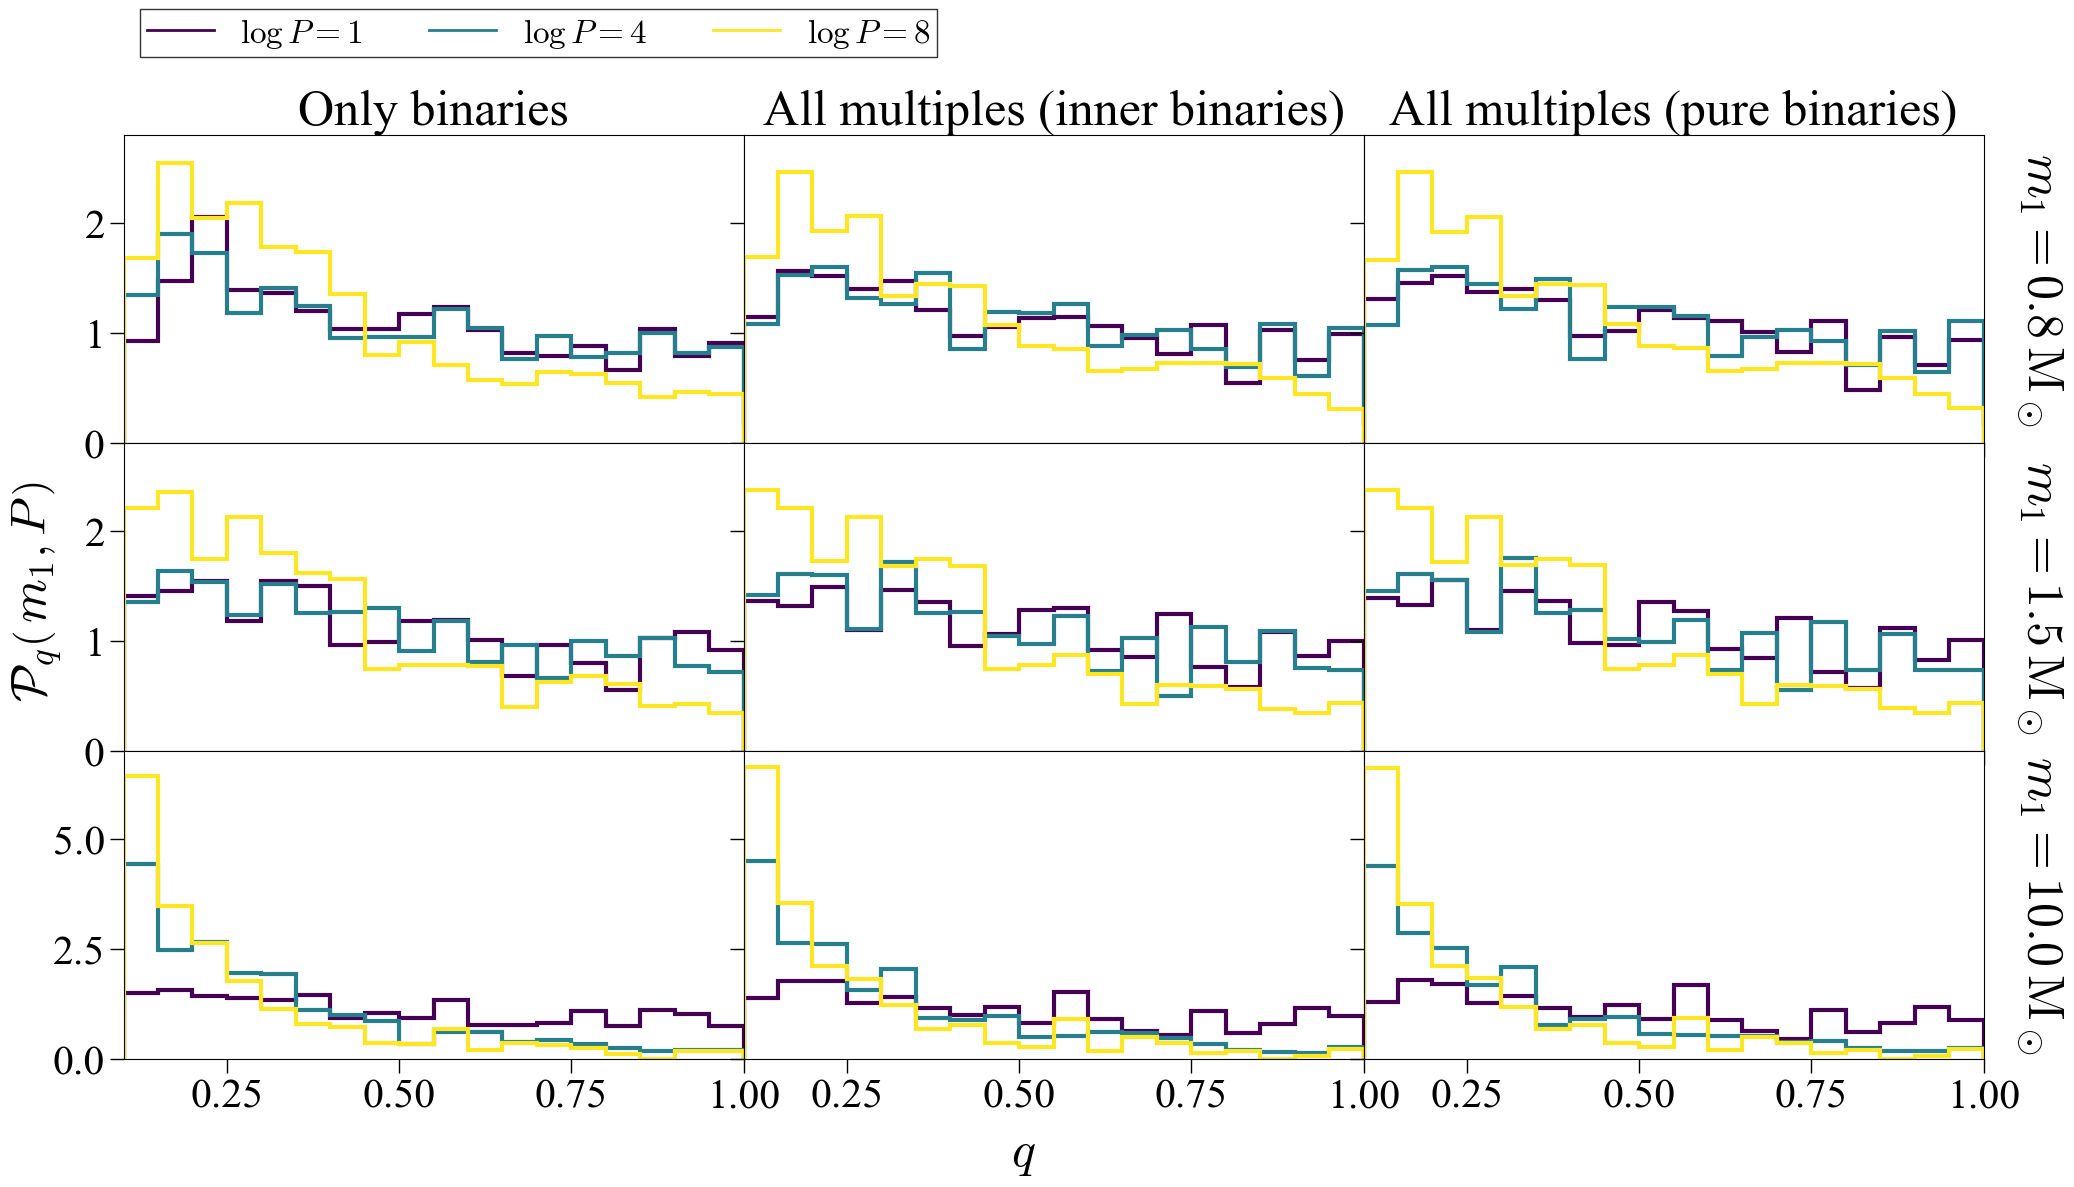

In [69]:
fig, axes = plt.subplots(3, 3, figsize=(24, 12), sharex=True, sharey='row')
fig.subplots_adjust(hspace=0, wspace=0)
rect = fig.patch
rect.set_facecolor('white')
logp_cnorm = plot_logps.max() - plot_logps.min()
hatches = ['-', '/', '\\']

### BINARIES ONLY ###
for i_m1, m1 in enumerate(plot_m1s):
    for logp, q_hs, hatch in zip(plot_logps, onlybin_q_hs[i_m1], hatches):
        c = cm.viridis((logp-plot_logps.min())/logp_cnorm)
        #axes[i_m1, 0].plot(q_centers, q_hs, c=c)
        #axes[i_m1, 0].stairs(q_hs, q_bins, facecolor=c, edgecolor='k', fill=True, alpha=0.5)
        axes[i_m1, 0].stairs(q_hs, q_bins, facecolor='none', edgecolor=c, alpha=1, fill=False, lw=3)
        #axes[i_m1, 0].stairs(q_hs, q_bins, facecolor='none', edgecolor='k', alpha=0.6, fill=True, zorder=3, hatch=hatch)
        
for i_m1, m1 in enumerate(plot_m1s):
    for logp, q_hs in zip(plot_logps, onlybin_canon_q_hs[i_m1]):
        c = cm.viridis((logp-plot_logps.min())/logp_cnorm)
        #axes[i_m1, 0].plot(canon_q_centers, q_hs, c=c, ls='--')
        
### ALL MULTIPLES INNER BINARIES ####
for i_m1, m1 in enumerate(plot_m1s):
    for logp, q_hs, hatch in zip(plot_logps, allmult_q_hs[i_m1], hatches):
        c = cm.viridis((logp-plot_logps.min())/logp_cnorm)
        #axes[i_m1, 0].plot(q_centers, q_hs, c=c)
        #axes[i_m1, 0].stairs(q_hs, q_bins, facecolor=c, edgecolor='k', fill=True, alpha=0.5)
        axes[i_m1, 1].stairs(q_hs, q_bins, facecolor='none', edgecolor=c, alpha=1, fill=False, lw=3)
        #axes[i_m1, 0].stairs(q_hs, q_bins, facecolor='none', edgecolor='k', alpha=0.6, fill=True, zorder=3, hatch=hatch)      
        
for i_m1, m1 in enumerate(plot_m1s):
    for logp, q_hs in zip(plot_logps, allmult_canon_q_hs[i_m1]):
        c = cm.viridis((logp-plot_logps.min())/logp_cnorm)
        #axes[i_m1, 1].plot(q_centers, q_hs, c=c, ls='--')
        
### ALL MULTIPLES PURE BINARIES ####
for i_m1, m1 in enumerate(plot_m1s):
    for logp, q_hs, hatch in zip(plot_logps, allmult_pure_q_hs[i_m1], hatches):
        c = cm.viridis((logp-plot_logps.min())/logp_cnorm)
        #axes[i_m1, 0].plot(q_centers, q_hs, c=c)
        #axes[i_m1, 0].stairs(q_hs, q_bins, facecolor=c, edgecolor='k', fill=True, alpha=0.5)
        axes[i_m1, 2].stairs(q_hs, q_bins, facecolor='none', edgecolor=c, alpha=1, fill=False, lw=3)
        #axes[i_m1, 0].stairs(q_hs, q_bins, facecolor='none', edgecolor='k', alpha=0.6, fill=True, zorder=3, hatch=hatch)
        
for i_m1, m1 in enumerate(plot_m1s):
    for logp, q_hs in zip(plot_logps, allmult_canon_pure_q_hs[i_m1]):
        c = cm.viridis((logp-plot_logps.min())/logp_cnorm)
        #axes[i_m1, 2].plot(q_centers, q_hs, c=c, ls='--')
        
### DETAILS ###
for ax in axes.flatten():
    ax.set_xlim(0.1, 1)
    ax.tick_params(labelsize=30)
    
fig.text(0.5, 0.05, '$q$', va='top', ha='center', transform=fig.transFigure, fontsize=36)
fig.text(0.1, 0.5, r'$\mathcal{P}_q\left(\,m_1,P\,\right)$', rotation=90, va='center', ha='right', transform=fig.transFigure, fontsize=36)

fig.text(0.5, 1, 'Only binaries', ha='center', va='bottom', fontsize=36, transform=axes[0,0].transAxes)
fig.text(0.5, 1, 'All multiples (inner binaries)', ha='center', va='bottom', fontsize=36, transform=axes[0,1].transAxes)
fig.text(0.5, 1, 'All multiples (pure binaries)', ha='center', va='bottom', fontsize=36, transform=axes[0,2].transAxes)

fig.text(1.05, 0.5, f'$m_1={plot_m1s[0]}\,\mathrm{{M}}_\odot$', ha='left', va='center', rotation=-90, fontsize=36, transform=axes[0,2].transAxes)
fig.text(1.05, 0.5, f'$m_1={plot_m1s[1]}\,\mathrm{{M}}_\odot$', ha='left', va='center', rotation=-90, fontsize=36, transform=axes[1,2].transAxes)
fig.text(1.05, 0.5, f'$m_1={plot_m1s[2]}\,\mathrm{{M}}_\odot$', ha='left', va='center', rotation=-90, fontsize=36, transform=axes[2,2].transAxes)

### LEGEND ###
handles = []
for logp in plot_logps:
    c = cm.viridis((logp-plot_logps.min())/logp_cnorm)
    handle = Line2D([0], [0], label=f'$\log P = {logp}$', color=c, linestyle='-')
    handles.append(handle)
axes[0,0].legend(handles=handles, frameon=True, loc='lower left', bbox_to_anchor=(0,1.2), ncol=3, edgecolor='black', fancybox=False, borderpad=0.2, fontsize=24)

axes[2,0].set_ylim(0,7)
#axes[1,0].set_yticks([5,10])
axes[1,0].set_ylim(0,2.8)
#axes[0,0].set_yticks([5,10])
axes[0,0].set_ylim(0,2.8)

#fig.savefig(FIGURE_FOLDER/'q_sample_muliplicity_hist_1e6.pdf', bbox_inches='tight')
#fig.savefig(FIGURE_FOLDER/'q_sample_muliplicity_hist_1e6.png', bbox_inches='tight')

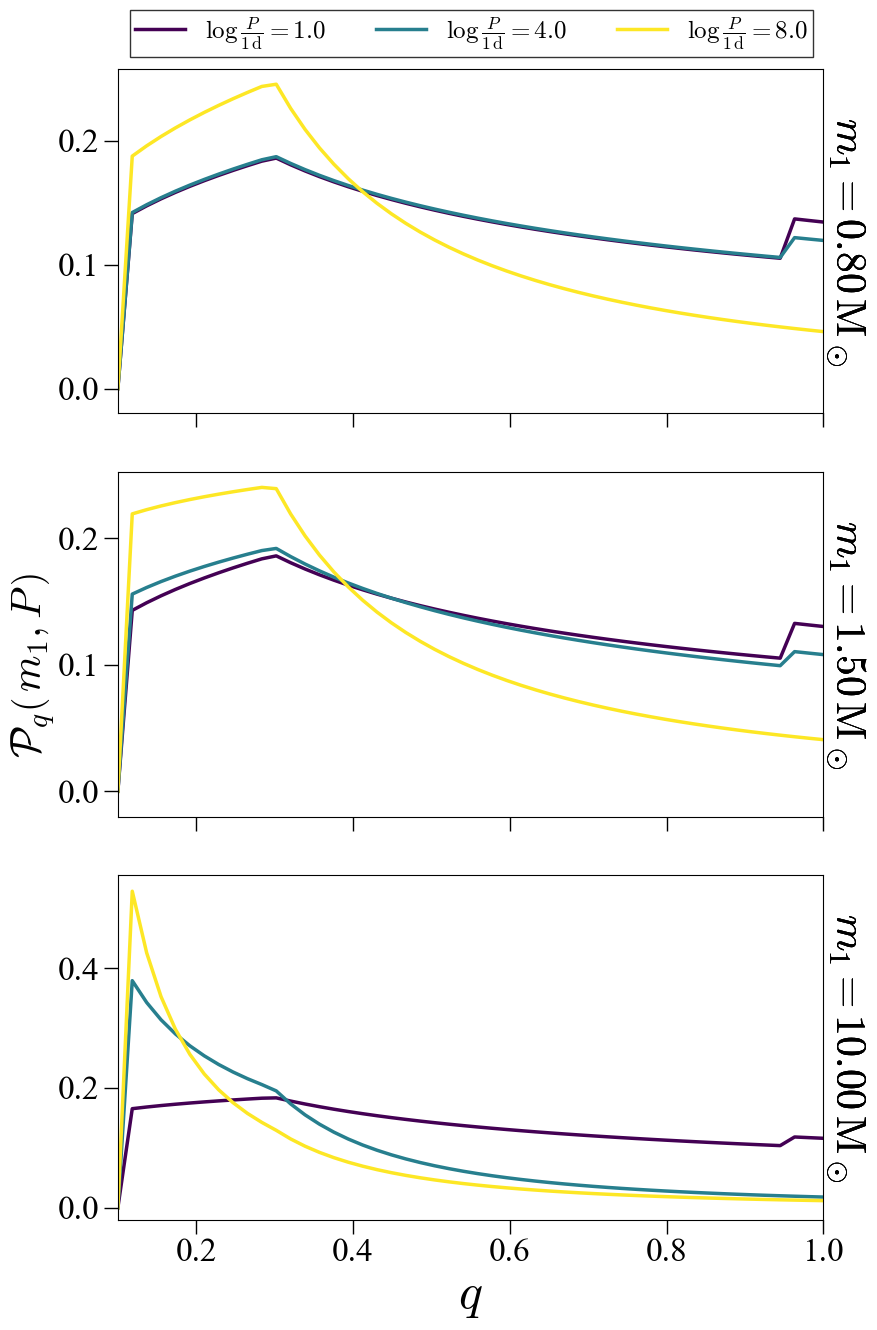

In [70]:
fig, axes = plt.subplots(3, 1, figsize=(9,14), sharex=True, sharey=False, tight_layout=False)
fig.subplots_adjust(hspace=0, wspace=0)
rect = fig.patch
rect.set_facecolor('white')
axes = axes.flatten()
logp_cnorm = plot_logps.max() - plot_logps.min()

for ax, m1, plot_m1_array in zip(axes, plot_m1s, plot_p_qs_array):
    for logp, plot_logp_array in zip(plot_logps, plot_m1_array):
        c = cm.viridis((logp-plot_logps.min())/logp_cnorm)
        ax.plot(plot_qs, normalized(plot_logp_array), c=c, label = r'$\log \frac{P}{1\,\mathrm{d}} = %.1f$' % logp, lw=2.5)
        ax.text(1, 0.5, r'$m_1 = %.2f\,\mathrm{M}_\odot$' % m1, rotation=-90, ha='left', va='center', transform=ax.transAxes)
        
for ax in axes:
    ax.set_xlim(0.1, 1)
    ax.set_ylim(-0.02)
    
#axes[2].legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
axes[-1].set_xlabel('$q$')
#fig.text(0.5, 0, '$q$', va='top', ha='center')
fig.text(0.05, 0.5, r'$\mathcal{P}_q\left(\,m_1,P\,\right)$', rotation=90, va='center', ha='right')

axes[0].legend(frameon=True, loc='lower left', bbox_to_anchor=(0,1), ncol=3, edgecolor='black', fancybox=False, borderpad=0.2, fontsize=18)

fig.savefig(FIGURE_FOLDER/'q_pM1_distr_tall.pdf', bbox_inches='tight')
fig.savefig(FIGURE_FOLDER/'q_pM1_distr_tall.png', bbox_inches='tight')

<>:62: SyntaxWarning: invalid escape sequence '\,'
<>:62: SyntaxWarning: invalid escape sequence '\o'
<>:63: SyntaxWarning: invalid escape sequence '\,'
<>:63: SyntaxWarning: invalid escape sequence '\o'
<>:64: SyntaxWarning: invalid escape sequence '\,'
<>:64: SyntaxWarning: invalid escape sequence '\o'
<>:70: SyntaxWarning: invalid escape sequence '\l'
<>:62: SyntaxWarning: invalid escape sequence '\,'
<>:62: SyntaxWarning: invalid escape sequence '\o'
<>:63: SyntaxWarning: invalid escape sequence '\,'
<>:63: SyntaxWarning: invalid escape sequence '\o'
<>:64: SyntaxWarning: invalid escape sequence '\,'
<>:64: SyntaxWarning: invalid escape sequence '\o'
<>:70: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_697613/1770693386.py:62: SyntaxWarning: invalid escape sequence '\,'
  fig.text(1.05, 0.5, f'$m_1={plot_m1s[0]}\,\mathrm{{M}}_\odot$', ha='left', va='center', rotation=-90, fontsize=36, transform=axes[0,2].transAxes)
/tmp/ipykernel_697613/1770693386.py:62: SyntaxWarning:

(0.0, 2.8)

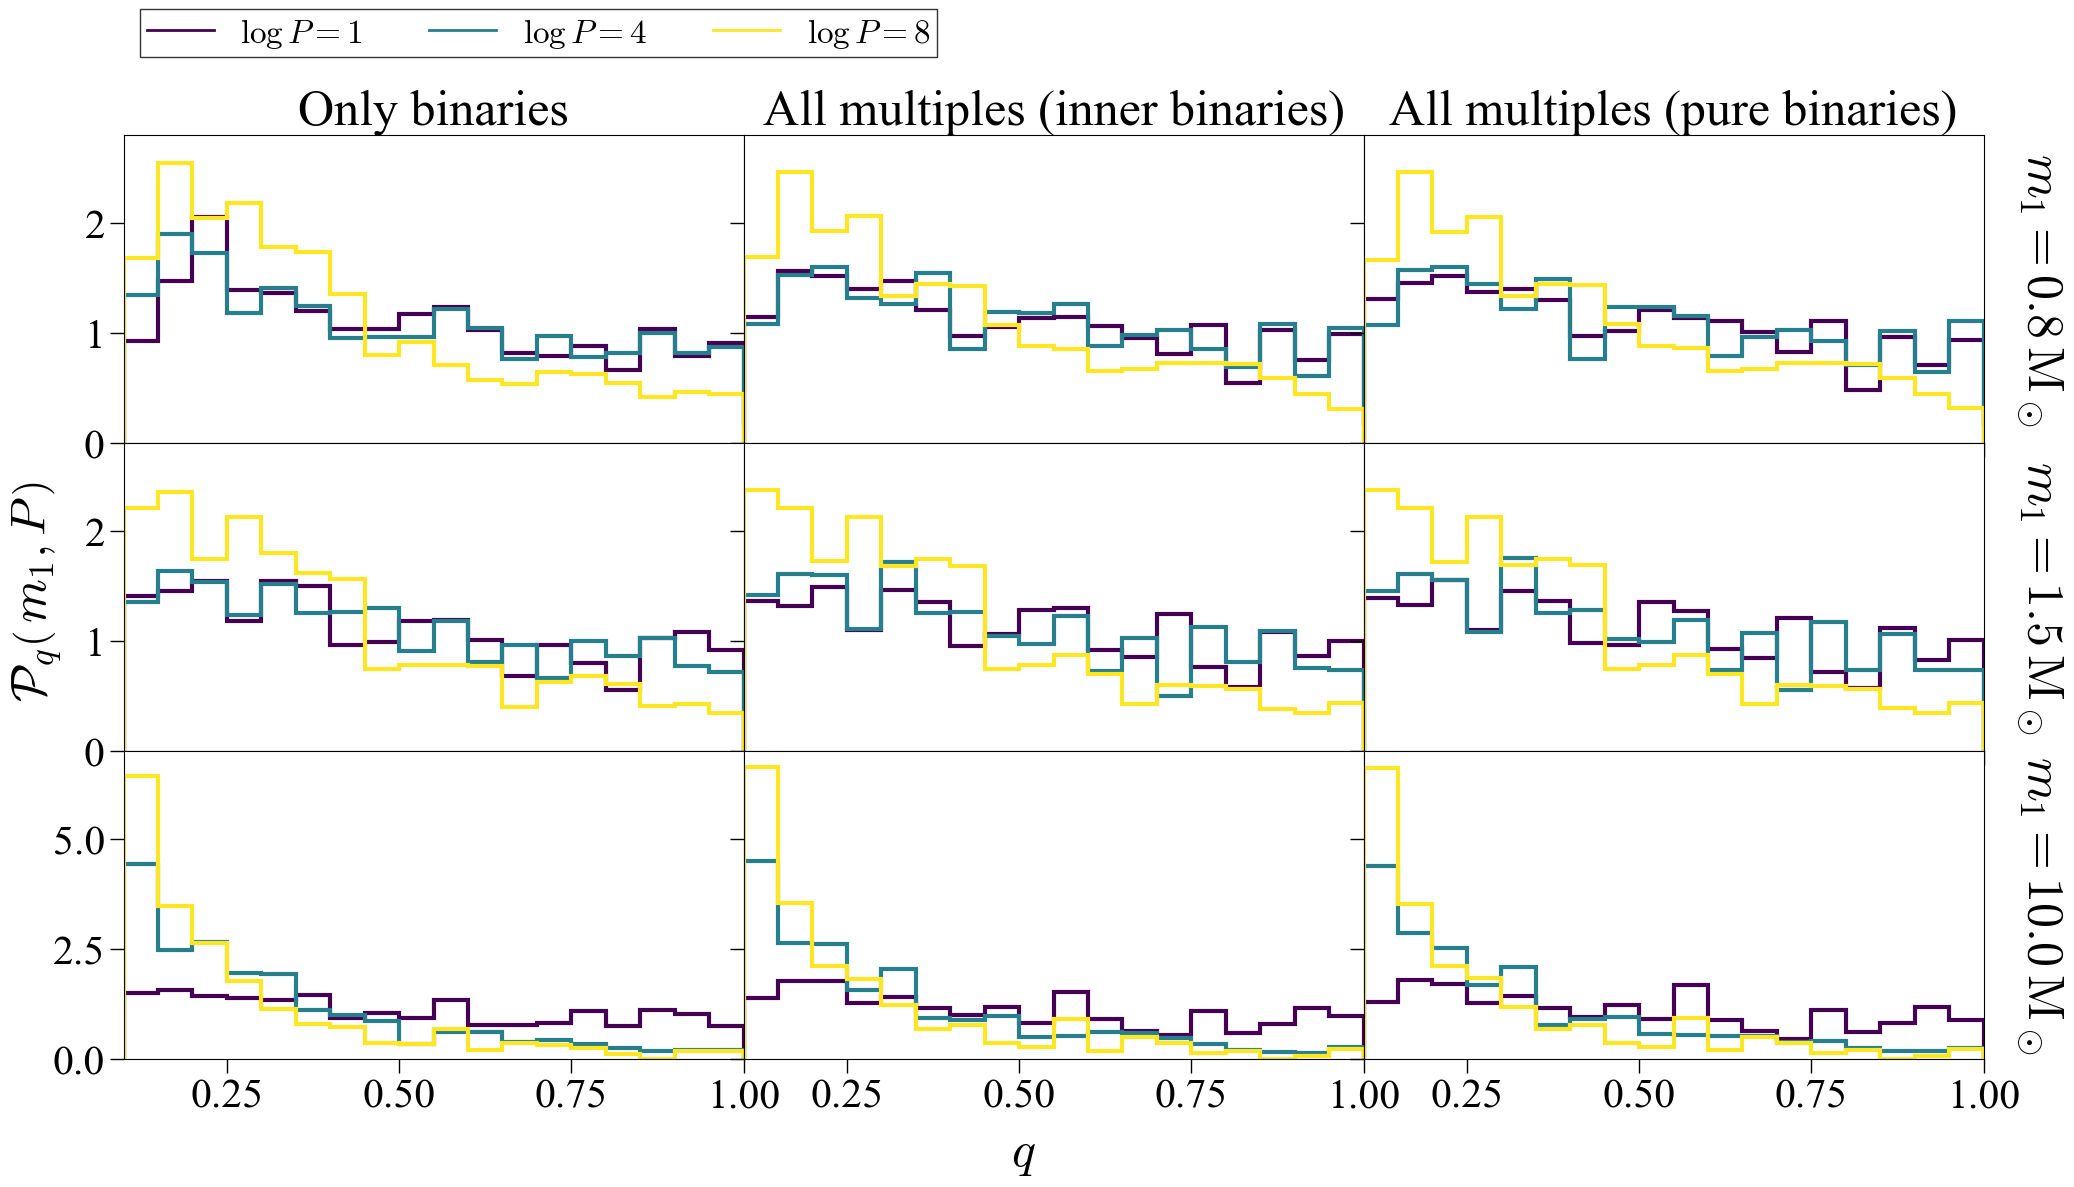

In [71]:
fig, axes = plt.subplots(3, 3, figsize=(24, 12), sharex=True, sharey='row')
fig.subplots_adjust(hspace=0, wspace=0)
rect = fig.patch
rect.set_facecolor('white')
logp_cnorm = plot_logps.max() - plot_logps.min()
hatches = ['-', '/', '\\']

### BINARIES ONLY ###
for i_m1, m1 in enumerate(plot_m1s):
    for logp, q_hs, hatch in zip(plot_logps, onlybin_q_hs[i_m1], hatches):
        c = cm.viridis((logp-plot_logps.min())/logp_cnorm)
        #axes[i_m1, 0].plot(q_centers, q_hs, c=c)
        #axes[i_m1, 0].stairs(q_hs, q_bins, facecolor=c, edgecolor='k', fill=True, alpha=0.5)
        axes[i_m1, 0].stairs(q_hs, q_bins, facecolor='none', edgecolor=c, alpha=1, fill=False, lw=3)
        #axes[i_m1, 0].stairs(q_hs, q_bins, facecolor='none', edgecolor='k', alpha=0.6, fill=True, zorder=3, hatch=hatch)
        
for i_m1, m1 in enumerate(plot_m1s):
    for logp, q_hs in zip(plot_logps, onlybin_canon_q_hs[i_m1]):
        c = cm.viridis((logp-plot_logps.min())/logp_cnorm)
        #axes[i_m1, 0].plot(canon_q_centers, q_hs, c=c, ls='--')
        
### ALL MULTIPLES INNER BINARIES ####
for i_m1, m1 in enumerate(plot_m1s):
    for logp, q_hs, hatch in zip(plot_logps, allmult_q_hs[i_m1], hatches):
        c = cm.viridis((logp-plot_logps.min())/logp_cnorm)
        #axes[i_m1, 0].plot(q_centers, q_hs, c=c)
        #axes[i_m1, 0].stairs(q_hs, q_bins, facecolor=c, edgecolor='k', fill=True, alpha=0.5)
        axes[i_m1, 1].stairs(q_hs, q_bins, facecolor='none', edgecolor=c, alpha=1, fill=False, lw=3)
        #axes[i_m1, 0].stairs(q_hs, q_bins, facecolor='none', edgecolor='k', alpha=0.6, fill=True, zorder=3, hatch=hatch)      
        
for i_m1, m1 in enumerate(plot_m1s):
    for logp, q_hs in zip(plot_logps, allmult_canon_q_hs[i_m1]):
        c = cm.viridis((logp-plot_logps.min())/logp_cnorm)
        #axes[i_m1, 1].plot(q_centers, q_hs, c=c, ls='--')
        
### ALL MULTIPLES PURE BINARIES ####
for i_m1, m1 in enumerate(plot_m1s):
    for logp, q_hs, hatch in zip(plot_logps, allmult_pure_q_hs[i_m1], hatches):
        c = cm.viridis((logp-plot_logps.min())/logp_cnorm)
        #axes[i_m1, 0].plot(q_centers, q_hs, c=c)
        #axes[i_m1, 0].stairs(q_hs, q_bins, facecolor=c, edgecolor='k', fill=True, alpha=0.5)
        axes[i_m1, 2].stairs(q_hs, q_bins, facecolor='none', edgecolor=c, alpha=1, fill=False, lw=3)
        #axes[i_m1, 0].stairs(q_hs, q_bins, facecolor='none', edgecolor='k', alpha=0.6, fill=True, zorder=3, hatch=hatch)
        
for i_m1, m1 in enumerate(plot_m1s):
    for logp, q_hs in zip(plot_logps, allmult_canon_pure_q_hs[i_m1]):
        c = cm.viridis((logp-plot_logps.min())/logp_cnorm)
        #axes[i_m1, 2].plot(q_centers, q_hs, c=c, ls='--')
        
### DETAILS ###
for ax in axes.flatten():
    ax.set_xlim(0.1, 1)
    ax.tick_params(labelsize=30)
    
fig.text(0.5, 0.05, '$q$', va='top', ha='center', transform=fig.transFigure, fontsize=36)
fig.text(0.1, 0.5, r'$\mathcal{P}_q\left(\,m_1,P\,\right)$', rotation=90, va='center', ha='right', transform=fig.transFigure, fontsize=36)

fig.text(0.5, 1, 'Only binaries', ha='center', va='bottom', fontsize=36, transform=axes[0,0].transAxes)
fig.text(0.5, 1, 'All multiples (inner binaries)', ha='center', va='bottom', fontsize=36, transform=axes[0,1].transAxes)
fig.text(0.5, 1, 'All multiples (pure binaries)', ha='center', va='bottom', fontsize=36, transform=axes[0,2].transAxes)

fig.text(1.05, 0.5, f'$m_1={plot_m1s[0]}\,\mathrm{{M}}_\odot$', ha='left', va='center', rotation=-90, fontsize=36, transform=axes[0,2].transAxes)
fig.text(1.05, 0.5, f'$m_1={plot_m1s[1]}\,\mathrm{{M}}_\odot$', ha='left', va='center', rotation=-90, fontsize=36, transform=axes[1,2].transAxes)
fig.text(1.05, 0.5, f'$m_1={plot_m1s[2]}\,\mathrm{{M}}_\odot$', ha='left', va='center', rotation=-90, fontsize=36, transform=axes[2,2].transAxes)

### LEGEND ###
handles = []
for logp in plot_logps:
    c = cm.viridis((logp-plot_logps.min())/logp_cnorm)
    handle = Line2D([0], [0], label=f'$\log P = {logp}$', color=c, linestyle='-')
    handles.append(handle)
axes[0,0].legend(handles=handles, frameon=True, loc='lower left', bbox_to_anchor=(0,1.2), ncol=3, edgecolor='black', fancybox=False, borderpad=0.2, fontsize=24)

axes[2,0].set_ylim(0,7)
#axes[1,0].set_yticks([5,10])
axes[1,0].set_ylim(0,2.8)
#axes[0,0].set_yticks([5,10])
axes[0,0].set_ylim(0,2.8)

#fig.savefig(FIGURE_FOLDER/'q_sample_muliplicity_hist_1e6.pdf', bbox_inches='tight')
#fig.savefig(FIGURE_FOLDER/'q_sample_muliplicity_hist_1e6.png', bbox_inches='tight')

<>:56: SyntaxWarning: invalid escape sequence '\,'
<>:56: SyntaxWarning: invalid escape sequence '\o'
<>:57: SyntaxWarning: invalid escape sequence '\,'
<>:57: SyntaxWarning: invalid escape sequence '\o'
<>:58: SyntaxWarning: invalid escape sequence '\,'
<>:58: SyntaxWarning: invalid escape sequence '\o'
<>:64: SyntaxWarning: invalid escape sequence '\l'
<>:56: SyntaxWarning: invalid escape sequence '\,'
<>:56: SyntaxWarning: invalid escape sequence '\o'
<>:57: SyntaxWarning: invalid escape sequence '\,'
<>:57: SyntaxWarning: invalid escape sequence '\o'
<>:58: SyntaxWarning: invalid escape sequence '\,'
<>:58: SyntaxWarning: invalid escape sequence '\o'
<>:64: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_697613/425410728.py:56: SyntaxWarning: invalid escape sequence '\,'
  fig.text(1.05, 0.5, f'$m_1={plot_m1s[0]}\,\mathrm{{M}}_\odot$', ha='left', va='center', rotation=-90, fontsize=36, transform=axes[0,2].transAxes)
/tmp/ipykernel_697613/425410728.py:56: SyntaxWarning: i

(0.0, 2.8)

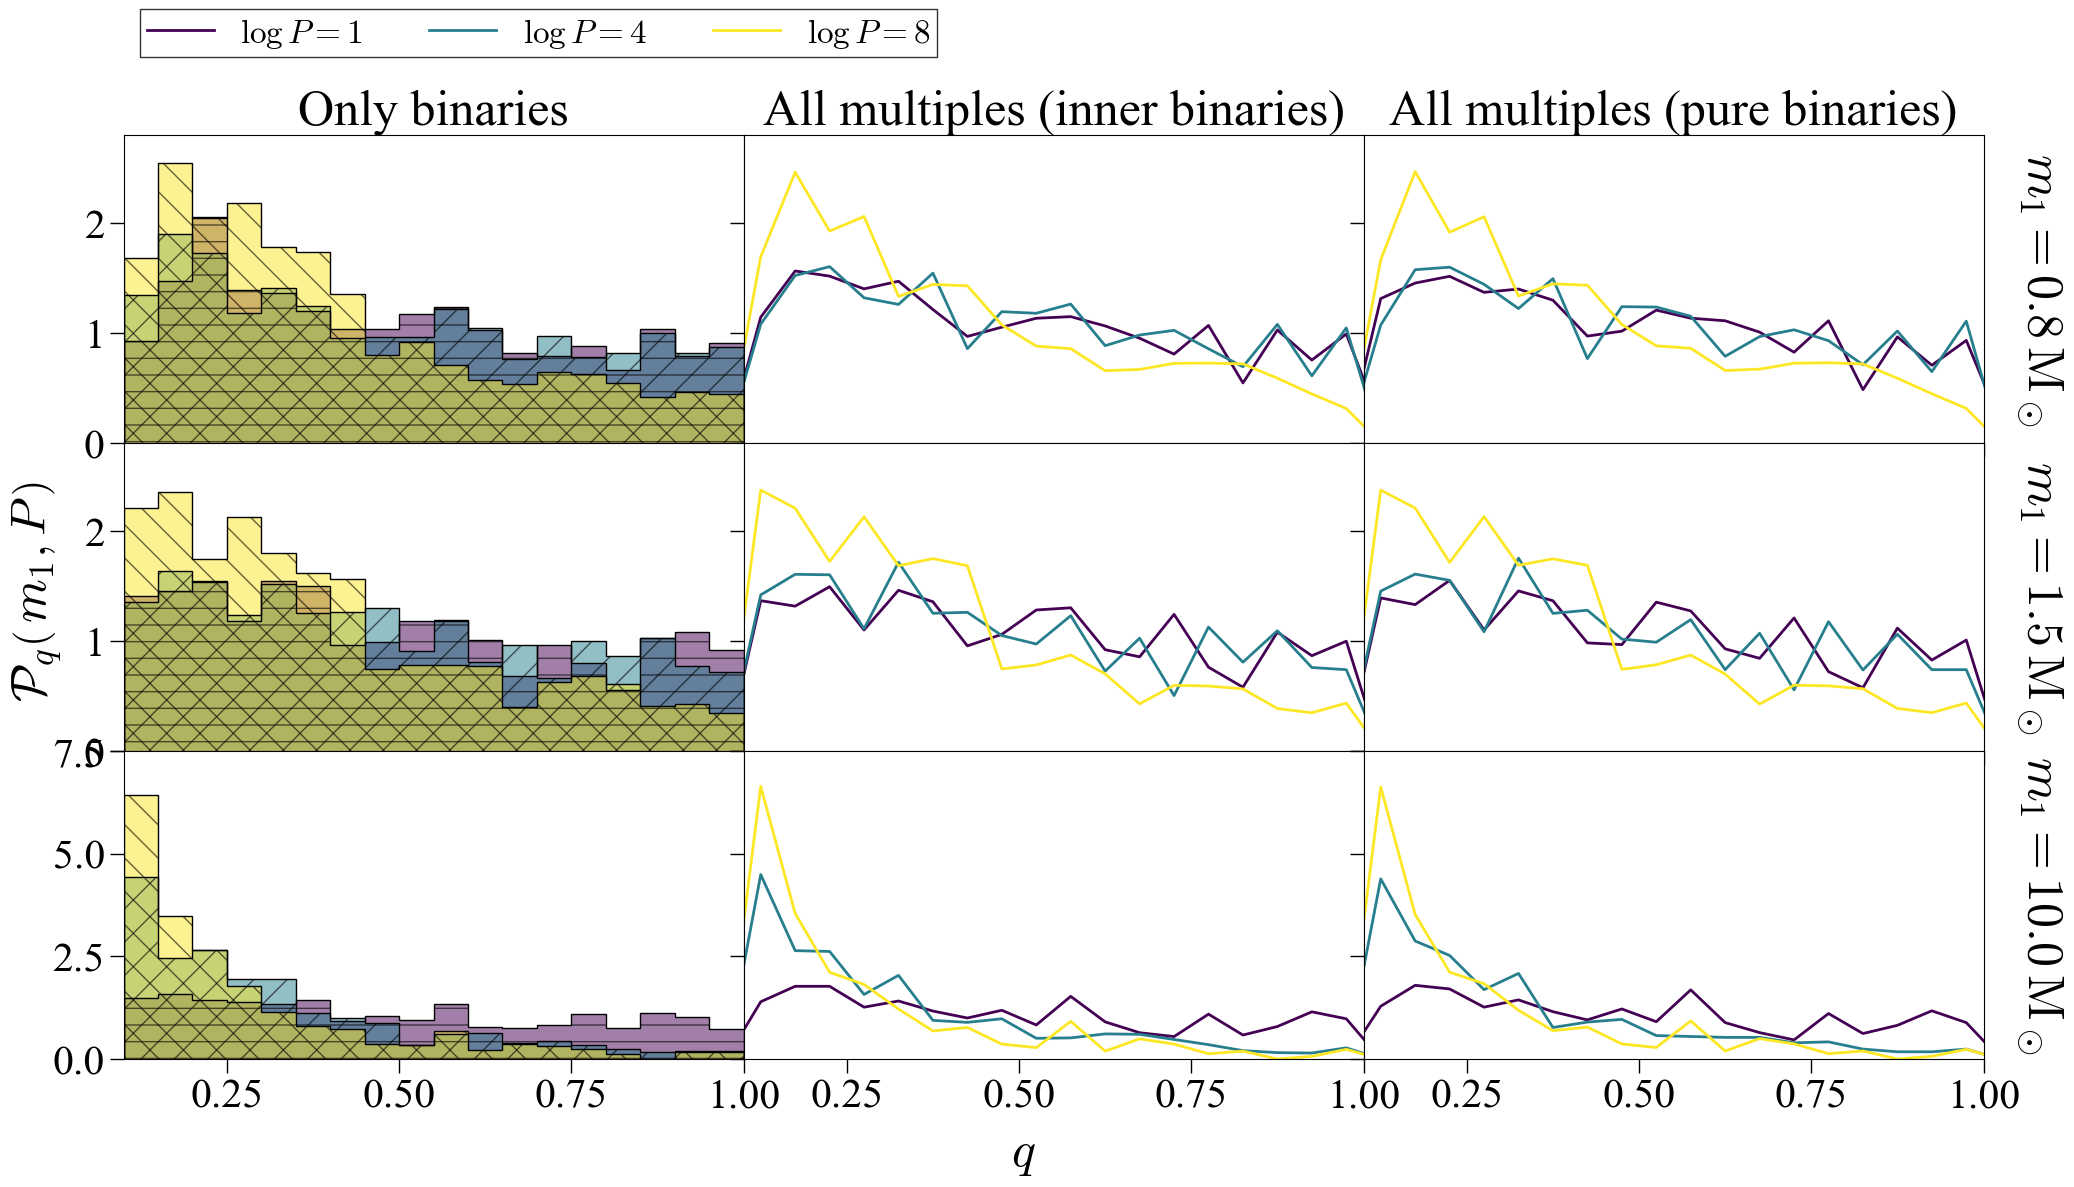

In [72]:
fig, axes = plt.subplots(3, 3, figsize=(24, 12), sharex=True, sharey='row')
fig.subplots_adjust(hspace=0, wspace=0)
rect = fig.patch
rect.set_facecolor('white')
logp_cnorm = plot_logps.max() - plot_logps.min()
hatches = ['-', '/', '\\']

### BINARIES ONLY ###
for i_m1, m1 in enumerate(plot_m1s):
    for logp, q_hs, hatch in zip(plot_logps, onlybin_q_hs[i_m1], hatches):
        c = cm.viridis((logp-plot_logps.min())/logp_cnorm)
        #axes[i_m1, 0].plot(q_centers, q_hs, c=c)
        axes[i_m1, 0].stairs(q_hs, q_bins, facecolor=c, edgecolor='k', fill=True, alpha=0.5)
        axes[i_m1, 0].stairs(q_hs, q_bins, facecolor='none', edgecolor='k', alpha=1, fill=False, zorder=3)
        axes[i_m1, 0].stairs(q_hs, q_bins, facecolor='none', edgecolor='k', alpha=0.6, fill=True, zorder=3, hatch=hatch)
        
for i_m1, m1 in enumerate(plot_m1s):
    for logp, q_hs in zip(plot_logps, onlybin_canon_q_hs[i_m1]):
        c = cm.viridis((logp-plot_logps.min())/logp_cnorm)
        #axes[i_m1, 0].plot(canon_q_centers, q_hs, c=c, ls='--')
        
### ALL MULTIPLES INNER BINARIES ####
for i_m1, m1 in enumerate(plot_m1s):
    for logp, q_hs in zip(plot_logps, allmult_q_hs[i_m1]):
        c = cm.viridis((logp-plot_logps.min())/logp_cnorm)
        axes[i_m1, 1].plot(q_centers, q_hs, c=c)
        
for i_m1, m1 in enumerate(plot_m1s):
    for logp, q_hs in zip(plot_logps, allmult_canon_q_hs[i_m1]):
        c = cm.viridis((logp-plot_logps.min())/logp_cnorm)
        #axes[i_m1, 1].plot(q_centers, q_hs, c=c, ls='--')
        
### ALL MULTIPLES PURE BINARIES ####
for i_m1, m1 in enumerate(plot_m1s):
    for logp, q_hs in zip(plot_logps, allmult_pure_q_hs[i_m1]):
        c = cm.viridis((logp-plot_logps.min())/logp_cnorm)
        axes[i_m1, 2].plot(q_centers, q_hs, c=c)
        
for i_m1, m1 in enumerate(plot_m1s):
    for logp, q_hs in zip(plot_logps, allmult_canon_pure_q_hs[i_m1]):
        c = cm.viridis((logp-plot_logps.min())/logp_cnorm)
        #axes[i_m1, 2].plot(q_centers, q_hs, c=c, ls='--')
        
### DETAILS ###
for ax in axes.flatten():
    ax.set_xlim(0.1, 1)
    ax.tick_params(labelsize=30)
    
fig.text(0.5, 0.05, '$q$', va='top', ha='center', transform=fig.transFigure, fontsize=36)
fig.text(0.1, 0.5, r'$\mathcal{P}_q\left(\,m_1,P\,\right)$', rotation=90, va='center', ha='right', transform=fig.transFigure, fontsize=36)

fig.text(0.5, 1, 'Only binaries', ha='center', va='bottom', fontsize=36, transform=axes[0,0].transAxes)
fig.text(0.5, 1, 'All multiples (inner binaries)', ha='center', va='bottom', fontsize=36, transform=axes[0,1].transAxes)
fig.text(0.5, 1, 'All multiples (pure binaries)', ha='center', va='bottom', fontsize=36, transform=axes[0,2].transAxes)

fig.text(1.05, 0.5, f'$m_1={plot_m1s[0]}\,\mathrm{{M}}_\odot$', ha='left', va='center', rotation=-90, fontsize=36, transform=axes[0,2].transAxes)
fig.text(1.05, 0.5, f'$m_1={plot_m1s[1]}\,\mathrm{{M}}_\odot$', ha='left', va='center', rotation=-90, fontsize=36, transform=axes[1,2].transAxes)
fig.text(1.05, 0.5, f'$m_1={plot_m1s[2]}\,\mathrm{{M}}_\odot$', ha='left', va='center', rotation=-90, fontsize=36, transform=axes[2,2].transAxes)

### LEGEND ###
handles = []
for logp in plot_logps:
    c = cm.viridis((logp-plot_logps.min())/logp_cnorm)
    handle = Line2D([0], [0], label=f'$\log P = {logp}$', color=c, linestyle='-')
    handles.append(handle)
axes[0,0].legend(handles=handles, frameon=True, loc='lower left', bbox_to_anchor=(0,1.2), ncol=3, edgecolor='black', fancybox=False, borderpad=0.2, fontsize=24)

axes[2,0].set_ylim(0,7.5)
#axes[1,0].set_yticks([5,10])
axes[1,0].set_ylim(0,2.8)
#axes[0,0].set_yticks([5,10])
axes[0,0].set_ylim(0,2.8)

#fig.savefig(FIGURE_FOLDER/'q_sample_muliplicity_1e6.pdf', bbox_inches='tight')
#fig.savefig(FIGURE_FOLDER/'q_sample_muliplicity_1e6.png', bbox_inches='tight')


### $e$ sampĺes

In [73]:
plot_m1s = np.array([0.8, 5.25, 7])
plot_logps = np.array([0.5, 4, 8])

In [74]:
plot_es = np.linspace(0,1,50)

plot_p_es_array = np.empty((plot_m1s.shape[0], 
                            plot_logps.shape[0], 
                            plot_es.shape[0]), np.float64)

e_distr = EccentricityDistribution()
for m1_i, m1 in enumerate(plot_m1s):
    for logp_i, logp in enumerate(plot_logps):
        e_distr.set_parameters(m1, logp)
        for e_i, e in enumerate(plot_es):
            plot_p_es_array[m1_i, logp_i, e_i] = e_distr.prob(e)

In [75]:
e_width = 0.2
e_bins = np.arange(0, 1 + e_width, e_width)
e_centers = np.array([(e0+e1)/2 for e0,e1 in zip(e_bins[:-1], e_bins[1:])])

In [76]:
canon_e_width = 0.1
canon_e_bins = np.arange(0, 1 + 2*canon_e_width, canon_e_width)
canon_e_centers = np.array([(e0+e1)/2 for e0,e1 in zip(canon_e_bins[:-1], canon_e_bins[1:])])

In [77]:
df = onlybin_df
e_hs = []

unique_m1s = np.sort(np.unique(df.m1.to_numpy()))
for m1 in plot_m1s:
    closest_m1_i = np.argmin(np.abs(unique_m1s- m1))
    closest_m1 = unique_m1s[closest_m1_i]
    closest_m1s.append(closest_m1)
    subdf = df[df.m1 == closest_m1]
    subdf = subdf[subdf.ncp >= 1]
    e_hs_m1 = []
    for logp in plot_logps:
        unique_logps = np.sort(np.unique(subdf.logp.to_numpy()))
        closest_logp_i = np.argmin(np.abs(unique_logps - logp))
        closest_logp = unique_logps[closest_logp_i]
        closest_logps_.append(closest_logp)
        subsubdf = subdf[subdf.logp == closest_logp]
        es = np.sort(subsubdf.e.to_numpy())
        e_hs_, _ = np.histogram(es, bins=e_bins, density=True)
        e_hs_m1.append(e_hs_)
    e_hs.append(e_hs_m1)
    
onlybin_e_hs = e_hs

In [78]:
df = allmult_df
e_hs = []

unique_m1s = np.sort(np.unique(df.m1.to_numpy()))
for m1 in plot_m1s:
    closest_m1_i = np.argmin(np.abs(unique_m1s- m1))
    closest_m1 = unique_m1s[closest_m1_i]
    closest_m1s.append(closest_m1)
    subdf = df[df.m1 == closest_m1]
    subdf = subdf[subdf.ncp >= 1]
    e_hs_m1 = []
    for logp in plot_logps:
        unique_logps = np.sort(np.unique(subdf.logp.to_numpy()))
        closest_logp_i = np.argmin(np.abs(unique_logps - logp))
        closest_logp = unique_logps[closest_logp_i]
        closest_logps_.append(closest_logp)
        subsubdf = subdf[subdf.logp == closest_logp]
        es = np.sort(subsubdf.e.to_numpy())
        e_hs_, _ = np.histogram(es, bins=e_bins, density=True)
        e_hs_m1.append(e_hs_)
    e_hs.append(e_hs_m1)
    
allmult_e_hs = e_hs

In [79]:
df = onlybin_canon_df
e_hs = []

unique_m1s = np.sort(np.unique(df.m1.to_numpy()))
for m1 in plot_m1s:
    closest_m1_i = np.argmin(np.abs(unique_m1s- m1))
    closest_m1 = unique_m1s[closest_m1_i]
    closest_m1s.append(closest_m1)
    subdf = df[df.m1 == closest_m1]
    subdf = subdf[subdf.ncp >= 1]
    e_hs_m1 = []
    for logp in plot_logps:
        unique_logps = np.sort(np.unique(subdf.logp.to_numpy()))
        closest_logp_i = np.argmin(np.abs(unique_logps - logp))
        closest_logp = unique_logps[closest_logp_i]
        closest_logps_.append(closest_logp)
        subsubdf = subdf[subdf.logp == closest_logp]
        es = np.sort(subsubdf.e.to_numpy())
        e_hs_, _ = np.histogram(es, bins=canon_e_bins, density=True)
        e_hs_m1.append(e_hs_)
    e_hs.append(e_hs_m1)
    
onlybin_canon_e_hs = e_hs

In [80]:
df = allmult_canon_df
e_hs = []

unique_m1s = np.sort(np.unique(df.m1.to_numpy()))
for m1 in plot_m1s:
    closest_m1_i = np.argmin(np.abs(unique_m1s- m1))
    closest_m1 = unique_m1s[closest_m1_i]
    closest_m1s.append(closest_m1)
    subdf = df[df.m1 == closest_m1]
    subdf = subdf[subdf.ncp >= 1]
    e_hs_m1 = []
    for logp in plot_logps:
        unique_logps = np.sort(np.unique(subdf.logp.to_numpy()))
        closest_logp_i = np.argmin(np.abs(unique_logps - logp))
        closest_logp = unique_logps[closest_logp_i]
        closest_logps_.append(closest_logp)
        subsubdf = subdf[subdf.logp == closest_logp]
        es = np.sort(subsubdf.e.to_numpy())
        e_hs_, _ = np.histogram(es, bins=canon_e_bins, density=True)
        e_hs_m1.append(e_hs_)
    e_hs.append(e_hs_m1)
    
allmult_canon_e_hs = e_hs

In [81]:
df = allmult_df
e_hs = []

unique_m1s = np.sort(np.unique(df.m1.to_numpy()))
for m1 in plot_m1s:
    closest_m1_i = np.argmin(np.abs(unique_m1s- m1))
    closest_m1 = unique_m1s[closest_m1_i]
    closest_m1s.append(closest_m1)
    subdf = df[df.m1 == closest_m1]
    subdf = subdf[subdf.ncp == 1]
    e_hs_m1 = []
    for logp in plot_logps:
        unique_logps = np.sort(np.unique(subdf.logp.to_numpy()))
        closest_logp_i = np.argmin(np.abs(unique_logps - logp))
        closest_logp = unique_logps[closest_logp_i]
        closest_logps_.append(closest_logp)
        subsubdf = subdf[subdf.logp == closest_logp]
        es = np.sort(subsubdf.e.to_numpy())
        e_hs_, _ = np.histogram(es, bins=e_bins, density=True)
        e_hs_m1.append(e_hs_)
    e_hs.append(e_hs_m1)
    
allmult_pure_e_hs = e_hs

In [82]:
df = allmult_canon_df
e_hs = []

unique_m1s = np.sort(np.unique(df.m1.to_numpy()))
for m1 in plot_m1s:
    closest_m1_i = np.argmin(np.abs(unique_m1s- m1))
    closest_m1 = unique_m1s[closest_m1_i]
    closest_m1s.append(closest_m1)
    subdf = df[df.m1 == closest_m1]
    subdf = subdf[subdf.ncp == 1]
    e_hs_m1 = []
    for logp in plot_logps:
        unique_logps = np.sort(np.unique(subdf.logp.to_numpy()))
        closest_logp_i = np.argmin(np.abs(unique_logps - logp))
        closest_logp = unique_logps[closest_logp_i]
        closest_logps_.append(closest_logp)
        subsubdf = subdf[subdf.logp == closest_logp]
        es = np.sort(subsubdf.e.to_numpy())
        e_hs_, _ = np.histogram(es, bins=canon_e_bins, density=True)
        e_hs_m1.append(e_hs_)
    e_hs.append(e_hs_m1)
    
allmult_canon_pure_e_hs = e_hs

In [83]:
from matplotlib.patches import Patch
from matplotlib import colors

In [84]:
cm.viridis((4-plot_logps.min())/logp_cnorm)

(0.127568, 0.566949, 0.550556, 1.0)

<>:66: SyntaxWarning: invalid escape sequence '\,'
<>:66: SyntaxWarning: invalid escape sequence '\o'
<>:67: SyntaxWarning: invalid escape sequence '\,'
<>:67: SyntaxWarning: invalid escape sequence '\o'
<>:68: SyntaxWarning: invalid escape sequence '\,'
<>:68: SyntaxWarning: invalid escape sequence '\o'
<>:74: SyntaxWarning: invalid escape sequence '\l'
<>:66: SyntaxWarning: invalid escape sequence '\,'
<>:66: SyntaxWarning: invalid escape sequence '\o'
<>:67: SyntaxWarning: invalid escape sequence '\,'
<>:67: SyntaxWarning: invalid escape sequence '\o'
<>:68: SyntaxWarning: invalid escape sequence '\,'
<>:68: SyntaxWarning: invalid escape sequence '\o'
<>:74: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_697613/3073683671.py:66: SyntaxWarning: invalid escape sequence '\,'
  fig.text(1.0, 0.5, f'$m_1={plot_m1s[0]}\,\mathrm{{M}}_\odot$', ha='left', va='center', rotation=-90, fontsize=34, transform=axes[0,2].transAxes)
/tmp/ipykernel_697613/3073683671.py:66: SyntaxWarning: 

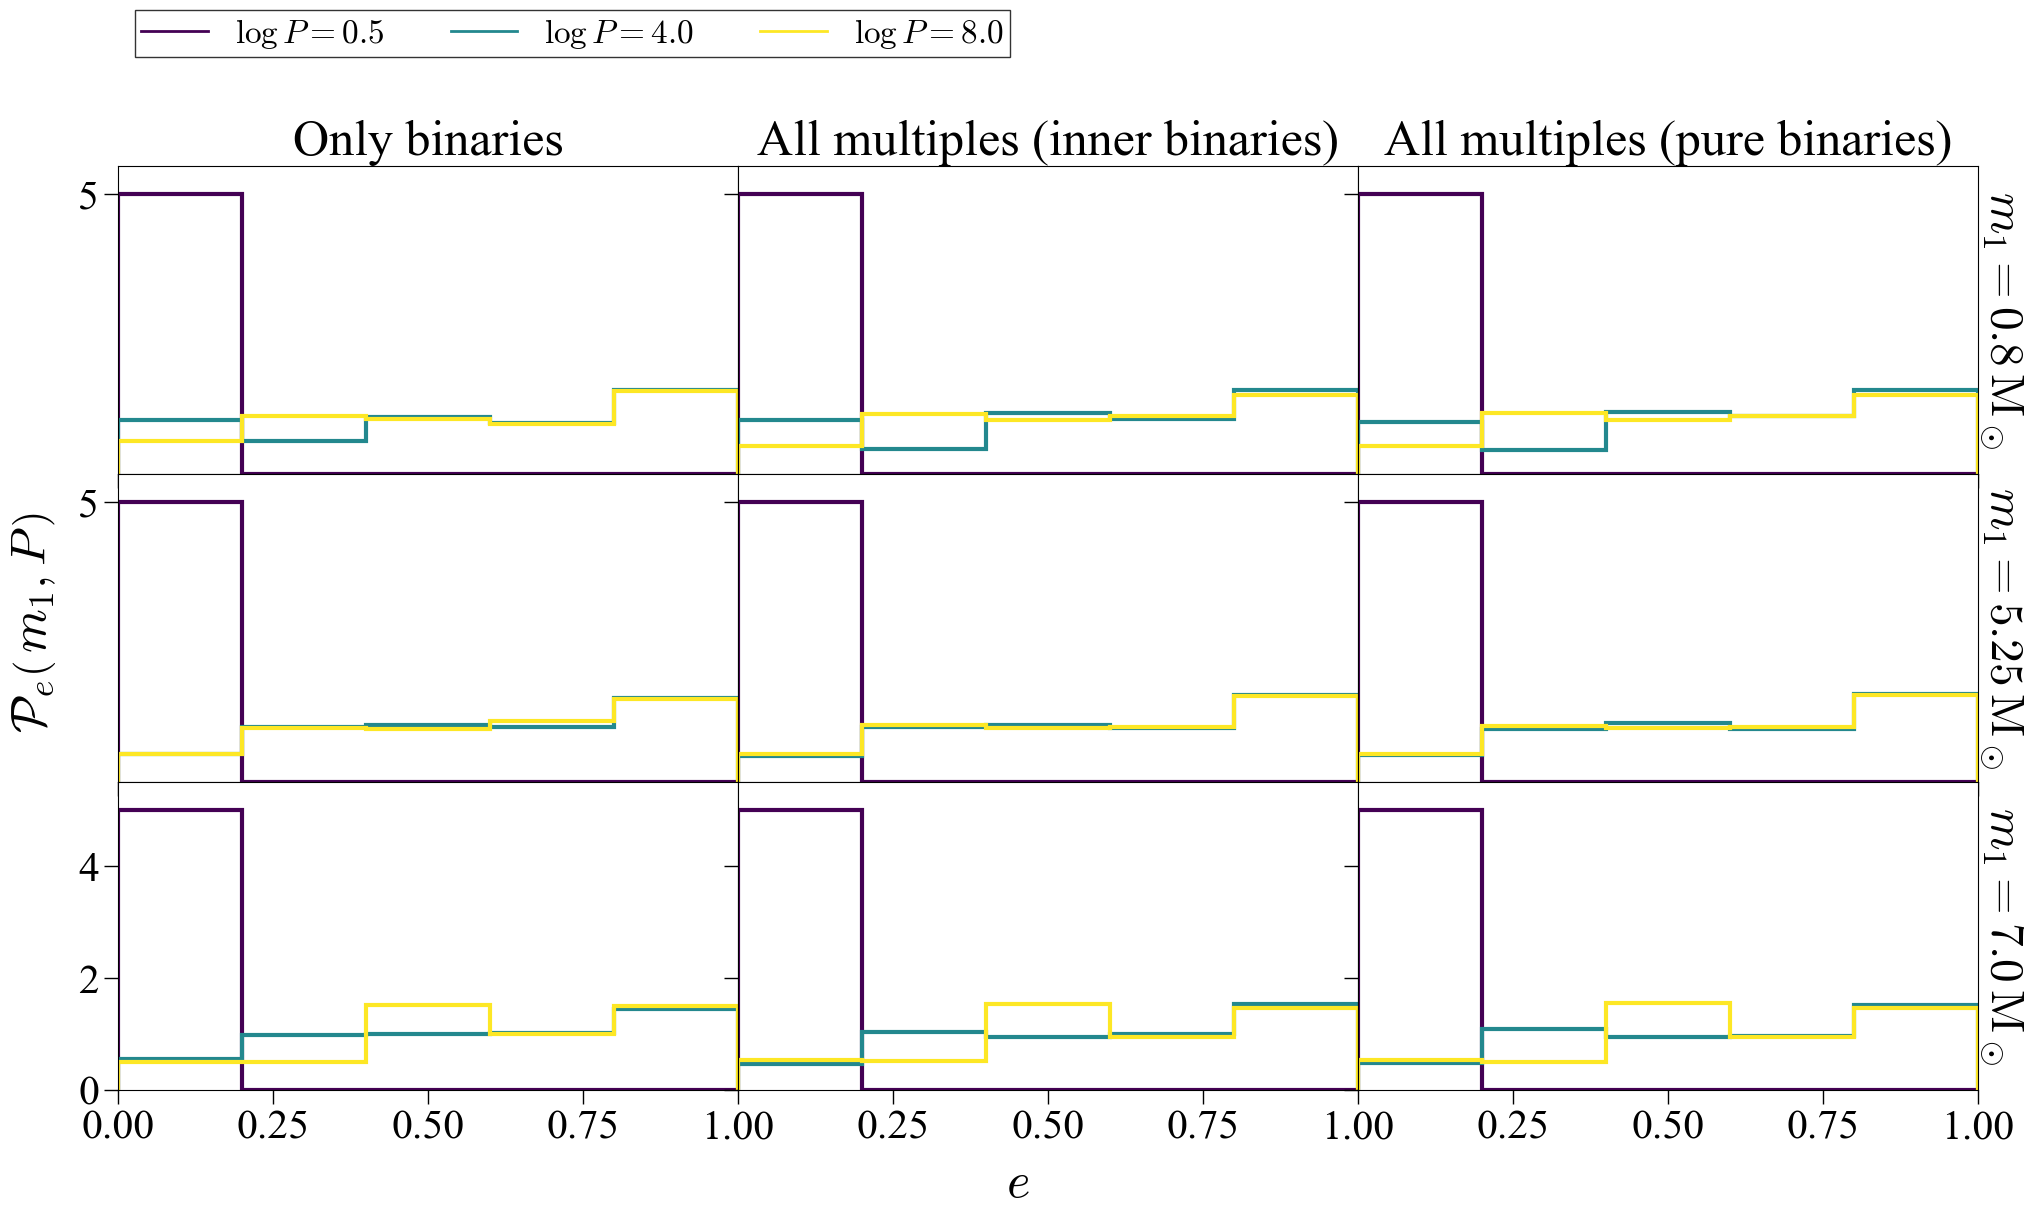

In [85]:
fig, axes = plt.subplots(3, 3, figsize=(24, 12), sharex='col', sharey='row')
fig.subplots_adjust(hspace=0, wspace=0)
rect = fig.patch
rect.set_facecolor('white')
logp_cnorm = plot_logps.max() - plot_logps.min()
hatches = ['-', '/', '\\']

### BINARIES ONLY ###
for i_m1, m1 in enumerate(plot_m1s):
    for logp, e_hs, hatch in zip(plot_logps, onlybin_e_hs[i_m1], hatches):
        c = cm.viridis((logp-plot_logps.min())/logp_cnorm)
        #axes[i_m1, 0].plot(q_centers, q_hs, c=c)
        #axes[i_m1, 0].stairs(q_hs, q_bins, facecolor=c, edgecolor='k', fill=True, alpha=0.5)
        axes[i_m1, 0].stairs(e_hs, e_bins, facecolor='none', edgecolor=c, alpha=1, fill=False, lw=3)
        #axes[i_m1, 0].stairs(q_hs, q_bins, facecolor='none', edgecolor='k', alpha=0.6, fill=True, zorder=3, hatch=hatch)
        
for i_m1, m1 in enumerate(plot_m1s):
    for logp, e_hs in zip(plot_logps, onlybin_canon_e_hs[i_m1]):
        c = cm.viridis((logp-plot_logps.min())/logp_cnorm)
        
        #axes[i_m1, 0].plot(canon_e_centers, e_hs, c=c, ls='--')
        
### ALL MULTIPLES INNER BINARIES ####
for i_m1, m1 in enumerate(plot_m1s):
    for logp, e_hs, hatch in zip(plot_logps, allmult_e_hs[i_m1], hatches):
        c = cm.viridis((logp-plot_logps.min())/logp_cnorm)
        #axes[i_m1, 1].plot(e_centers, e_hs, c=c)
        #axes[i_m1, 0].stairs(q_hs, q_bins, facecolor=c, edgecolor='k', fill=True, alpha=0.5)
        axes[i_m1, 1].stairs(e_hs, e_bins, facecolor='none', edgecolor=c, alpha=1, fill=False, lw=3)
        #axes[i_m1, 0].stairs(q_hs, q_bins, facecolor='none', edgecolor='k', alpha=0.6, fill=True, zorder=3, hatch=hatch)
        
for i_m1, m1 in enumerate(plot_m1s):
    for logp, e_hs in zip(plot_logps, allmult_canon_e_hs[i_m1]):
        c = cm.viridis((logp-plot_logps.min())/logp_cnorm)
        #axes[i_m1, 1].plot(e_centers, e_hs, c=c, ls='--')
        
### ALL MULTIPLES PURE BINARIES ####
for i_m1, m1 in enumerate(plot_m1s):
    for logp, e_hs, hatch in zip(plot_logps, allmult_pure_e_hs[i_m1], hatches):
        c = cm.viridis((logp-plot_logps.min())/logp_cnorm)
        #axes[i_m1, 0].plot(q_centers, q_hs, c=c)
        #axes[i_m1, 0].stairs(q_hs, q_bins, facecolor=c, edgecolor='k', fill=True, alpha=0.5)
        axes[i_m1, 2].stairs(e_hs, e_bins, facecolor='none', edgecolor=c, alpha=1, fill=False, lw=3)
        #axes[i_m1, 0].stairs(q_hs, q_bins, facecolor='none', edgecolor='k', alpha=0.6, fill=True, zorder=3, hatch=hatch)
        #if i_m1 == 0:
            #axes[i_m1, 2].stairs(e_hs, e_bins, facecolor=c, edgecolor='k', alpha=0, fill=True, zorder=3, hatch=hatch, label=f'$\log P = {logp}$')
        
for i_m1, m1 in enumerate(plot_m1s):
    for logp, e_hs in zip(plot_logps, allmult_canon_pure_e_hs[i_m1]):
        c = cm.viridis((logp-plot_logps.min())/logp_cnorm)
        #axes[i_m1, 2].plot(e_centers, e_hs, c=c, ls='--')
        
### DETAILS ###
for ax in axes.flatten():
    ax.set_xlim(0, 1)
    ax.set_ylim(0)
    ax.tick_params(labelsize=30)
    
fig.text(0.5, 0.05, '$e$', va='top', ha='center', transform=fig.transFigure, fontsize=36)
fig.text(0.1, 0.5, r'$\mathcal{P}_e\left(\,m_1,P\,\right)$', rotation=90, va='center', ha='right', transform=fig.transFigure, fontsize=36)

fig.text(0.5, 1, 'Only binaries', ha='center', va='bottom', fontsize=36, transform=axes[0,0].transAxes)
fig.text(0.5, 1, 'All multiples (inner binaries)', ha='center', va='bottom', fontsize=36, transform=axes[0,1].transAxes)
fig.text(0.5, 1, 'All multiples (pure binaries)', ha='center', va='bottom', fontsize=36, transform=axes[0,2].transAxes)

fig.text(1.0, 0.5, f'$m_1={plot_m1s[0]}\,\mathrm{{M}}_\odot$', ha='left', va='center', rotation=-90, fontsize=34, transform=axes[0,2].transAxes)
fig.text(1.0, 0.5, f'$m_1={plot_m1s[1]}\,\mathrm{{M}}_\odot$', ha='left', va='center', rotation=-90, fontsize=34, transform=axes[1,2].transAxes)
fig.text(1.0, 0.5, f'$m_1={plot_m1s[2]}\,\mathrm{{M}}_\odot$', ha='left', va='center', rotation=-90, fontsize=34, transform=axes[2,2].transAxes)

### LEGEND ###
handles = []
for logp, hatch in zip(plot_logps, hatches):
    c = cm.viridis((logp-plot_logps.min())/logp_cnorm)
    handle = Line2D([0], [0], label=f'$\log P = {logp}$', color=c, linestyle='-')
    #handle = Patch(edgecolor='black', facecolor=c, hatch=hatch, alpha=0.5, label=f'$\log P = {logp}$')
    handles.append(handle)
#handle = Patch(edgecolor='black', facecolor=intersec_c, hatch='x', alpha=0.8, label=f'Mix')    
#handles.append(handle)
axes[0,0].legend(handles=handles, frameon=True, loc='lower left', bbox_to_anchor=(0,1.3), ncol=3, edgecolor='black', fancybox=False, borderpad=0.2, fontsize=24)

axes[2,0].set_ylim(0,5.5)
axes[1,0].set_yticks([5,10])
axes[1,0].set_ylim(0,5.5)
axes[0,0].set_yticks([5,10])
axes[0,0].set_ylim(0,5.5)

axes[0,1].set_xticks([0.25, 0.5, 0.75, 1])
axes[0,2].set_xticks([0.25, 0.5, 0.75, 1])

#fig.savefig(FIGURE_FOLDER/'e_sample_muliplicity_1e6.pdf', bbox_inches='tight')
#fig.savefig(FIGURE_FOLDER/'e_sample_muliplicity_1e6.png', bbox_inches='tight')

<>:66: SyntaxWarning: invalid escape sequence '\,'
<>:66: SyntaxWarning: invalid escape sequence '\o'
<>:67: SyntaxWarning: invalid escape sequence '\,'
<>:67: SyntaxWarning: invalid escape sequence '\o'
<>:68: SyntaxWarning: invalid escape sequence '\,'
<>:68: SyntaxWarning: invalid escape sequence '\o'
<>:75: SyntaxWarning: invalid escape sequence '\l'
<>:66: SyntaxWarning: invalid escape sequence '\,'
<>:66: SyntaxWarning: invalid escape sequence '\o'
<>:67: SyntaxWarning: invalid escape sequence '\,'
<>:67: SyntaxWarning: invalid escape sequence '\o'
<>:68: SyntaxWarning: invalid escape sequence '\,'
<>:68: SyntaxWarning: invalid escape sequence '\o'
<>:75: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_697613/1104244841.py:66: SyntaxWarning: invalid escape sequence '\,'
  fig.text(1.0, 0.5, f'$m_1={plot_m1s[0]}\,\mathrm{{M}}_\odot$', ha='left', va='center', rotation=-90, fontsize=34, transform=axes[0,2].transAxes)
/tmp/ipykernel_697613/1104244841.py:66: SyntaxWarning: 

(0.0, 5.2)

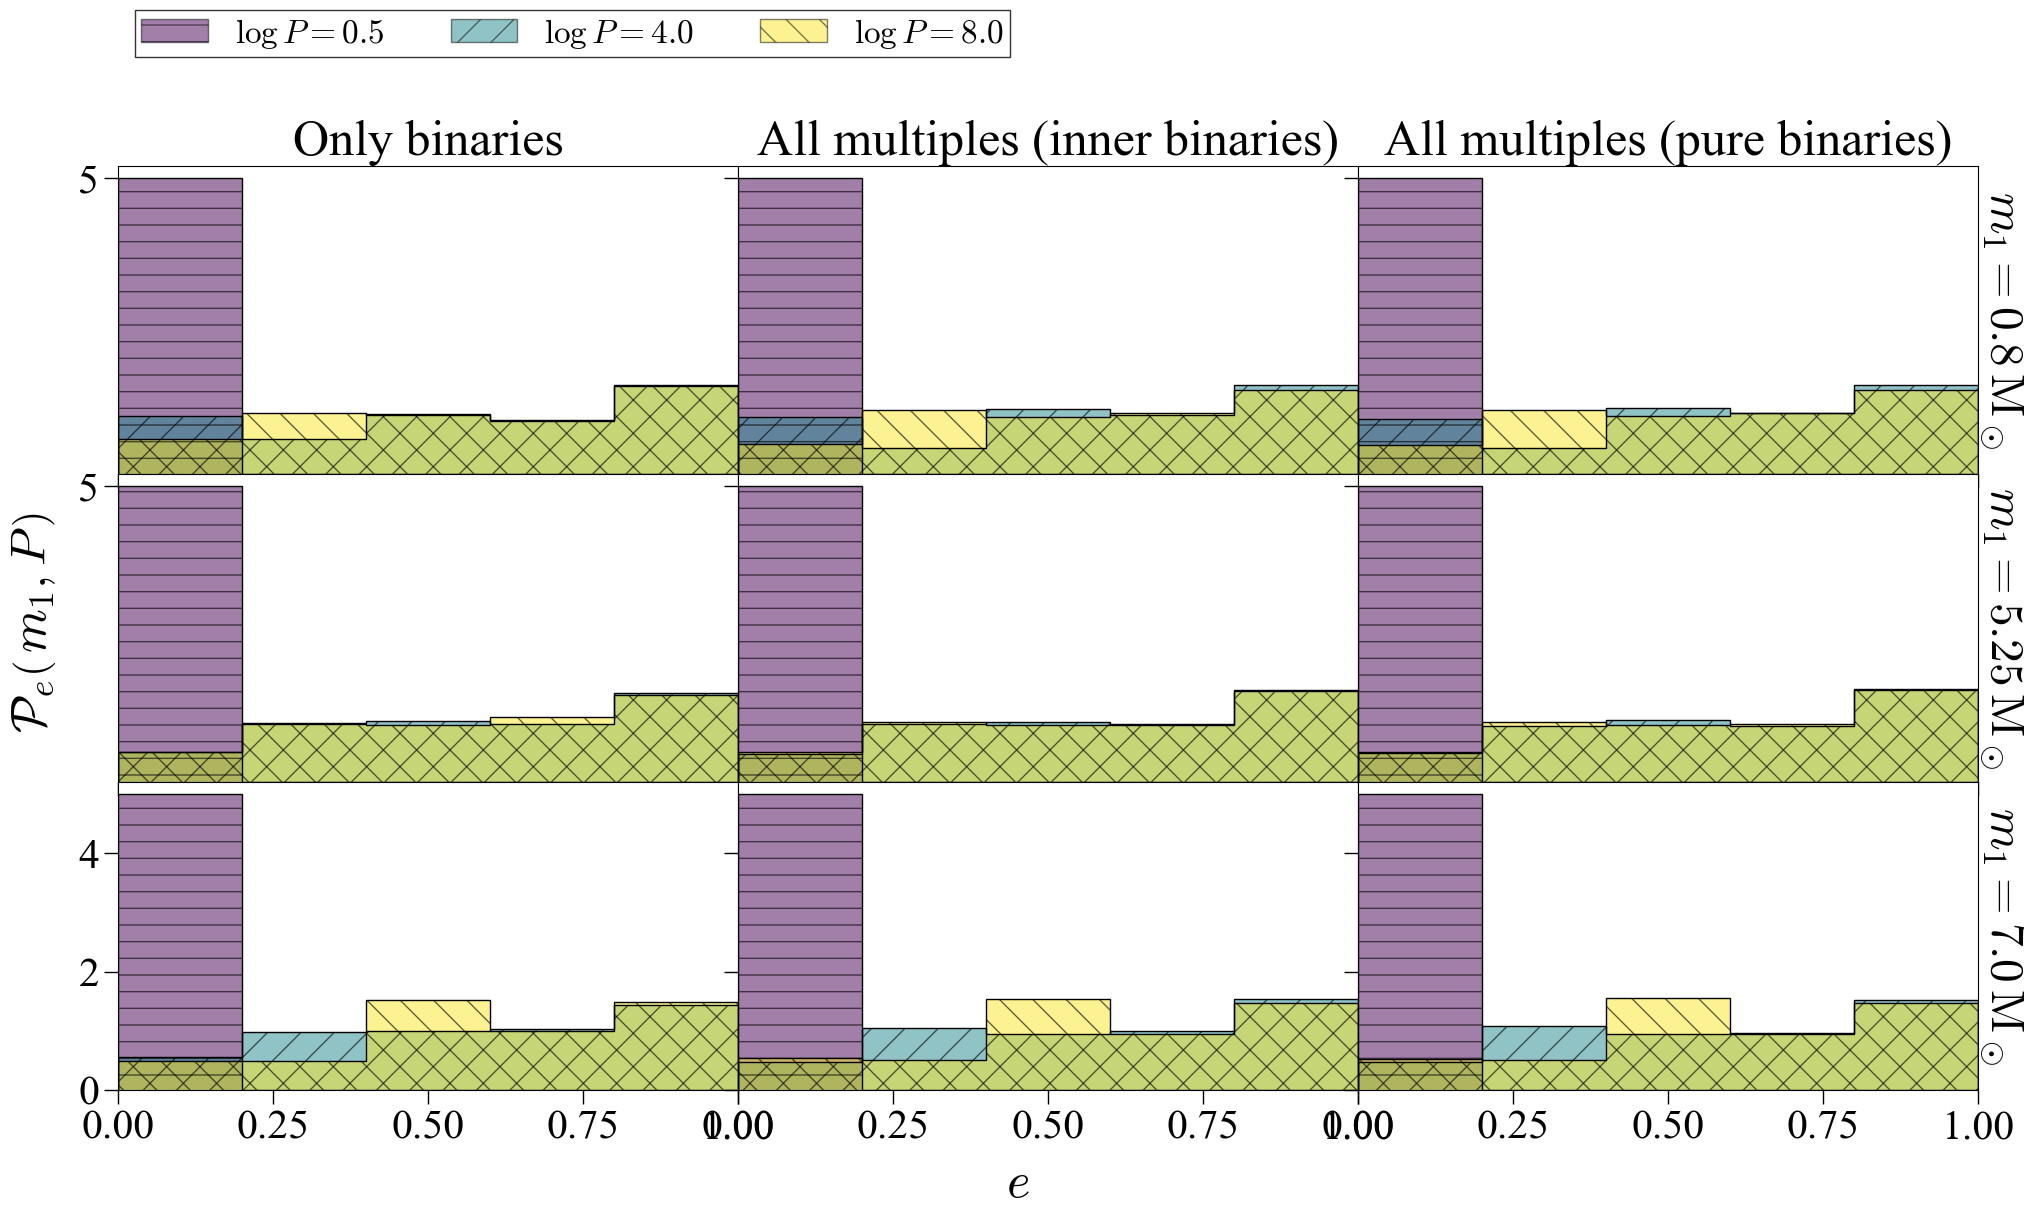

In [87]:
fig, axes = plt.subplots(3, 3, figsize=(24, 12), sharex=True, sharey='row')
fig.subplots_adjust(hspace=0, wspace=0)
rect = fig.patch
rect.set_facecolor('white')
logp_cnorm = plot_logps.max() - plot_logps.min()
hatches = ['-', '/', '\\']

### BINARIES ONLY ###
for i_m1, m1 in enumerate(plot_m1s):
    for logp, e_hs, hatch in zip(plot_logps, onlybin_e_hs[i_m1], hatches):
        c = cm.viridis((logp-plot_logps.min())/logp_cnorm)
        #axes[i_m1, 0].plot(e_centers, e_hs, c=c)
        axes[i_m1, 0].stairs(e_hs, e_bins, facecolor=c, edgecolor='k', fill=True, alpha=0.5)
        axes[i_m1, 0].stairs(e_hs, e_bins, facecolor='none', edgecolor='k', alpha=1, fill=False, zorder=3)
        axes[i_m1, 0].stairs(e_hs, e_bins, facecolor='none', edgecolor='k', alpha=0.6, fill=True, zorder=3, hatch=hatch)
        
for i_m1, m1 in enumerate(plot_m1s):
    for logp, e_hs in zip(plot_logps, onlybin_canon_e_hs[i_m1]):
        c = cm.viridis((logp-plot_logps.min())/logp_cnorm)
        
        #axes[i_m1, 0].plot(canon_e_centers, e_hs, c=c, ls='--')
        
### ALL MULTIPLES INNER BINARIES ####
for i_m1, m1 in enumerate(plot_m1s):
    for logp, e_hs, hatch in zip(plot_logps, allmult_e_hs[i_m1], hatches):
        c = cm.viridis((logp-plot_logps.min())/logp_cnorm)
        #axes[i_m1, 1].plot(e_centers, e_hs, c=c)
        axes[i_m1, 1].stairs(e_hs, e_bins, facecolor=c, edgecolor='k', fill=True, alpha=0.5)
        axes[i_m1, 1].stairs(e_hs, e_bins, facecolor='none', edgecolor='k', alpha=1, fill=False, zorder=3)
        axes[i_m1, 1].stairs(e_hs, e_bins, facecolor='none', edgecolor='k', alpha=0.6, fill=True, zorder=3, hatch=hatch)
        
for i_m1, m1 in enumerate(plot_m1s):
    for logp, e_hs in zip(plot_logps, allmult_canon_e_hs[i_m1]):
        c = cm.viridis((logp-plot_logps.min())/logp_cnorm)
        #axes[i_m1, 1].plot(e_centers, e_hs, c=c, ls='--')
        
### ALL MULTIPLES PURE BINARIES ####
for i_m1, m1 in enumerate(plot_m1s):
    for logp, e_hs, hatch in zip(plot_logps, allmult_pure_e_hs[i_m1], hatches):
        c = cm.viridis((logp-plot_logps.min())/logp_cnorm)
        #axes[i_m1, 2].plot(e_centers, e_hs, c=c)
        axes[i_m1, 2].stairs(e_hs, e_bins, facecolor=c, edgecolor='k', fill=True, alpha=0.5)
        axes[i_m1, 2].stairs(e_hs, e_bins, facecolor='none', edgecolor='k', alpha=1, fill=False, zorder=3)
        axes[i_m1, 2].stairs(e_hs, e_bins, facecolor='none', edgecolor='k', alpha=0.6, fill=True, zorder=3, hatch=hatch)
        #if i_m1 == 0:
            #axes[i_m1, 2].stairs(e_hs, e_bins, facecolor=c, edgecolor='k', alpha=0, fill=True, zorder=3, hatch=hatch, label=f'$\log P = {logp}$')
        
for i_m1, m1 in enumerate(plot_m1s):
    for logp, e_hs in zip(plot_logps, allmult_canon_pure_e_hs[i_m1]):
        c = cm.viridis((logp-plot_logps.min())/logp_cnorm)
        #axes[i_m1, 2].plot(e_centers, e_hs, c=c, ls='--')
        
### DETAILS ###
for ax in axes.flatten():
    ax.set_xlim(0, 1)
    ax.set_ylim(0)
    ax.tick_params(labelsize=30)
    
fig.text(0.5, 0.05, '$e$', va='top', ha='center', transform=fig.transFigure, fontsize=36)
fig.text(0.1, 0.5, r'$\mathcal{P}_e\left(\,m_1,P\,\right)$', rotation=90, va='center', ha='right', transform=fig.transFigure, fontsize=36)

fig.text(0.5, 1, 'Only binaries', ha='center', va='bottom', fontsize=36, transform=axes[0,0].transAxes)
fig.text(0.5, 1, 'All multiples (inner binaries)', ha='center', va='bottom', fontsize=36, transform=axes[0,1].transAxes)
fig.text(0.5, 1, 'All multiples (pure binaries)', ha='center', va='bottom', fontsize=36, transform=axes[0,2].transAxes)

fig.text(1.0, 0.5, f'$m_1={plot_m1s[0]}\,\mathrm{{M}}_\odot$', ha='left', va='center', rotation=-90, fontsize=34, transform=axes[0,2].transAxes)
fig.text(1.0, 0.5, f'$m_1={plot_m1s[1]}\,\mathrm{{M}}_\odot$', ha='left', va='center', rotation=-90, fontsize=34, transform=axes[1,2].transAxes)
fig.text(1.0, 0.5, f'$m_1={plot_m1s[2]}\,\mathrm{{M}}_\odot$', ha='left', va='center', rotation=-90, fontsize=34, transform=axes[2,2].transAxes)

### LEGEND ###
handles = []
for logp, hatch in zip(plot_logps, hatches):
    c = cm.viridis((logp-plot_logps.min())/logp_cnorm)
    #handle = Line2D([0], [0], label=f'$\log P = {logp}$', color=c, linestyle='-')
    handle = Patch(edgecolor='black', facecolor=c, hatch=hatch, alpha=0.5, label=f'$\log P = {logp}$')
    handles.append(handle)
#handle = Patch(edgecolor='black', facecolor=intersec_c, hatch='x', alpha=0.8, label=f'Mix')    
#handles.append(handle)
axes[0,0].legend(handles=handles, frameon=True, loc='lower left', bbox_to_anchor=(0,1.3), ncol=3, edgecolor='black', fancybox=False, borderpad=0.2, fontsize=24)

axes[2,0].set_ylim(0,5.2)
axes[1,0].set_yticks([5,10])
axes[1,0].set_ylim(0,5.2)
axes[0,0].set_yticks([5,10])
axes[0,0].set_ylim(0,5.2)

#fig.savefig(FIGURE_FOLDER/'e_sample_muliplicity_1e6.pdf', bbox_inches='tight')
#fig.savefig(FIGURE_FOLDER/'e_sample_muliplicity_1e6.png', bbox_inches='tight')


### $\log P$ sampĺes

In [88]:
plot_m1s = np.array([1, 10, 30, 100, 150])
#plot_logps = np.array([1, 4, 8])

In [89]:
logp_bins = np.linspace(0.2, 8, 16)
logp_widths = np.array([(logp1-logp0) for logp0, logp1 in zip(logp_bins[:-1], logp_bins[1:])])
logp_centers = np.array([(logp1+logp0)/2 for logp0, logp1 in zip(logp_bins[:-1], logp_bins[1:])])

In [90]:
df = onlybin_df
logp_hs = []

unique_m1s = np.sort(np.unique(df.m1.to_numpy()))
for m1 in plot_m1s:
    closest_m1_i = np.argmin(np.abs(unique_m1s- m1))
    closest_m1 = unique_m1s[closest_m1_i]
    closest_m1s.append(closest_m1)
    subdf = df[df.m1 == closest_m1]
    subdf = subdf[subdf.ncp >= 1]
    logps = np.sort(subdf.logp.to_numpy())
    logp_hs_ , _ = np.histogram(logps, bins=logp_bins, density=True)
    logp_hs.append(logp_hs_)
        
onlybin_logp_hs = logp_hs

In [91]:
df = allmult_df
logp_hs = []

unique_m1s = np.sort(np.unique(df.m1.to_numpy()))
for m1 in plot_m1s:
    closest_m1_i = np.argmin(np.abs(unique_m1s- m1))
    closest_m1 = unique_m1s[closest_m1_i]
    closest_m1s.append(closest_m1)
    subdf = df[df.m1 == closest_m1]
    subdf = subdf[subdf.ncp >= 1]
    logps = np.sort(subdf.logp.to_numpy())
    logp_hs_ , _ = np.histogram(logps, bins=logp_bins, density=True)
    logp_hs.append(logp_hs_)
        
allmult_logp_hs = logp_hs

In [92]:
df = onlybin_canon_df
logp_hs = []

unique_m1s = np.sort(np.unique(df.m1.to_numpy()))
for m1 in plot_m1s:
    closest_m1_i = np.argmin(np.abs(unique_m1s- m1))
    closest_m1 = unique_m1s[closest_m1_i]
    closest_m1s.append(closest_m1)
    subdf = df[df.m1 == closest_m1]
    subdf = subdf[subdf.ncp >= 1]
    logps = np.sort(subdf.logp.to_numpy())
    logp_hs_ , _ = np.histogram(logps, bins=logp_bins, density=True)
    logp_hs.append(logp_hs_)
        
onlybin_canon_logp_hs = logp_hs

In [93]:
df = allmult_df
logp_hs = []

unique_m1s = np.sort(np.unique(df.m1.to_numpy()))
for m1 in plot_m1s:
    closest_m1_i = np.argmin(np.abs(unique_m1s- m1))
    closest_m1 = unique_m1s[closest_m1_i]
    closest_m1s.append(closest_m1)
    subdf = df[df.m1 == closest_m1]
    subdf = subdf[subdf.ncp == 1]
    logps = np.sort(subdf.logp.to_numpy())
    logp_hs_ , _ = np.histogram(logps, bins=logp_bins, density=True)
    logp_hs.append(logp_hs_)
        
allmult_pure_logp_hs = logp_hs

<>:11: SyntaxWarning: invalid escape sequence '\,'
<>:11: SyntaxWarning: invalid escape sequence '\o'
<>:11: SyntaxWarning: invalid escape sequence '\,'
<>:11: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_697613/1470000848.py:11: SyntaxWarning: invalid escape sequence '\,'
  axes[0].plot(logp_centers, logp_hs, c=c, label=f'$m_1={m1:.1f}\,\mathrm{{M}}_\odot$', lw=3)
/tmp/ipykernel_697613/1470000848.py:11: SyntaxWarning: invalid escape sequence '\o'
  axes[0].plot(logp_centers, logp_hs, c=c, label=f'$m_1={m1:.1f}\,\mathrm{{M}}_\odot$', lw=3)


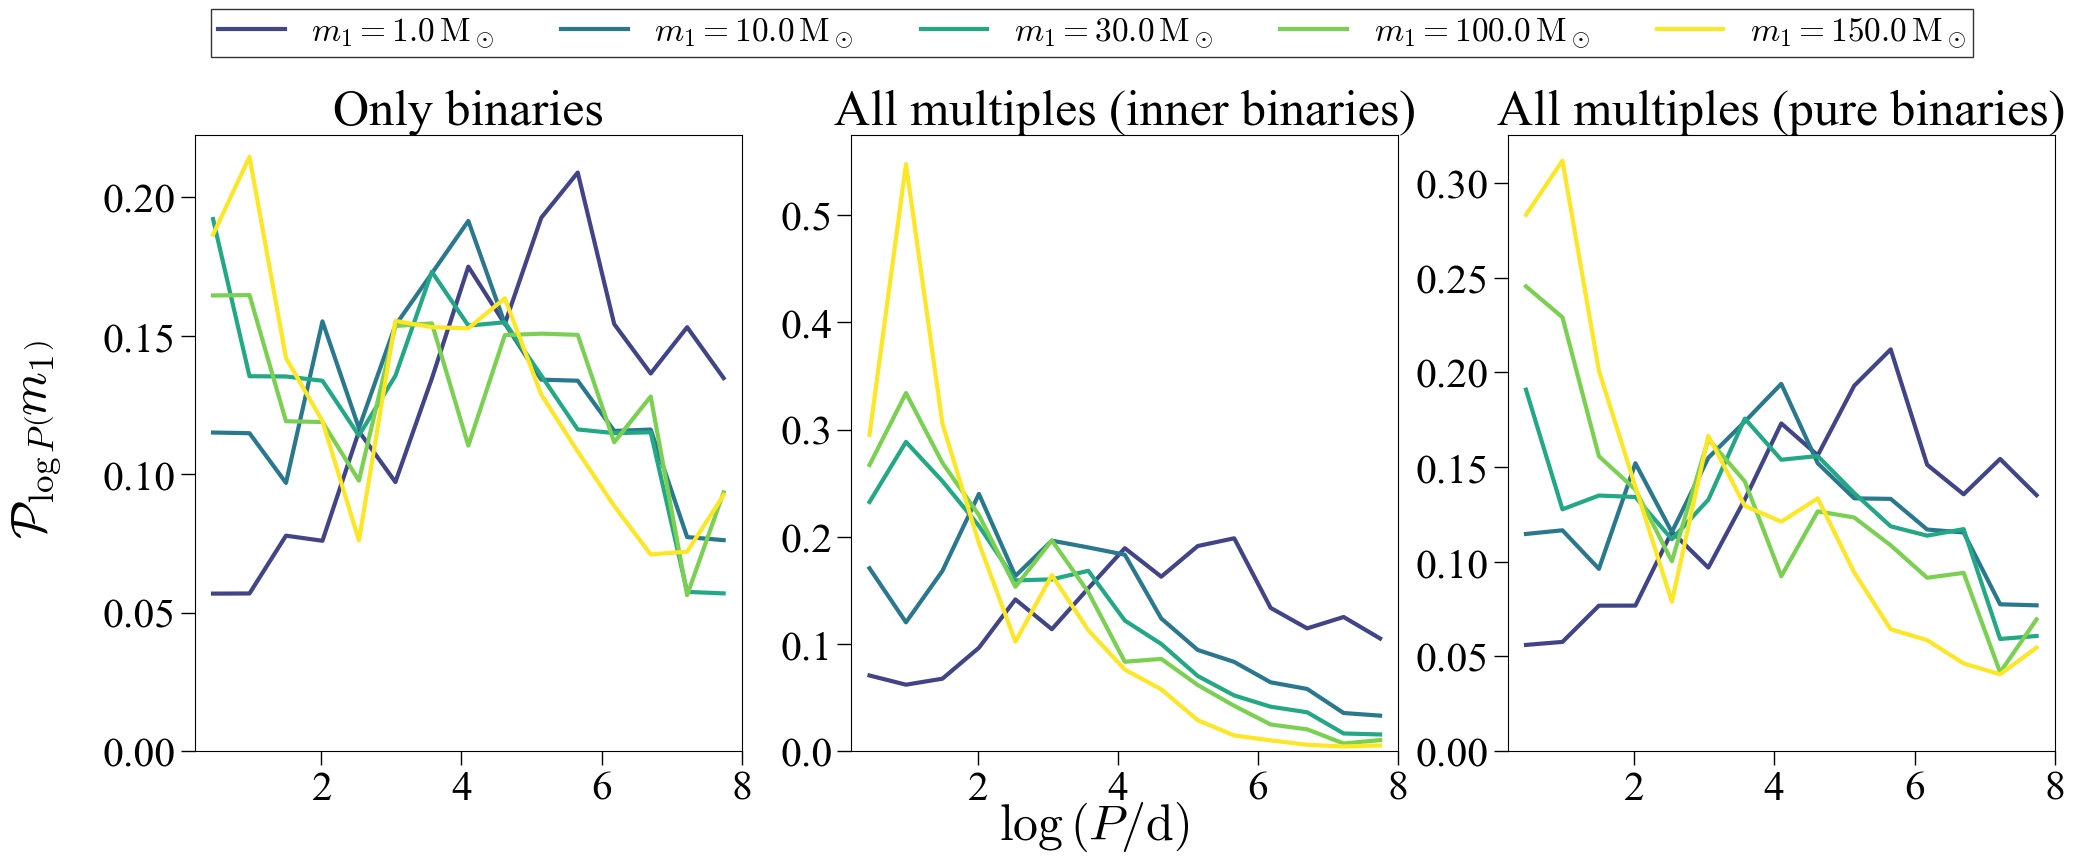

In [94]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=False)
fig.subplots_adjust(hspace=0, wspace=0.2)
rect = fig.patch
rect.set_facecolor('white')
m1_cnorm = plot_m1s.max() - plot_m1s.min()

### BINARIES ONLY ###
hs = onlybin_logp_hs
for i, (m1, logp_hs) in enumerate(zip(plot_m1s, hs)):
    c = cm.viridis((i+1)/len(plot_m1s))
    axes[0].plot(logp_centers, logp_hs, c=c, label=f'$m_1={m1:.1f}\,\mathrm{{M}}_\odot$', lw=3)
    #xes[0].stairs(logp_hs, logp_bins, color=c, edgecolor='none', fill=True, alpha=0.3, label=f'$m_1={m1:.0f}\,\mathrm{{M}}_\odot$')
    #xes[0].stairs(logp_hs, logp_bins, color='none', edgecolor=c, fill=False, alpha=1, lw=3, zorder=3)
    
#hs = onlybin_canon_logp_hs
#for i, (m1, logp_hs) in enumerate(zip(plot_m1s, hs)):
    #c = cm.viridis((i+1)/len(plot_m1s))
#    axes[0].plot(logp_centers, logp_hs, c=c, ls='--')
        
        
### ALL MULTIPLES INNER BINARIES ####
hs = allmult_logp_hs
for i, (m1, logp_hs) in enumerate(zip(plot_m1s, hs)):
    c = cm.viridis((i+1)/len(plot_m1s))
    axes[1].plot(logp_centers, logp_hs, c=c, lw=3)
    #axes[1].stairs(logp_hs, logp_bins, color=c, edgecolor='none', fill=True, alpha=0.3)
    #xes[1].stairs(logp_hs, logp_bins, color='none', edgecolor=c, lw=3, fill=False, alpha=1, zorder=3)
    
#hs = allmult_canon_logp_hs
#for i, (m1, logp_hs) in enumerate(zip(plot_m1s, hs)):
#    c = cm.viridis((i+1)/len(plot_m1s))
#    axes[1].plot(logp_centers, logp_hs, c=c)
    
### ALL MULTIPLES PURE BINARIES ####
hs = allmult_pure_logp_hs
for i, (m1, logp_hs) in enumerate(zip(plot_m1s, hs)):
    c = cm.viridis((i+1)/len(plot_m1s))
    axes[2].plot(logp_centers, logp_hs, c=c, lw=3)
    #axes[2].stairs(logp_hs, logp_bins, color=c, edgecolor='none', fill=True, alpha=0.3)
    #axes[2].stairs(logp_hs, logp_bins, color='none', edgecolor=c, lw=3, fill=False, alpha=1, zorder=3)
    
#hs = allmult_canon_pure_logp_hs
#for i, (m1, logp_hs) in enumerate(zip(plot_m1s, hs)):
#    c = cm.viridis((i+1)/len(plot_m1s))
#    axes[2].plot(logp_centers, logp_hs, c=c)

### DETAILS ###
for ax in axes.flatten():
    ax.set_xlim(0.2, 8)
    ax.set_ylim(0)
    ax.tick_params(labelsize=30)
    
fig.text(0.5, 0.05, r'$\log\left(P/\mathrm{d}\right)$', va='top', ha='center', transform=fig.transFigure, fontsize=36)
fig.text(0.07, 0.5, r'$\mathcal{P}_{\log P}\left(m_1\right)$', rotation=90, va='center', ha='right', transform=fig.transFigure, fontsize=36)

fig.text(0.5, 1, 'Only binaries', ha='center', va='bottom', fontsize=36, transform=axes[0].transAxes)
fig.text(0.5, 1, 'All multiples (inner binaries)', ha='center', va='bottom', fontsize=36, transform=axes[1].transAxes)
fig.text(0.5, 1, 'All multiples (pure binaries)', ha='center', va='bottom', fontsize=36, transform=axes[2].transAxes)


### LEGEND ###
#handles = []
#for logp in plot_logps:
    #c = cm.viridis((logp-plot_logps.min())/logp_cnorm)
    #handle = Line2D([0], [0], label=f'$\log P = {logp}$', color=c, linestyle='-')
    #handles.append(handle)
axes[0].legend(frameon=True, loc='lower left', bbox_to_anchor=(0,1.1), ncol=5, edgecolor='black', fancybox=False, borderpad=0.2, fontsize=24)

#fig.savefig(FIGURE_FOLDER/'logp_sample_muliplicity_1e6.pdf', bbox_inches='tight')
#fig.savefig(FIGURE_FOLDER/'logp_sample_muliplicity_1e6.png', bbox_inches='tight')

Figure 16

<>:13: SyntaxWarning: invalid escape sequence '\,'
<>:13: SyntaxWarning: invalid escape sequence '\o'
<>:13: SyntaxWarning: invalid escape sequence '\,'
<>:13: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_697613/1825891984.py:13: SyntaxWarning: invalid escape sequence '\,'
  axes[0].stairs(logp_hs, logp_bins, color='none', edgecolor=c, fill=False, alpha=1, lw=3, zorder=3, label=f'$m_1={m1:.0f}\,\mathrm{{M}}_\odot$')
/tmp/ipykernel_697613/1825891984.py:13: SyntaxWarning: invalid escape sequence '\o'
  axes[0].stairs(logp_hs, logp_bins, color='none', edgecolor=c, fill=False, alpha=1, lw=3, zorder=3, label=f'$m_1={m1:.0f}\,\mathrm{{M}}_\odot$')


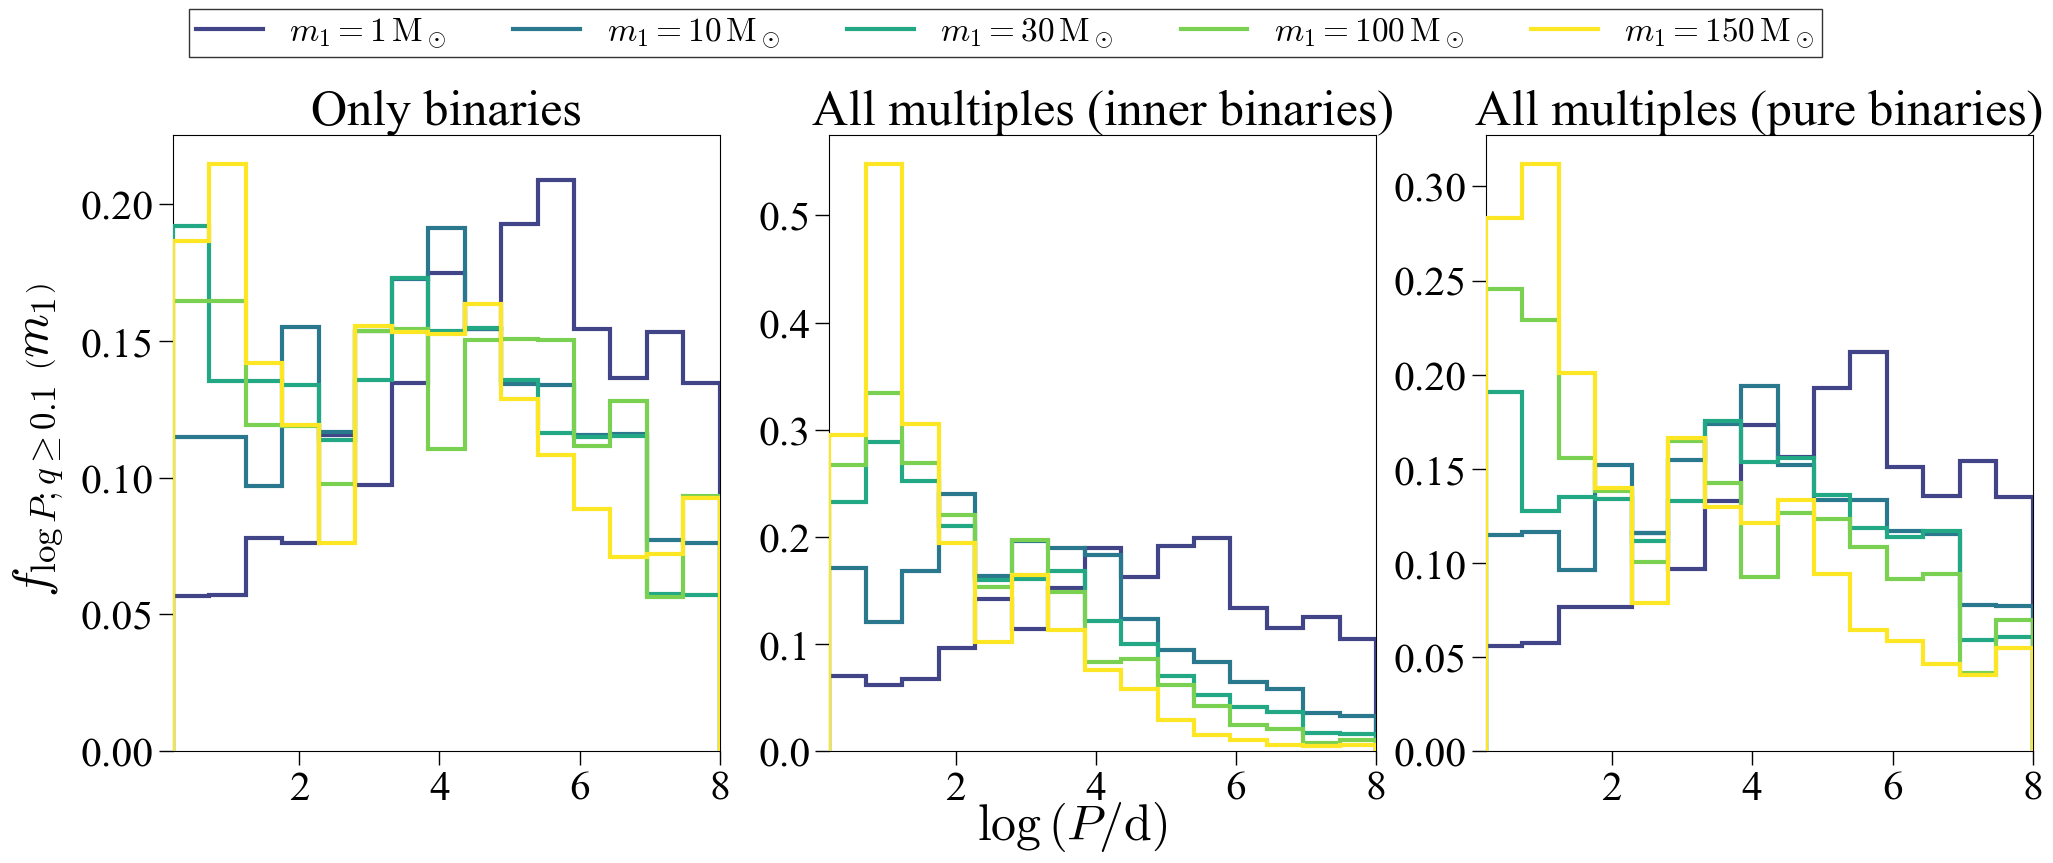

In [95]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=False)
fig.subplots_adjust(hspace=0, wspace=0.2)
rect = fig.patch
rect.set_facecolor('white')
m1_cnorm = plot_m1s.max() - plot_m1s.min()

### BINARIES ONLY ###
hs = onlybin_logp_hs
for i, (m1, logp_hs) in enumerate(zip(plot_m1s, hs)):
    c = cm.viridis((i+1)/len(plot_m1s))
    #axes[0].plot(logp_centers, logp_hs, c=c, label=f'$m_1={m1:.1f}\,\mathrm{{M}}_\odot$')
    #axes[0].stairs(logp_hs, logp_bins, color=c, edgecolor='none', fill=True, alpha=0.3, label=f'$m_1={m1:.0f}\,\mathrm{{M}}_\odot$')
    axes[0].stairs(logp_hs, logp_bins, color='none', edgecolor=c, fill=False, alpha=1, lw=3, zorder=3, label=f'$m_1={m1:.0f}\,\mathrm{{M}}_\odot$')
    
#hs = onlybin_canon_logp_hs
#for i, (m1, logp_hs) in enumerate(zip(plot_m1s, hs)):
    #c = cm.viridis((i+1)/len(plot_m1s))
#    axes[0].plot(logp_centers, logp_hs, c=c, ls='--')
        
        
### ALL MULTIPLES INNER BINARIES ####
hs = allmult_logp_hs
for i, (m1, logp_hs) in enumerate(zip(plot_m1s, hs)):
    c = cm.viridis((i+1)/len(plot_m1s))
    #axes[1].plot(logp_centers, logp_hs, c=c)
    #axes[1].stairs(logp_hs, logp_bins, color=c, edgecolor='none', fill=True, alpha=0.3)
    axes[1].stairs(logp_hs, logp_bins, color='none', edgecolor=c, lw=3, fill=False, alpha=1, zorder=3)
    
#hs = allmult_canon_logp_hs
#for i, (m1, logp_hs) in enumerate(zip(plot_m1s, hs)):
#    c = cm.viridis((i+1)/len(plot_m1s))
#    axes[1].plot(logp_centers, logp_hs, c=c)
    
### ALL MULTIPLES PURE BINARIES ####
hs = allmult_pure_logp_hs
for i, (m1, logp_hs) in enumerate(zip(plot_m1s, hs)):
    c = cm.viridis((i+1)/len(plot_m1s))
    #axes[2].plot(logp_centers, logp_hs, c=c)
    #axes[2].stairs(logp_hs, logp_bins, color=c, edgecolor='none', fill=True, alpha=0.3)
    axes[2].stairs(logp_hs, logp_bins, color='none', edgecolor=c, lw=3, fill=False, alpha=1, zorder=3)
    
#hs = allmult_canon_pure_logp_hs
#for i, (m1, logp_hs) in enumerate(zip(plot_m1s, hs)):
#    c = cm.viridis((i+1)/len(plot_m1s))
#    axes[2].plot(logp_centers, logp_hs, c=c)

### DETAILS ###
for ax in axes.flatten():
    ax.set_xlim(0.2, 8)
    ax.tick_params(labelsize=30)
    
fig.text(0.5, 0.05, r'$\log\left(P/\mathrm{d}\right)$', va='top', ha='center', transform=fig.transFigure, fontsize=36)
fig.text(0.08, 0.5, r'$f_{\log P;q\geq0.1}\;\left(m_1\right)$', rotation=90, va='center', ha='right', transform=fig.transFigure, fontsize=36)

fig.text(0.5, 1, 'Only binaries', ha='center', va='bottom', fontsize=36, transform=axes[0].transAxes)
fig.text(0.5, 1, 'All multiples (inner binaries)', ha='center', va='bottom', fontsize=36, transform=axes[1].transAxes)
fig.text(0.5, 1, 'All multiples (pure binaries)', ha='center', va='bottom', fontsize=36, transform=axes[2].transAxes)


### LEGEND ###
#handles = []
#for logp in plot_logps:
    #c = cm.viridis((logp-plot_logps.min())/logp_cnorm)
    #handle = Line2D([0], [0], label=f'$\log P = {logp}$', color=c, linestyle='-')
    #handles.append(handle)
axes[0].legend(frameon=True, loc='lower left', bbox_to_anchor=(0,1.1), ncol=5, edgecolor='black', fancybox=False, borderpad=0.2, fontsize=24)

fig.savefig(FIGURE_FOLDER/'logp_sample_muliplicity_1e6.pdf', bbox_inches='tight')
fig.savefig(FIGURE_FOLDER/'logp_sample_muliplicity_1e6.png', bbox_inches='tight')

<>:12: SyntaxWarning: invalid escape sequence '\,'
<>:12: SyntaxWarning: invalid escape sequence '\o'
<>:12: SyntaxWarning: invalid escape sequence '\,'
<>:12: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_697613/1697638225.py:12: SyntaxWarning: invalid escape sequence '\,'
  axes[0].stairs(logp_hs, logp_bins, color=c, edgecolor='none', fill=True, alpha=0.3, label=f'$m_1={m1:.0f}\,\mathrm{{M}}_\odot$')
/tmp/ipykernel_697613/1697638225.py:12: SyntaxWarning: invalid escape sequence '\o'
  axes[0].stairs(logp_hs, logp_bins, color=c, edgecolor='none', fill=True, alpha=0.3, label=f'$m_1={m1:.0f}\,\mathrm{{M}}_\odot$')


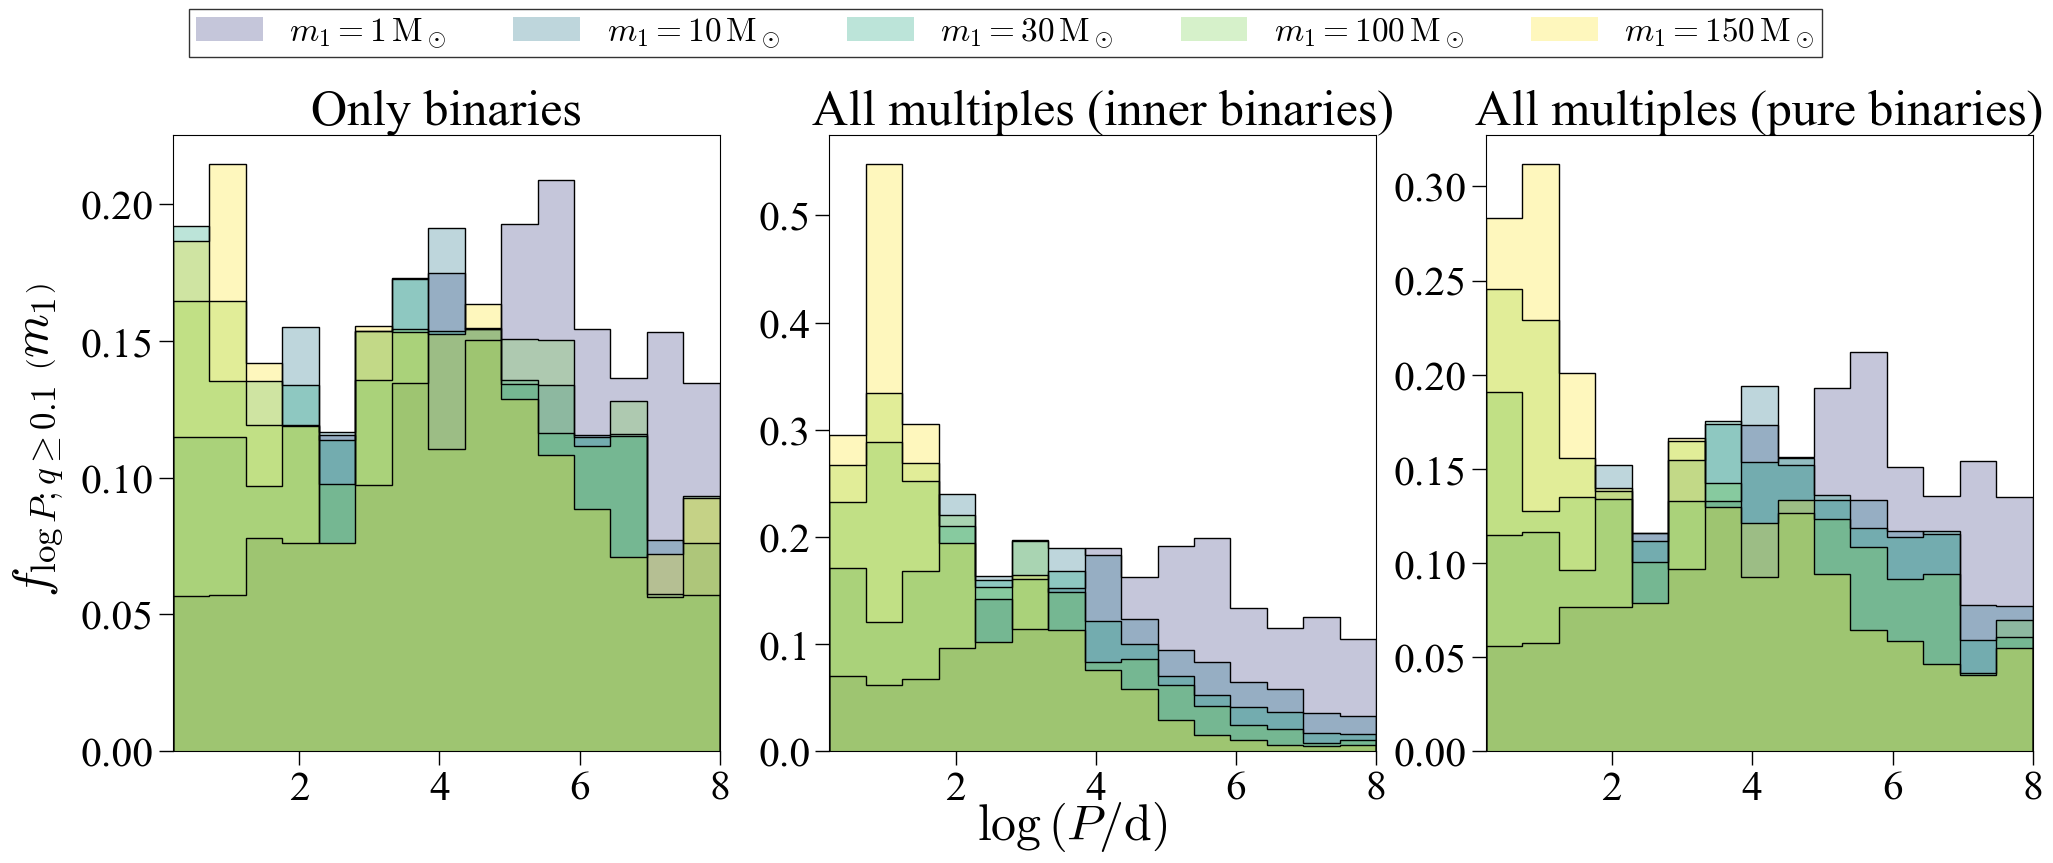

In [96]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=False)
fig.subplots_adjust(hspace=0, wspace=0.2)
rect = fig.patch
rect.set_facecolor('white')
m1_cnorm = plot_m1s.max() - plot_m1s.min()

### BINARIES ONLY ###
hs = onlybin_logp_hs
for i, (m1, logp_hs) in enumerate(zip(plot_m1s, hs)):
    c = cm.viridis((i+1)/len(plot_m1s))
    #axes[0].plot(logp_centers, logp_hs, c=c, label=f'$m_1={m1:.1f}\,\mathrm{{M}}_\odot$')
    axes[0].stairs(logp_hs, logp_bins, color=c, edgecolor='none', fill=True, alpha=0.3, label=f'$m_1={m1:.0f}\,\mathrm{{M}}_\odot$')
    axes[0].stairs(logp_hs, logp_bins, color='none', edgecolor='k', fill=False, alpha=1, zorder=3)
    
#hs = onlybin_canon_logp_hs
#for i, (m1, logp_hs) in enumerate(zip(plot_m1s, hs)):
    #c = cm.viridis((i+1)/len(plot_m1s))
#    axes[0].plot(logp_centers, logp_hs, c=c, ls='--')
        
        
### ALL MULTIPLES INNER BINARIES ####
hs = allmult_logp_hs
for i, (m1, logp_hs) in enumerate(zip(plot_m1s, hs)):
    c = cm.viridis((i+1)/len(plot_m1s))
    #axes[1].plot(logp_centers, logp_hs, c=c)
    axes[1].stairs(logp_hs, logp_bins, color=c, edgecolor='none', fill=True, alpha=0.3)
    axes[1].stairs(logp_hs, logp_bins, color='none', edgecolor='k', fill=False, alpha=1, zorder=3)
    
#hs = allmult_canon_logp_hs
#for i, (m1, logp_hs) in enumerate(zip(plot_m1s, hs)):
#    c = cm.viridis((i+1)/len(plot_m1s))
#    axes[1].plot(logp_centers, logp_hs, c=c)
    
### ALL MULTIPLES PURE BINARIES ####
hs = allmult_pure_logp_hs
for i, (m1, logp_hs) in enumerate(zip(plot_m1s, hs)):
    c = cm.viridis((i+1)/len(plot_m1s))
    #axes[2].plot(logp_centers, logp_hs, c=c)
    axes[2].stairs(logp_hs, logp_bins, color=c, edgecolor='none', fill=True, alpha=0.3)
    axes[2].stairs(logp_hs, logp_bins, color='none', edgecolor='k', fill=False, alpha=1, zorder=3)
    
#hs = allmult_canon_pure_logp_hs
#for i, (m1, logp_hs) in enumerate(zip(plot_m1s, hs)):
#    c = cm.viridis((i+1)/len(plot_m1s))
#    axes[2].plot(logp_centers, logp_hs, c=c)

### DETAILS ###
for ax in axes.flatten():
    ax.set_xlim(0.2, 8)
    ax.tick_params(labelsize=30)
    
fig.text(0.5, 0.05, r'$\log\left(P/\mathrm{d}\right)$', va='top', ha='center', transform=fig.transFigure, fontsize=36)
fig.text(0.08, 0.5, r'$f_{\log P;q\geq0.1}\;\left(m_1\right)$', rotation=90, va='center', ha='right', transform=fig.transFigure, fontsize=36)

fig.text(0.5, 1, 'Only binaries', ha='center', va='bottom', fontsize=36, transform=axes[0].transAxes)
fig.text(0.5, 1, 'All multiples (inner binaries)', ha='center', va='bottom', fontsize=36, transform=axes[1].transAxes)
fig.text(0.5, 1, 'All multiples (pure binaries)', ha='center', va='bottom', fontsize=36, transform=axes[2].transAxes)


### LEGEND ###
#handles = []
#for logp in plot_logps:
    #c = cm.viridis((logp-plot_logps.min())/logp_cnorm)
    #handle = Line2D([0], [0], label=f'$\log P = {logp}$', color=c, linestyle='-')
    #handles.append(handle)
axes[0].legend(frameon=True, loc='lower left', bbox_to_anchor=(0,1.1), ncol=5, edgecolor='black', fancybox=False, borderpad=0.2, fontsize=24)

#fig.savefig(FIGURE_FOLDER/'logp_sample_muliplicity_1e6.pdf', bbox_inches='tight')
#fig.savefig(FIGURE_FOLDER/'logp_sample_muliplicity_1e6.png', bbox_inches='tight')

## Multiplicity evolution

In [97]:
only_over_5msun = False

In [98]:
onlybin_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 174039311 entries, 0 to 1362429
Data columns (total 9 columns):
 #   Column    Dtype  
---  ------    -----  
 0   m1        float16
 1   m2        float16
 2   q         float16
 3   logp      float16
 4   e         float16
 5   ncp       float16
 6   msys      float16
 7   Redshift  float16
 8   [Fe/H]    float16
dtypes: float16(9)
memory usage: 4.2 GB


## Onlybin 

In [99]:
sample_df = onlybin_df.copy()
###sample_df = sample_df.dropna().reset_index(drop=True)

In [100]:
if only_over_5msun:
    sample_df = sample_df[sample_df.m1 >= 5]

In [101]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 174039311 entries, 0 to 1362429
Data columns (total 9 columns):
 #   Column    Dtype  
---  ------    -----  
 0   m1        float16
 1   m2        float16
 2   q         float16
 3   logp      float16
 4   e         float16
 5   ncp       float16
 6   msys      float16
 7   Redshift  float16
 8   [Fe/H]    float16
dtypes: float16(9)
memory usage: 4.2 GB


In [102]:
single_df = sample_df[sample_df.ncp == 0].copy()
binary_df = sample_df[sample_df.ncp == 1].copy()
triple_df = sample_df[sample_df.ncp == 2].copy()
quadruple_df = sample_df[sample_df.ncp == 3].copy()
quintuple_df = sample_df[sample_df.ncp == 4].copy()

In [103]:
single_df.reset_index(inplace=True, drop=True)
binary_df.reset_index(inplace=True, drop=True)
triple_df.reset_index(inplace=True, drop=True)
quadruple_df.reset_index(inplace=True, drop=True)
quintuple_df.reset_index(inplace=True, drop=True)

In [104]:
sample_redshifts = np.sort(sample_df.Redshift.unique())

In [105]:
mult_ev = np.zeros((sample_redshifts.shape[0], 4), np.float32)

In [106]:
for i in range(len(mult_ev)):
    mult_ev[i,1] = i

In [107]:
total_ns = np.zeros(sample_redshifts.shape)
total_ms = np.zeros(sample_redshifts.shape)
for i, redshift in enumerate(sample_redshifts):
    subdf = sample_df[sample_df.Redshift == redshift]
    n = len(subdf)
    m = subdf.msys.to_numpy(dtype='float32').sum()
    total_ns[i] = n
    total_ms[i] = m
    del subdf
gc.collect()

61146

In [108]:
from math import isnan

In [109]:
n_fracs = np.zeros((5, sample_redshifts.shape[0]))
m_fracs = np.zeros((5, sample_redshifts.shape[0]))

#### Singles

In [110]:
df = single_df
ncp = 0

In [111]:
for i, redshift in enumerate(sample_redshifts):
    subdf = df[df.Redshift == redshift]
    n = len(subdf)
    m = subdf.msys.to_numpy(dtype='float32').sum()
    n_frac = n/total_ns[i]
    m_frac = m/total_ms[i]
    n_fracs[ncp, i] = n_frac
    m_fracs[ncp, i] = m_frac
    del subdf
gc.collect()

0

#### Binaries

In [112]:
df = binary_df
ncp = 1

In [113]:
for i, redshift in enumerate(sample_redshifts):
    subdf = df[df.Redshift == redshift]
    n = len(subdf)
    m = subdf.msys.to_numpy(dtype='float32').sum()
    n_frac = n/total_ns[i]
    m_frac = m/total_ms[i]
    n_fracs[ncp, i] = n_frac
    m_fracs[ncp, i] = m_frac
    del subdf
gc.collect()

0

#### Triples

In [114]:
df = triple_df
ncp = 2

In [115]:
for i, redshift in enumerate(sample_redshifts):
    subdf = df[df.Redshift == redshift]
    n = len(subdf)
    m = subdf.msys.to_numpy(dtype='float32').sum()
    n_frac = n/total_ns[i]
    m_frac = m/total_ms[i]
    n_fracs[ncp, i] = n_frac
    m_fracs[ncp, i] = m_frac
    del subdf
gc.collect()

0

#### Quadruples

In [116]:
df = quadruple_df
ncp = 3

In [117]:
for i, redshift in enumerate(sample_redshifts):
    subdf = df[df.Redshift == redshift]
    n = len(subdf)
    m = subdf.msys.to_numpy(dtype='float32').sum()
    n_frac = n/total_ns[i]
    m_frac = m/total_ms[i]
    n_fracs[ncp, i] = n_frac
    m_fracs[ncp, i] = m_frac
    del subdf
gc.collect()

0

#### Quintuples

In [118]:
df = quintuple_df
ncp = 4

In [119]:
for i, redshift in enumerate(sample_redshifts):
    subdf = df[df.Redshift == redshift]
    n = len(subdf)
    m = subdf.msys.to_numpy(dtype='float32').sum()
    n_frac = n/total_ns[i]
    m_frac = m/total_ms[i]
    n_fracs[ncp, i] = n_frac
    m_fracs[ncp, i] = m_frac
    del subdf
gc.collect()

0

#### All

In [120]:
label_dict = {0 : 'Singles ($n_\mathrm{cp}=0$)',
             1 : 'Binaries ($n_\mathrm{cp}=1$)',
             2 : 'Triples ($n_\mathrm{cp}=2$)',
             3 : 'Quadruples ($n_\mathrm{cp}=3$)',
             4 : 'Quintuples ($n_\mathrm{cp}=4$)'}

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_697613/21650472.py:1: SyntaxWarning: invalid escape sequence '\m'
  label_dict = {0 : 'Singles ($n_\mathrm{cp}=0$)',
/tmp/ipykernel_697613/21650472.py:2: SyntaxWarning: invalid escape sequence '\m'
  1 : 'Binaries ($n_\mathrm{cp}=1$)',
/tmp/ipykernel_697613/21650472.py:3: SyntaxWarning: invalid escape sequence '\m'
  2 : 'Triples ($n_\mathrm{cp}=2$)',
/tmp/ipykernel_697613/21650472.py:4: SyntaxWarning: invalid escape sequence '\m'
  3 : 'Quadruples ($n_\mathrm{cp}=3$)',
/tmp/ipyke

Text(0.5, 0, '$z_\\mathrm{ZAMS}$')

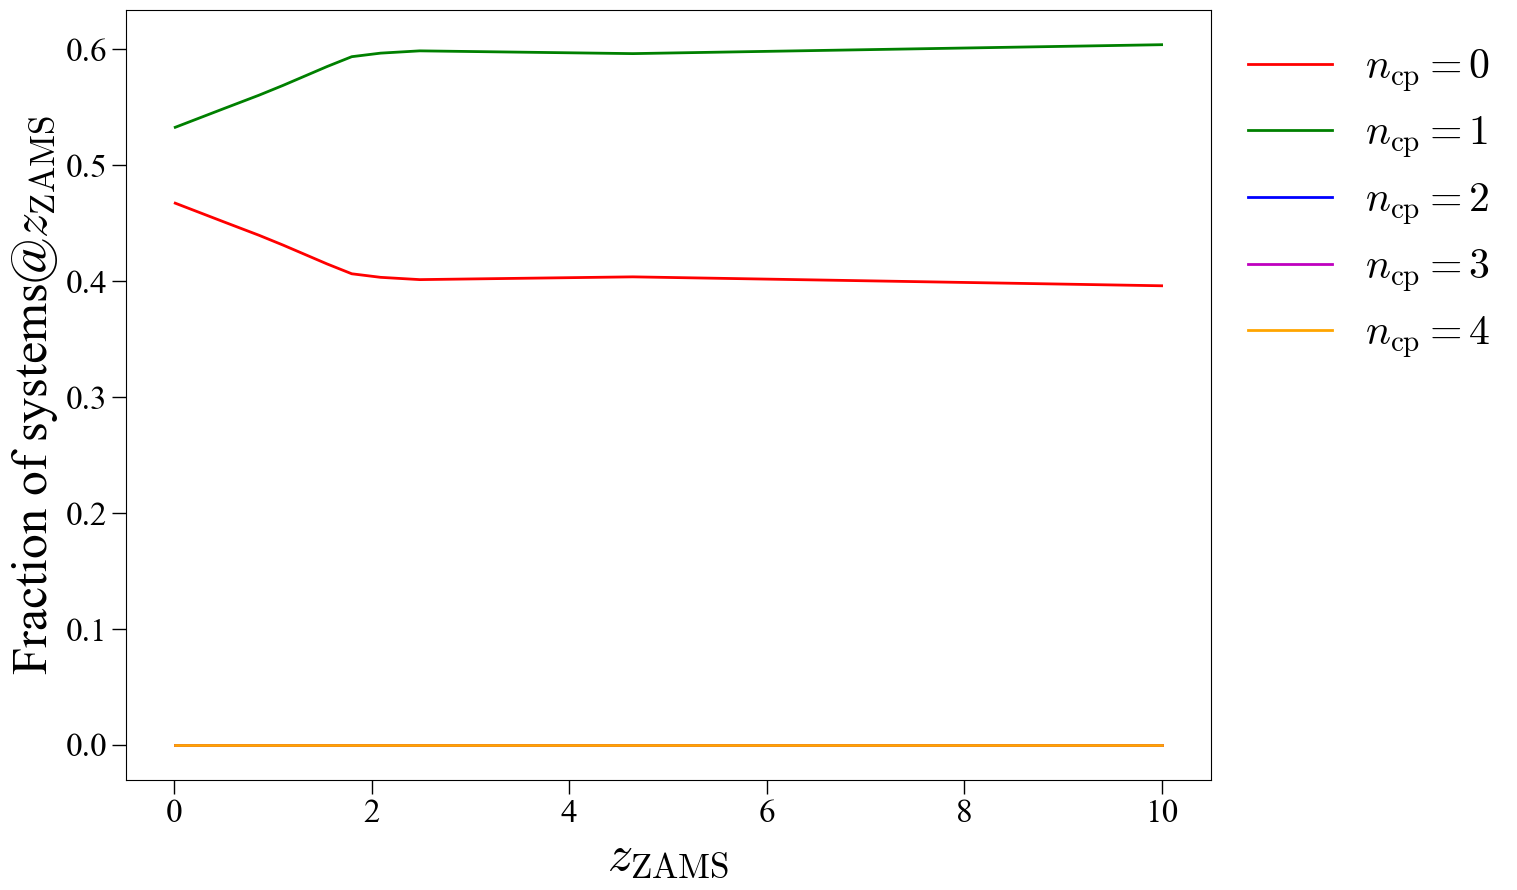

In [121]:
fig, ax = plt.subplots(figsize=(14, 10))
#colors = [(z-plot_redshifts.min())/(plot_redshifts.max()-plot_redshifts.min()) for z in plot_redshifts]
#colors = [cmap(c) for c in colors]
colors = ['r', 'g', 'b', 'm', 'orange']

for ncp, n_frac_arr in enumerate(n_fracs):
    c = colors[ncp]
    ax.plot(sample_redshifts, n_frac_arr, c=c, label=f'$n_\\mathrm{{cp}}={ncp}$')
    
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))
    
ax.set_ylabel('Fraction of systems@$z_\\mathrm{ZAMS}$')
ax.set_xlabel('$z_\\mathrm{ZAMS}$')

<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_697613/698455930.py:8: SyntaxWarning: invalid escape sequence '\m'
  ax.plot(sample_redshifts, m_frac_arr, c=c, label=f'$n_\mathrm{{cp}}={ncp}$')


(0.01000213623046875, 10.0)

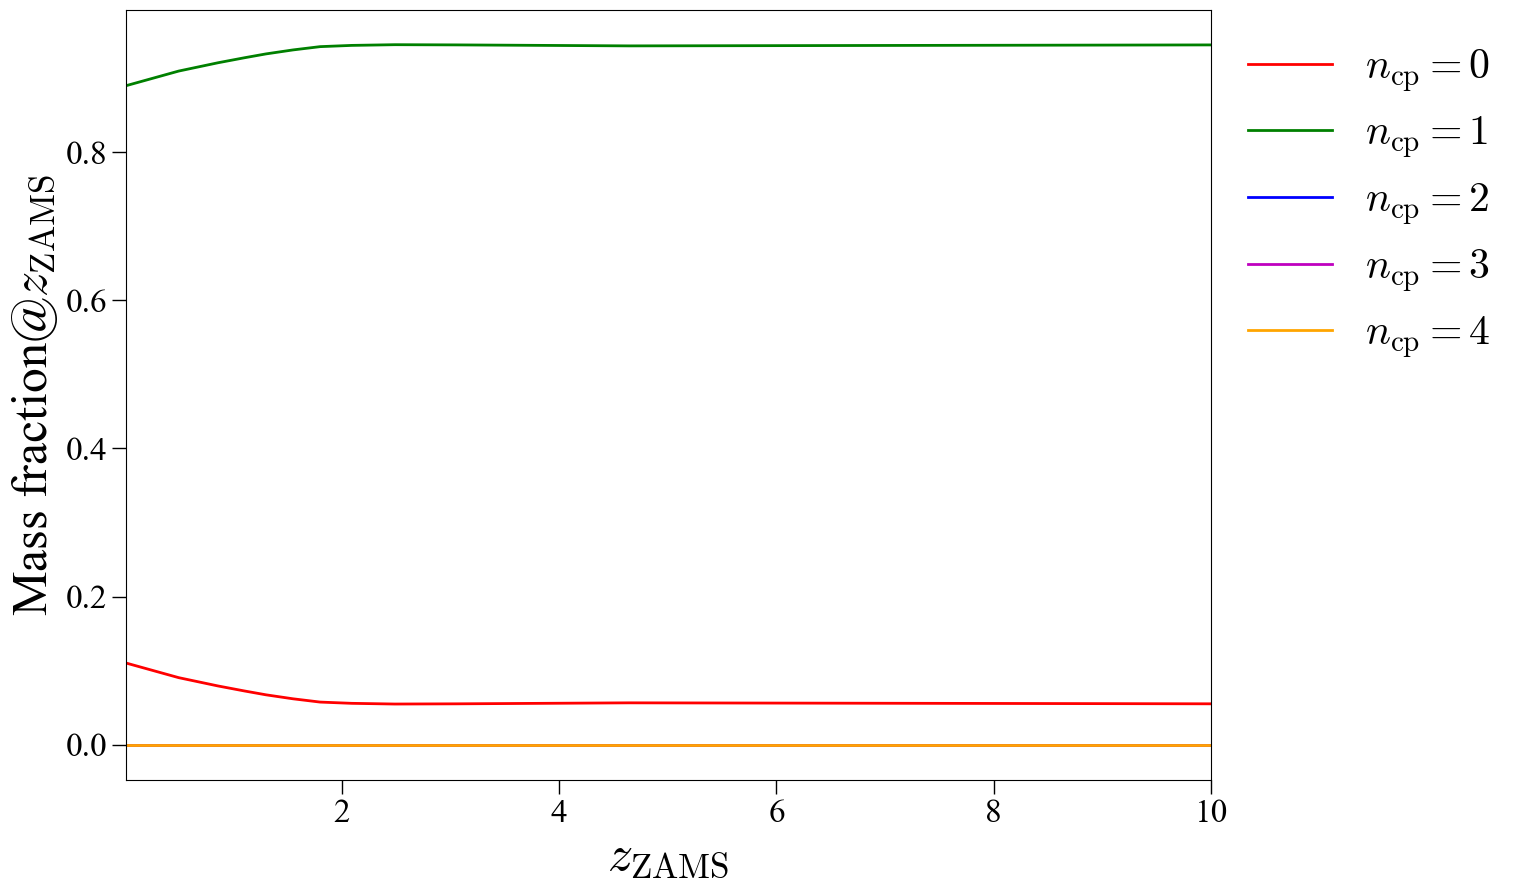

In [122]:
fig, ax = plt.subplots(figsize=(14, 10))
#colors = [(z-plot_redshifts.min())/(plot_redshifts.max()-plot_redshifts.min()) for z in plot_redshifts]
#colors = [cmap(c) for c in colors]
colors = ['r', 'g', 'b', 'm', 'orange']

for ncp, m_frac_arr in enumerate(m_fracs):
    c = colors[ncp]
    ax.plot(sample_redshifts, m_frac_arr, c=c, label=f'$n_\mathrm{{cp}}={ncp}$')
    
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))
    
ax.set_ylabel('Mass fraction@$z_\\mathrm{ZAMS}$')
ax.set_xlabel('$z_\\mathrm{ZAMS}$')
ax.set_xlim(sample_redshifts.min(), sample_redshifts.max())

In [123]:
onlybin_sample_redshifts = sample_redshifts
onlybin_n_fracs = n_fracs
onlybin_m_fracs = m_fracs

## Onlybin canon

In [124]:
sample_df = onlybin_canon_df.copy()
###sample_df = sample_df.dropna().reset_index(drop=True)

In [125]:
if only_over_5msun:
    sample_df = sample_df[sample_df.m1 >= 5]

In [126]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 192692346 entries, 0 to 1605428
Data columns (total 9 columns):
 #   Column    Dtype  
---  ------    -----  
 0   m1        float16
 1   m2        float16
 2   q         float16
 3   logp      float16
 4   e         float16
 5   ncp       float16
 6   msys      float16
 7   Redshift  float16
 8   [Fe/H]    float16
dtypes: float16(9)
memory usage: 4.7 GB


In [127]:
single_df = sample_df[sample_df.ncp == 0].copy()
binary_df = sample_df[sample_df.ncp == 1].copy()
triple_df = sample_df[sample_df.ncp == 2].copy()
quadruple_df = sample_df[sample_df.ncp == 3].copy()
quintuple_df = sample_df[sample_df.ncp == 4].copy()

In [128]:
single_df.reset_index(inplace=True, drop=True)
binary_df.reset_index(inplace=True, drop=True)
triple_df.reset_index(inplace=True, drop=True)
quadruple_df.reset_index(inplace=True, drop=True)
quintuple_df.reset_index(inplace=True, drop=True)

In [129]:
sample_redshifts = np.sort(sample_df.Redshift.unique())

In [130]:
mult_ev = np.zeros((sample_redshifts.shape[0], 4), np.float32)

In [131]:
for i in range(len(mult_ev)):
    mult_ev[i,1] = i

In [132]:
total_ns = np.zeros(sample_redshifts.shape)
total_ms = np.zeros(sample_redshifts.shape)
for i, redshift in enumerate(sample_redshifts):
    subdf = sample_df[sample_df.Redshift == redshift]
    n = len(subdf)
    m = subdf.msys.to_numpy(dtype='float32').sum()
    total_ns[i] = n
    total_ms[i] = m
    del subdf
gc.collect()

3947

In [133]:
from math import isnan

In [134]:
n_fracs = np.zeros((5, sample_redshifts.shape[0]))
m_fracs = np.zeros((5, sample_redshifts.shape[0]))

#### Singles

In [135]:
df = single_df
ncp = 0

In [136]:
for i, redshift in enumerate(sample_redshifts):
    subdf = df[df.Redshift == redshift]
    n = len(subdf)
    m = subdf.msys.to_numpy(dtype='float32').sum()
    n_frac = n/total_ns[i]
    m_frac = m/total_ms[i]
    n_fracs[ncp, i] = n_frac
    m_fracs[ncp, i] = m_frac
    del subdf
gc.collect()

0

#### Binaries

In [137]:
df = binary_df
ncp = 1

In [138]:
for i, redshift in enumerate(sample_redshifts):
    subdf = df[df.Redshift == redshift]
    n = len(subdf)
    m = subdf.msys.to_numpy(dtype='float32').sum()
    n_frac = n/total_ns[i]
    m_frac = m/total_ms[i]
    n_fracs[ncp, i] = n_frac
    m_fracs[ncp, i] = m_frac
    del subdf
gc.collect()

0

#### Triples

In [139]:
df = triple_df
ncp = 2

In [140]:
for i, redshift in enumerate(sample_redshifts):
    subdf = df[df.Redshift == redshift]
    n = len(subdf)
    m = subdf.msys.to_numpy(dtype='float32').sum()
    n_frac = n/total_ns[i]
    m_frac = m/total_ms[i]
    n_fracs[ncp, i] = n_frac
    m_fracs[ncp, i] = m_frac
    del subdf
gc.collect()

0

#### Quadruples

In [141]:
df = quadruple_df
ncp = 3

In [142]:
for i, redshift in enumerate(sample_redshifts):
    subdf = df[df.Redshift == redshift]
    n = len(subdf)
    m = subdf.msys.to_numpy(dtype='float32').sum()
    n_frac = n/total_ns[i]
    m_frac = m/total_ms[i]
    n_fracs[ncp, i] = n_frac
    m_fracs[ncp, i] = m_frac
    del subdf
gc.collect()

0

#### Quintuples

In [143]:
df = quintuple_df
ncp = 4

In [144]:
for i, redshift in enumerate(sample_redshifts):
    subdf = df[df.Redshift == redshift]
    n = len(subdf)
    m = subdf.msys.to_numpy(dtype='float32').sum()
    n_frac = n/total_ns[i]
    m_frac = m/total_ms[i]
    n_fracs[ncp, i] = n_frac
    m_fracs[ncp, i] = m_frac
    del subdf
gc.collect()

0

#### All

In [145]:
label_dict = {0 : 'Singles ($n_\mathrm{cp}=0$)',
             1 : 'Binaries ($n_\mathrm{cp}=1$)',
             2 : 'Triples ($n_\mathrm{cp}=2$)',
             3 : 'Quadruples ($n_\mathrm{cp}=3$)',
             4 : 'Quintuples ($n_\mathrm{cp}=4$)'}

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_697613/21650472.py:1: SyntaxWarning: invalid escape sequence '\m'
  label_dict = {0 : 'Singles ($n_\mathrm{cp}=0$)',
/tmp/ipykernel_697613/21650472.py:2: SyntaxWarning: invalid escape sequence '\m'
  1 : 'Binaries ($n_\mathrm{cp}=1$)',
/tmp/ipykernel_697613/21650472.py:3: SyntaxWarning: invalid escape sequence '\m'
  2 : 'Triples ($n_\mathrm{cp}=2$)',
/tmp/ipykernel_697613/21650472.py:4: SyntaxWarning: invalid escape sequence '\m'
  3 : 'Quadruples ($n_\mathrm{cp}=3$)',
/tmp/ipyke

Text(0.5, 0, '$z_\\mathrm{ZAMS}$')

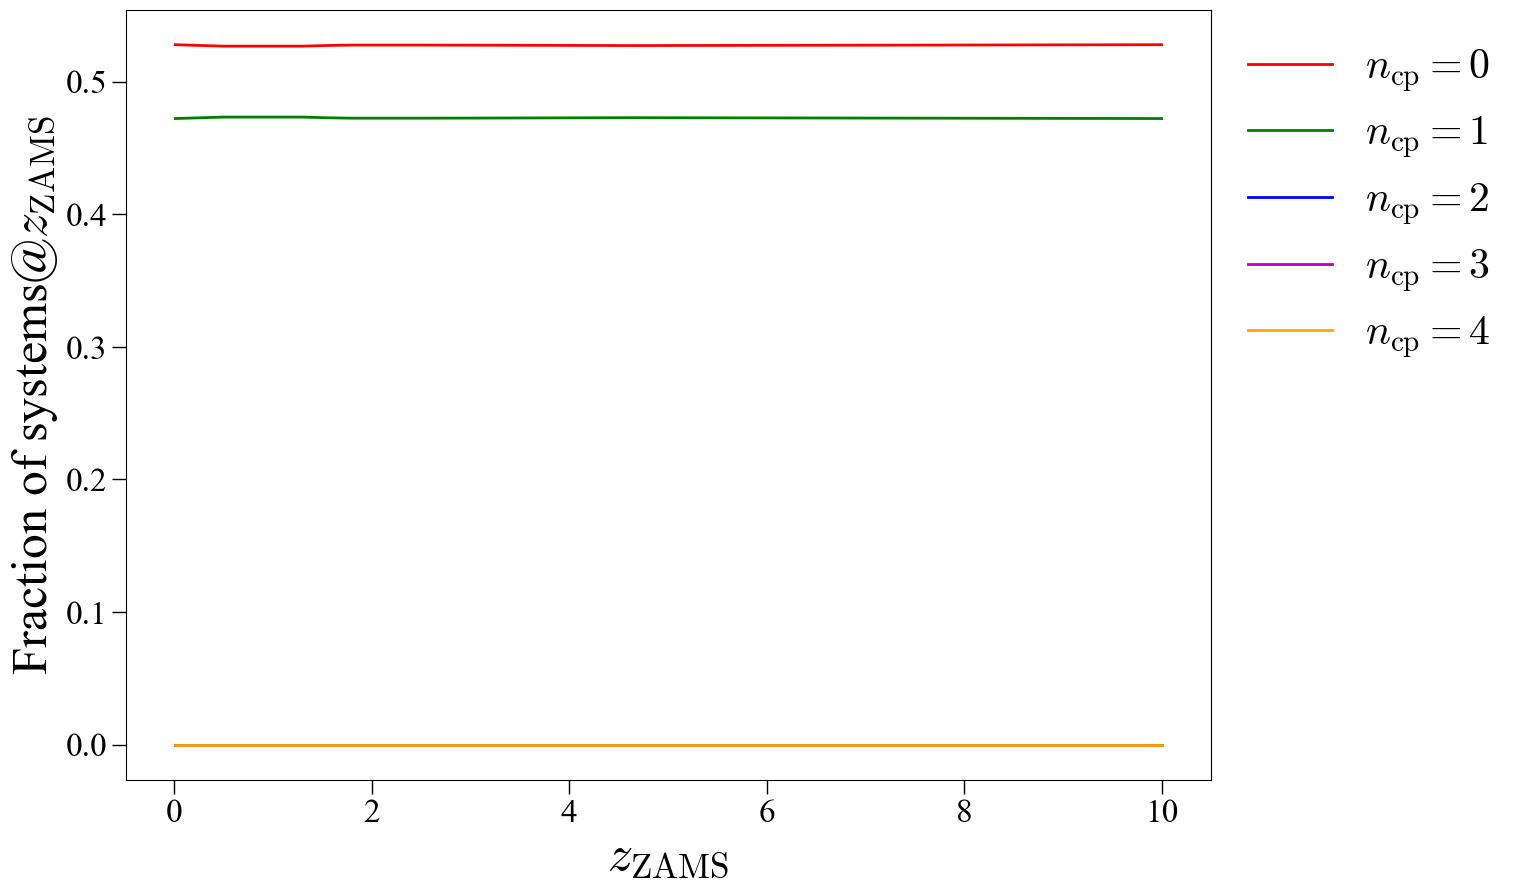

In [146]:
fig, ax = plt.subplots(figsize=(14, 10))
#colors = [(z-plot_redshifts.min())/(plot_redshifts.max()-plot_redshifts.min()) for z in plot_redshifts]
#colors = [cmap(c) for c in colors]
colors = ['r', 'g', 'b', 'm', 'orange']

for ncp, n_frac_arr in enumerate(n_fracs):
    c = colors[ncp]
    ax.plot(sample_redshifts, n_frac_arr, c=c, label=f'$n_\\mathrm{{cp}}={ncp}$')
    
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))
    
ax.set_ylabel('Fraction of systems@$z_\\mathrm{ZAMS}$')
ax.set_xlabel('$z_\\mathrm{ZAMS}$')

<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_697613/698455930.py:8: SyntaxWarning: invalid escape sequence '\m'
  ax.plot(sample_redshifts, m_frac_arr, c=c, label=f'$n_\mathrm{{cp}}={ncp}$')


(0.01000213623046875, 10.0)

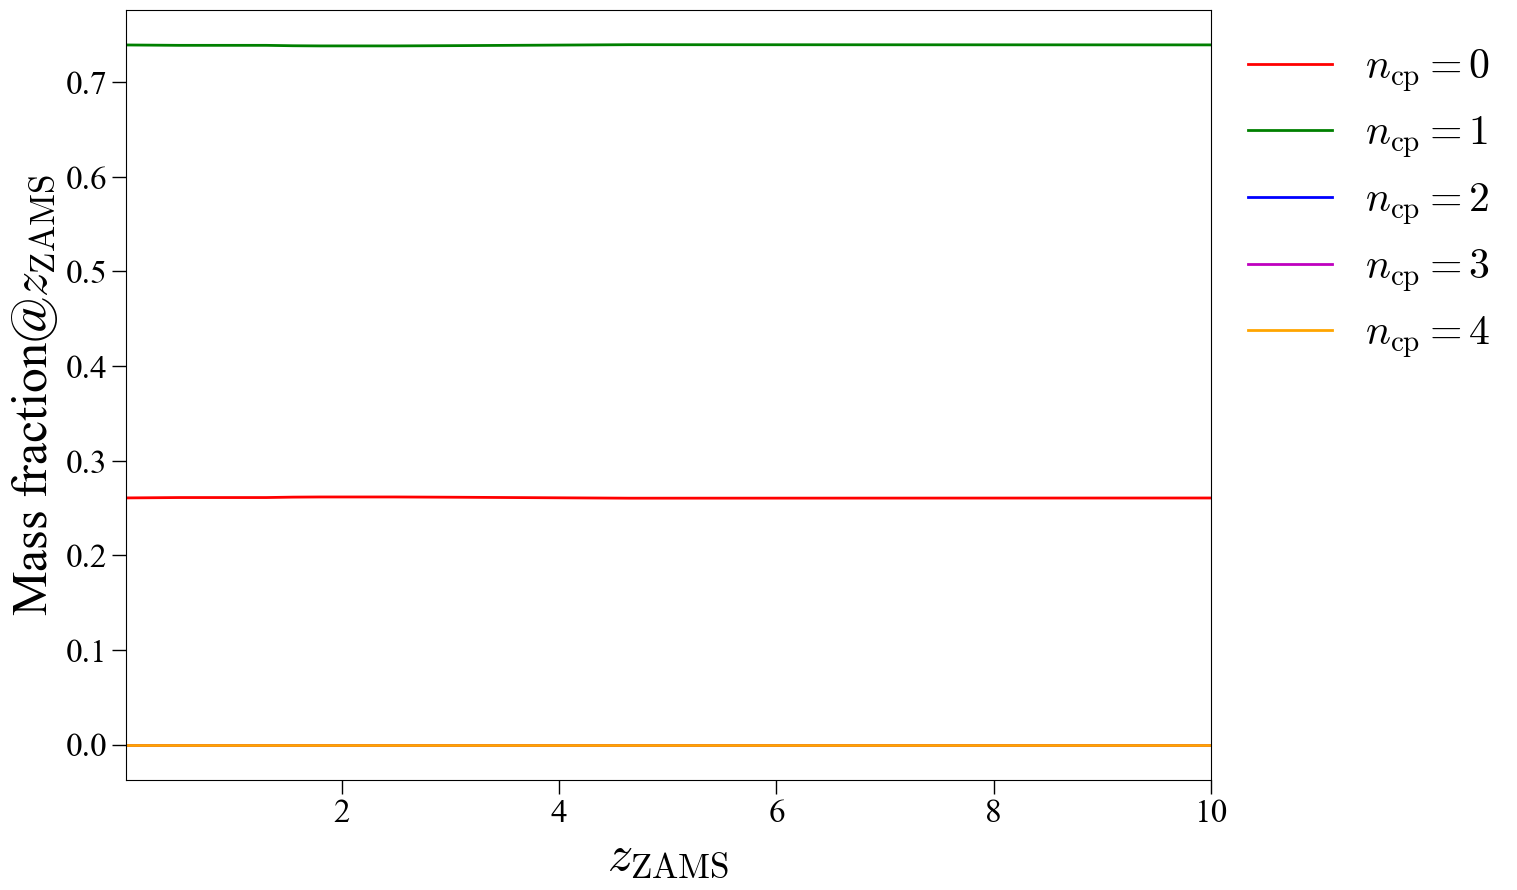

In [147]:
fig, ax = plt.subplots(figsize=(14, 10))
#colors = [(z-plot_redshifts.min())/(plot_redshifts.max()-plot_redshifts.min()) for z in plot_redshifts]
#colors = [cmap(c) for c in colors]
colors = ['r', 'g', 'b', 'm', 'orange']

for ncp, m_frac_arr in enumerate(m_fracs):
    c = colors[ncp]
    ax.plot(sample_redshifts, m_frac_arr, c=c, label=f'$n_\mathrm{{cp}}={ncp}$')
    
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))
    
ax.set_ylabel('Mass fraction@$z_\\mathrm{ZAMS}$')
ax.set_xlabel('$z_\\mathrm{ZAMS}$')
ax.set_xlim(sample_redshifts.min(), sample_redshifts.max())

In [148]:
onlybin_canon_sample_redshifts = sample_redshifts
onlybin_canon_n_fracs = n_fracs
onlybin_canon_m_fracs = m_fracs

## Allmult

In [149]:
sample_df = allmult_df.copy()
#sample_df.dropna(axis=0, how='any', inplace=True)
#sample_df.reset_index(inplace=True, drop=True)

In [150]:
if only_over_5msun:
    sample_df = sample_df[sample_df.m1 >= 5]

In [151]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 145976522 entries, 0 to 1085753
Data columns (total 9 columns):
 #   Column    Dtype  
---  ------    -----  
 0   m1        float16
 1   m2        float16
 2   q         float16
 3   logp      float16
 4   e         float16
 5   ncp       float16
 6   msys      float16
 7   Redshift  float16
 8   [Fe/H]    float16
dtypes: float16(9)
memory usage: 3.5 GB


In [152]:
single_df = sample_df[sample_df.ncp == 0].copy()
binary_df = sample_df[sample_df.ncp == 1].copy()
triple_df = sample_df[sample_df.ncp == 2].copy()
quadruple_df = sample_df[sample_df.ncp == 3].copy()
quintuple_df = sample_df[sample_df.ncp == 4].copy()

In [153]:
single_df.reset_index(inplace=True, drop=True)
binary_df.reset_index(inplace=True, drop=True)
triple_df.reset_index(inplace=True, drop=True)
quadruple_df.reset_index(inplace=True, drop=True)
quintuple_df.reset_index(inplace=True, drop=True)

In [154]:
sample_redshifts = np.sort(sample_df.Redshift.unique())

In [155]:
mult_ev = np.zeros((sample_redshifts.shape[0], 4), np.float32)

In [156]:
for i in range(len(mult_ev)):
    mult_ev[i,1] = i

In [157]:
total_ns = np.zeros(sample_redshifts.shape)
total_ms = np.zeros(sample_redshifts.shape)
for i, redshift in enumerate(sample_redshifts):
    subdf = sample_df[sample_df.Redshift == redshift]
    n = len(subdf)
    m = subdf.msys.to_numpy(dtype='float32').sum()
    total_ns[i] = n
    total_ms[i] = m
    del subdf
gc.collect()

7115

In [158]:
from math import isnan

In [159]:
n_fracs = np.zeros((5, sample_redshifts.shape[0]))
m_fracs = np.zeros((5, sample_redshifts.shape[0]))

#### Singles

In [160]:
df = single_df
ncp = 0

In [161]:
for i, redshift in enumerate(sample_redshifts):
    subdf = df[df.Redshift == redshift]
    n = len(subdf)
    m = subdf.msys.to_numpy(dtype='float32').sum()
    n_frac = n/total_ns[i]
    m_frac = m/total_ms[i]
    n_fracs[ncp, i] = n_frac
    m_fracs[ncp, i] = m_frac
    del subdf
gc.collect()

0

#### Binaries

In [162]:
df = binary_df
ncp = 1

In [163]:
for i, redshift in enumerate(sample_redshifts):
    subdf = df[df.Redshift == redshift]
    n = len(subdf)
    m = subdf.msys.to_numpy(dtype='float32').sum()
    n_frac = n/total_ns[i]
    m_frac = m/total_ms[i]
    n_fracs[ncp, i] = n_frac
    m_fracs[ncp, i] = m_frac
    del subdf
gc.collect()

0

#### Triples

In [164]:
df = triple_df
ncp = 2

In [165]:
for i, redshift in enumerate(sample_redshifts):
    subdf = df[df.Redshift == redshift]
    n = len(subdf)
    m = subdf.msys.to_numpy(dtype='float32').sum()
    n_frac = n/total_ns[i]
    m_frac = m/total_ms[i]
    n_fracs[ncp, i] = n_frac
    m_fracs[ncp, i] = m_frac
    del subdf
gc.collect()

0

#### Quadruples

In [166]:
df = quadruple_df
ncp = 3

In [167]:
for i, redshift in enumerate(sample_redshifts):
    subdf = df[df.Redshift == redshift]
    n = len(subdf)
    m = subdf.msys.to_numpy(dtype='float32').sum()
    n_frac = n/total_ns[i]
    m_frac = m/total_ms[i]
    n_fracs[ncp, i] = n_frac
    m_fracs[ncp, i] = m_frac
    del subdf
gc.collect()

0

#### Quintuples

In [168]:
df = quintuple_df
ncp = 4

In [169]:
for i, redshift in enumerate(sample_redshifts):
    subdf = df[df.Redshift == redshift]
    n = len(subdf)
    m = subdf.msys.to_numpy(dtype='float32').sum()
    n_frac = n/total_ns[i]
    m_frac = m/total_ms[i]
    n_fracs[ncp, i] = n_frac
    m_fracs[ncp, i] = m_frac
    del subdf
gc.collect()

0

In [170]:
binary_df.msys.describe()

/home/lucasmdesa/anaconda3/envs/bossa/lib/python3.12/site-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/home/lucasmdesa/anaconda3/envs/bossa/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/lucasmdesa/anaconda3/envs/bossa/lib/python3.12/site-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
/home/lucasmdesa/anaconda3/envs/bossa/lib/python3.12/site-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/home/lucasmdesa/anaconda3/envs/bossa/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
/home/lucasmdesa/anaconda3/envs/bossa/lib/python3.12/site-packages/pandas/c

count    4.516269e+07
mean              NaN
std               NaN
min      9.160156e-01
25%      1.670898e+00
50%      2.654297e+00
75%      5.191406e+00
max      2.997500e+02
Name: msys, dtype: float64

#### All

In [171]:
label_dict = {0 : 'Singles ($n_\mathrm{cp}=0$)',
             1 : 'Binaries ($n_\mathrm{cp}=1$)',
             2 : 'Triples ($n_\mathrm{cp}=2$)',
             3 : 'Quadruples ($n_\mathrm{cp}=3$)',
             4 : 'Quintuples ($n_\mathrm{cp}=4$)'}

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_697613/21650472.py:1: SyntaxWarning: invalid escape sequence '\m'
  label_dict = {0 : 'Singles ($n_\mathrm{cp}=0$)',
/tmp/ipykernel_697613/21650472.py:2: SyntaxWarning: invalid escape sequence '\m'
  1 : 'Binaries ($n_\mathrm{cp}=1$)',
/tmp/ipykernel_697613/21650472.py:3: SyntaxWarning: invalid escape sequence '\m'
  2 : 'Triples ($n_\mathrm{cp}=2$)',
/tmp/ipykernel_697613/21650472.py:4: SyntaxWarning: invalid escape sequence '\m'
  3 : 'Quadruples ($n_\mathrm{cp}=3$)',
/tmp/ipyke

Text(0.5, 0, '$z_\\mathrm{ZAMS}$')

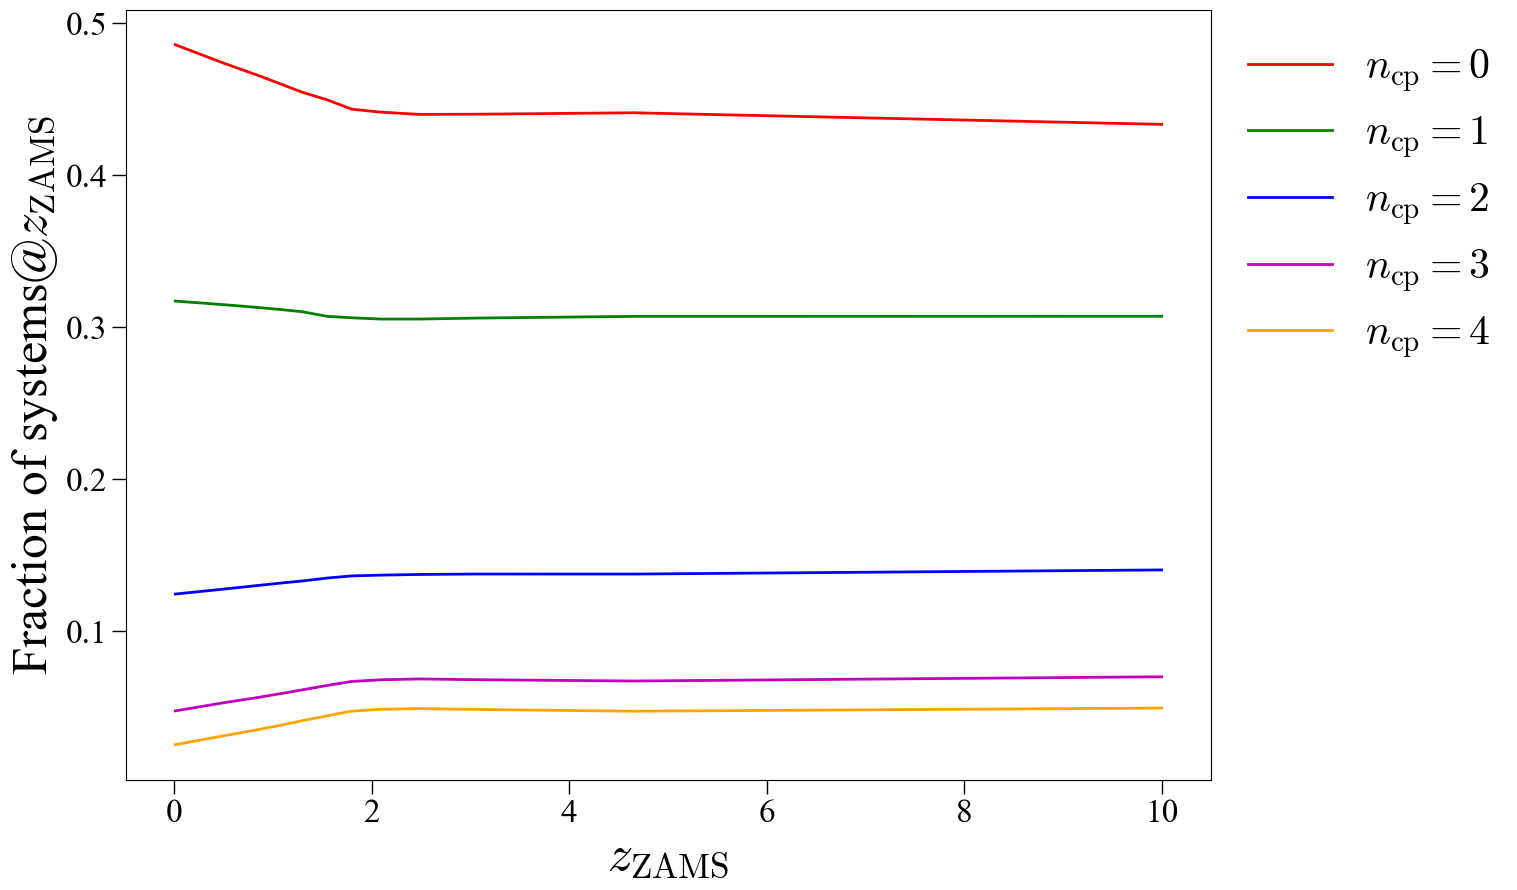

In [172]:
fig, ax = plt.subplots(figsize=(14, 10))
#colors = [(z-plot_redshifts.min())/(plot_redshifts.max()-plot_redshifts.min()) for z in plot_redshifts]
#colors = [cmap(c) for c in colors]
colors = ['r', 'g', 'b', 'm', 'orange']

for ncp, n_frac_arr in enumerate(n_fracs):
    c = colors[ncp]
    ax.plot(sample_redshifts, n_frac_arr, c=c, label=f'$n_\\mathrm{{cp}}={ncp}$')
    
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))
    
ax.set_ylabel('Fraction of systems@$z_\\mathrm{ZAMS}$')
ax.set_xlabel('$z_\\mathrm{ZAMS}$')

<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_697613/698455930.py:8: SyntaxWarning: invalid escape sequence '\m'
  ax.plot(sample_redshifts, m_frac_arr, c=c, label=f'$n_\mathrm{{cp}}={ncp}$')


(0.01000213623046875, 10.0)

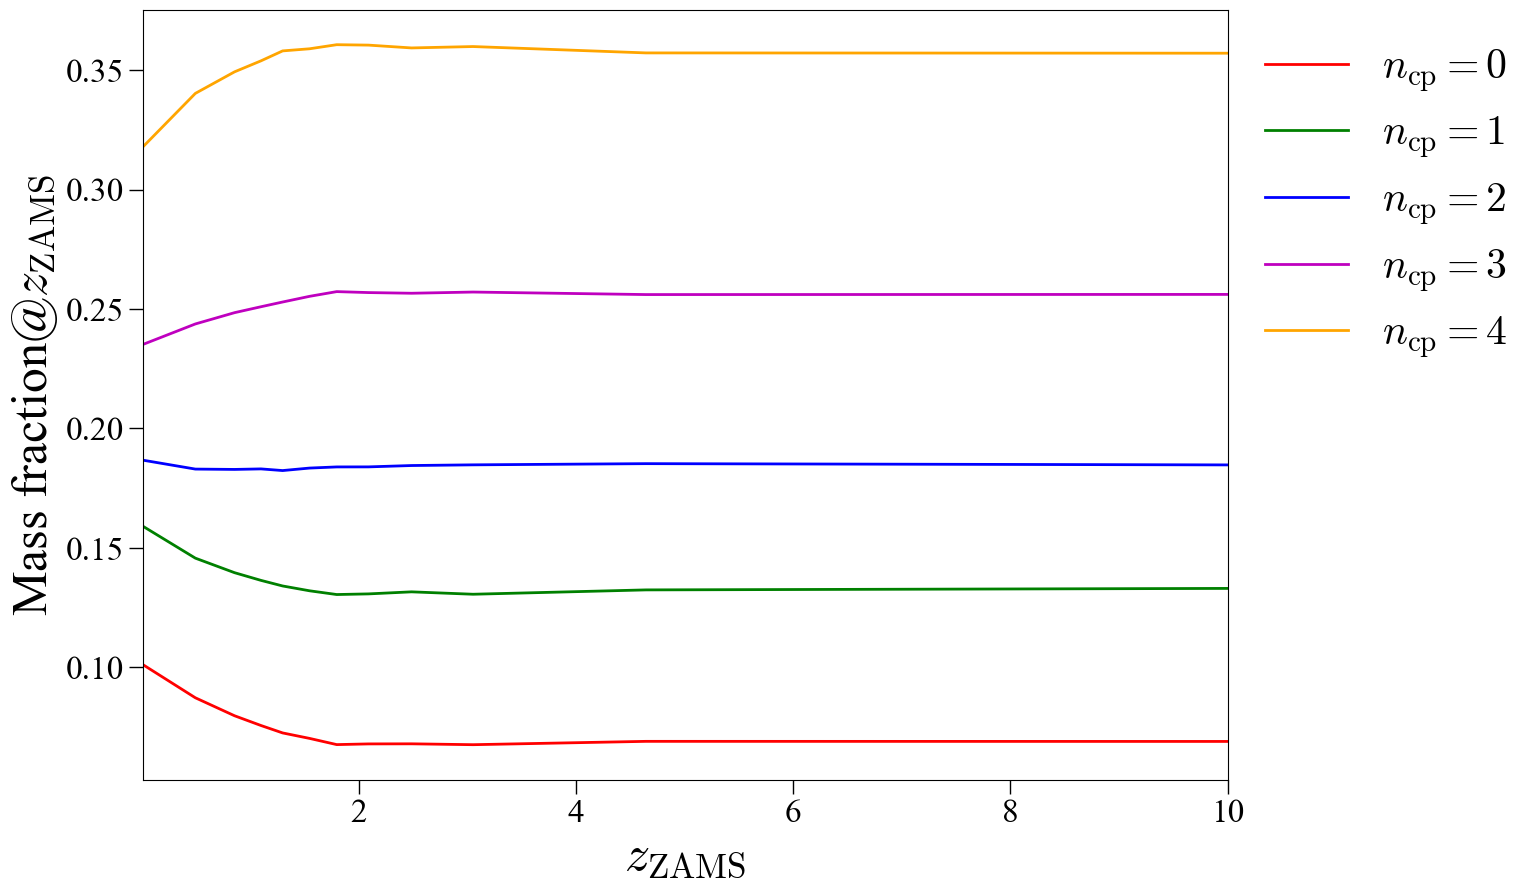

In [173]:
fig, ax = plt.subplots(figsize=(14, 10))
#colors = [(z-plot_redshifts.min())/(plot_redshifts.max()-plot_redshifts.min()) for z in plot_redshifts]
#colors = [cmap(c) for c in colors]
colors = ['r', 'g', 'b', 'm', 'orange']

for ncp, m_frac_arr in enumerate(m_fracs):
    c = colors[ncp]
    ax.plot(sample_redshifts, m_frac_arr, c=c, label=f'$n_\mathrm{{cp}}={ncp}$')
    
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))
    
ax.set_ylabel('Mass fraction@$z_\\mathrm{ZAMS}$')
ax.set_xlabel('$z_\\mathrm{ZAMS}$')
ax.set_xlim(sample_redshifts.min(), sample_redshifts.max())

In [174]:
allmult_sample_redshifts = sample_redshifts
allmult_n_fracs = n_fracs
allmult_m_fracs = m_fracs

## Allmult canon

In [175]:
sample_df = allmult_canon_df.copy()
#sample_df.dropna(axis=0, how='any', inplace=True)
#sample_df.reset_index(inplace=True, drop=True)

In [176]:
if only_over_5msun:
    sample_df = sample_df[sample_df.m1 >= 5]

In [177]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 177357905 entries, 0 to 1477819
Data columns (total 9 columns):
 #   Column    Dtype  
---  ------    -----  
 0   m1        float32
 1   m2        float32
 2   q         float32
 3   logp      float32
 4   e         float32
 5   ncp       float32
 6   msys      float32
 7   Redshift  float64
 8   [Fe/H]    float64
dtypes: float32(7), float64(2)
memory usage: 8.6 GB


In [178]:
single_df = sample_df[sample_df.ncp == 0].copy()
binary_df = sample_df[sample_df.ncp == 1].copy()
triple_df = sample_df[sample_df.ncp == 2].copy()
quadruple_df = sample_df[sample_df.ncp == 3].copy()
quintuple_df = sample_df[sample_df.ncp == 4].copy()

In [179]:
single_df.reset_index(inplace=True, drop=True)
binary_df.reset_index(inplace=True, drop=True)
triple_df.reset_index(inplace=True, drop=True)
quadruple_df.reset_index(inplace=True, drop=True)
quintuple_df.reset_index(inplace=True, drop=True)

In [180]:
sample_redshifts = np.sort(sample_df.Redshift.unique())

In [181]:
mult_ev = np.zeros((sample_redshifts.shape[0], 4), np.float32)

In [182]:
for i in range(len(mult_ev)):
    mult_ev[i,1] = i

In [183]:
total_ns = np.zeros(sample_redshifts.shape)
total_ms = np.zeros(sample_redshifts.shape)
for i, redshift in enumerate(sample_redshifts):
    subdf = sample_df[sample_df.Redshift == redshift]
    n = len(subdf)
    m = subdf.msys.to_numpy(dtype='float32').sum()
    total_ns[i] = n
    total_ms[i] = m
    del subdf
gc.collect()

8001

In [184]:
from math import isnan

In [185]:
n_fracs = np.zeros((5, sample_redshifts.shape[0]))
m_fracs = np.zeros((5, sample_redshifts.shape[0]))

#### Singles

In [186]:
df = single_df
ncp = 0

In [187]:
for i, redshift in enumerate(sample_redshifts):
    subdf = df[df.Redshift == redshift]
    n = len(subdf)
    m = subdf.msys.to_numpy(dtype='float32').sum()
    n_frac = n/total_ns[i]
    m_frac = m/total_ms[i]
    n_fracs[ncp, i] = n_frac
    m_fracs[ncp, i] = m_frac
    del subdf
gc.collect()

0

#### Binaries

In [188]:
df = binary_df
ncp = 1

In [189]:
for i, redshift in enumerate(sample_redshifts):
    subdf = df[df.Redshift == redshift]
    n = len(subdf)
    m = subdf.msys.to_numpy(dtype='float32').sum()
    n_frac = n/total_ns[i]
    m_frac = m/total_ms[i]
    n_fracs[ncp, i] = n_frac
    m_fracs[ncp, i] = m_frac
    del subdf
gc.collect()

0

#### Triples

In [190]:
df = triple_df
ncp = 2

In [191]:
for i, redshift in enumerate(sample_redshifts):
    subdf = df[df.Redshift == redshift]
    n = len(subdf)
    m = subdf.msys.to_numpy(dtype='float32').sum()
    n_frac = n/total_ns[i]
    m_frac = m/total_ms[i]
    n_fracs[ncp, i] = n_frac
    m_fracs[ncp, i] = m_frac
    del subdf
gc.collect()

0

#### Quadruples

In [192]:
df = quadruple_df
ncp = 3

In [193]:
for i, redshift in enumerate(sample_redshifts):
    subdf = df[df.Redshift == redshift]
    n = len(subdf)
    m = subdf.msys.to_numpy(dtype='float32').sum()
    n_frac = n/total_ns[i]
    m_frac = m/total_ms[i]
    n_fracs[ncp, i] = n_frac
    m_fracs[ncp, i] = m_frac
    del subdf
gc.collect()

0

#### Quintuples

In [194]:
df = quintuple_df
ncp = 4

In [195]:
for i, redshift in enumerate(sample_redshifts):
    subdf = df[df.Redshift == redshift]
    n = len(subdf)
    m = subdf.msys.to_numpy(dtype='float32').sum()
    n_frac = n/total_ns[i]
    m_frac = m/total_ms[i]
    n_fracs[ncp, i] = n_frac
    m_fracs[ncp, i] = m_frac
    del subdf
gc.collect()

0

In [196]:
binary_df.msys.describe()

count    5.720084e+07
mean     3.429738e+00
std      5.233029e+00
min      9.167570e-01
25%      1.537813e+00
50%      2.082072e+00
75%      3.407817e+00
max      2.996591e+02
Name: msys, dtype: float64

#### All

In [197]:
label_dict = {0 : 'Singles ($n_\mathrm{cp}=0$)',
             1 : 'Binaries ($n_\mathrm{cp}=1$)',
             2 : 'Triples ($n_\mathrm{cp}=2$)',
             3 : 'Quadruples ($n_\mathrm{cp}=3$)',
             4 : 'Quintuples ($n_\mathrm{cp}=4$)'}

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_697613/21650472.py:1: SyntaxWarning: invalid escape sequence '\m'
  label_dict = {0 : 'Singles ($n_\mathrm{cp}=0$)',
/tmp/ipykernel_697613/21650472.py:2: SyntaxWarning: invalid escape sequence '\m'
  1 : 'Binaries ($n_\mathrm{cp}=1$)',
/tmp/ipykernel_697613/21650472.py:3: SyntaxWarning: invalid escape sequence '\m'
  2 : 'Triples ($n_\mathrm{cp}=2$)',
/tmp/ipykernel_697613/21650472.py:4: SyntaxWarning: invalid escape sequence '\m'
  3 : 'Quadruples ($n_\mathrm{cp}=3$)',
/tmp/ipyke

Text(0.5, 0, '$z_\\mathrm{ZAMS}$')

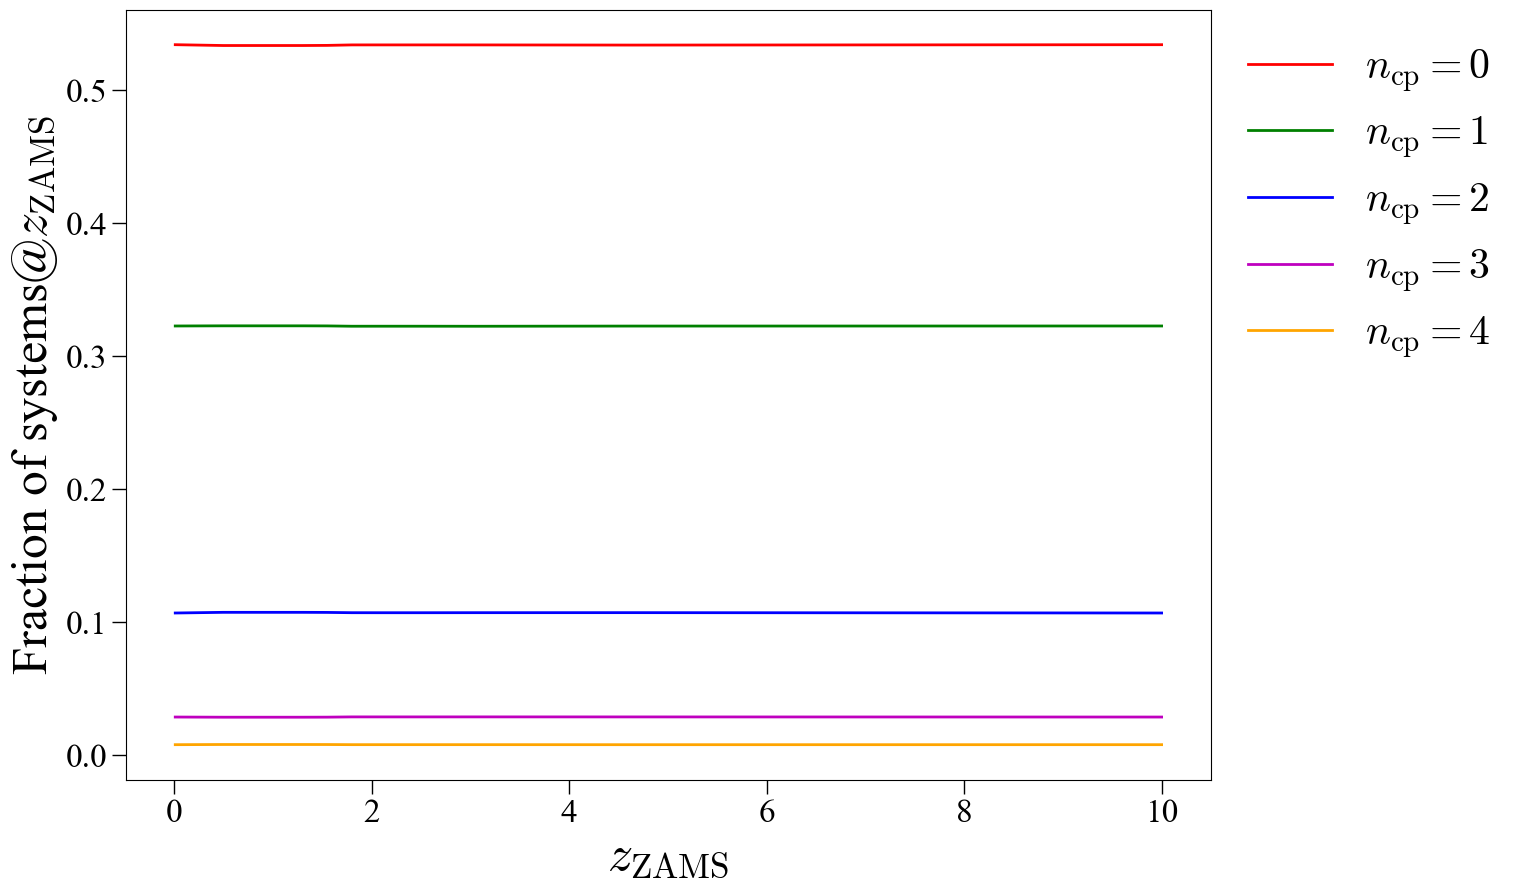

In [198]:
fig, ax = plt.subplots(figsize=(14, 10))
#colors = [(z-plot_redshifts.min())/(plot_redshifts.max()-plot_redshifts.min()) for z in plot_redshifts]
#colors = [cmap(c) for c in colors]
colors = ['r', 'g', 'b', 'm', 'orange']

for ncp, n_frac_arr in enumerate(n_fracs):
    c = colors[ncp]
    ax.plot(sample_redshifts, n_frac_arr, c=c, label=f'$n_\\mathrm{{cp}}={ncp}$')
    
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))
    
ax.set_ylabel('Fraction of systems@$z_\\mathrm{ZAMS}$')
ax.set_xlabel('$z_\\mathrm{ZAMS}$')

<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_697613/698455930.py:8: SyntaxWarning: invalid escape sequence '\m'
  ax.plot(sample_redshifts, m_frac_arr, c=c, label=f'$n_\mathrm{{cp}}={ncp}$')


(0.01, 10.0)

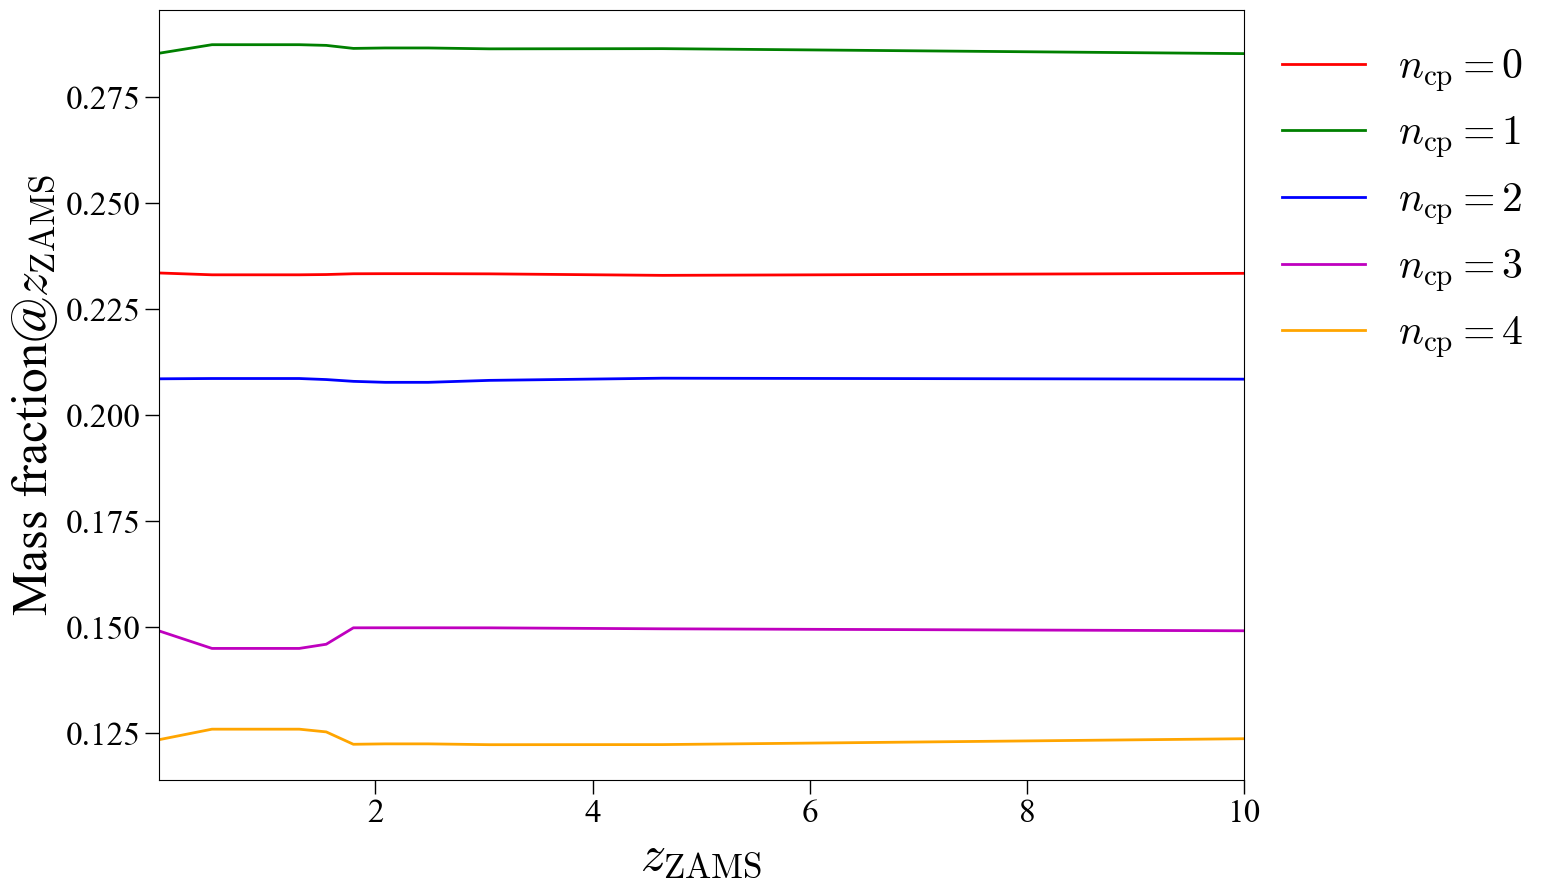

In [199]:
fig, ax = plt.subplots(figsize=(14, 10))
#colors = [(z-plot_redshifts.min())/(plot_redshifts.max()-plot_redshifts.min()) for z in plot_redshifts]
#colors = [cmap(c) for c in colors]
colors = ['r', 'g', 'b', 'm', 'orange']

for ncp, m_frac_arr in enumerate(m_fracs):
    c = colors[ncp]
    ax.plot(sample_redshifts, m_frac_arr, c=c, label=f'$n_\mathrm{{cp}}={ncp}$')
    
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))
    
ax.set_ylabel('Mass fraction@$z_\\mathrm{ZAMS}$')
ax.set_xlabel('$z_\\mathrm{ZAMS}$')
ax.set_xlim(sample_redshifts.min(), sample_redshifts.max())

In [200]:
allmult_canon_sample_redshifts = sample_redshifts
allmult_canon_n_fracs = n_fracs
allmult_canon_m_fracs = m_fracs

## Comparison

Text(0.5, 0, '$z_\\mathrm{ZAMS}$')

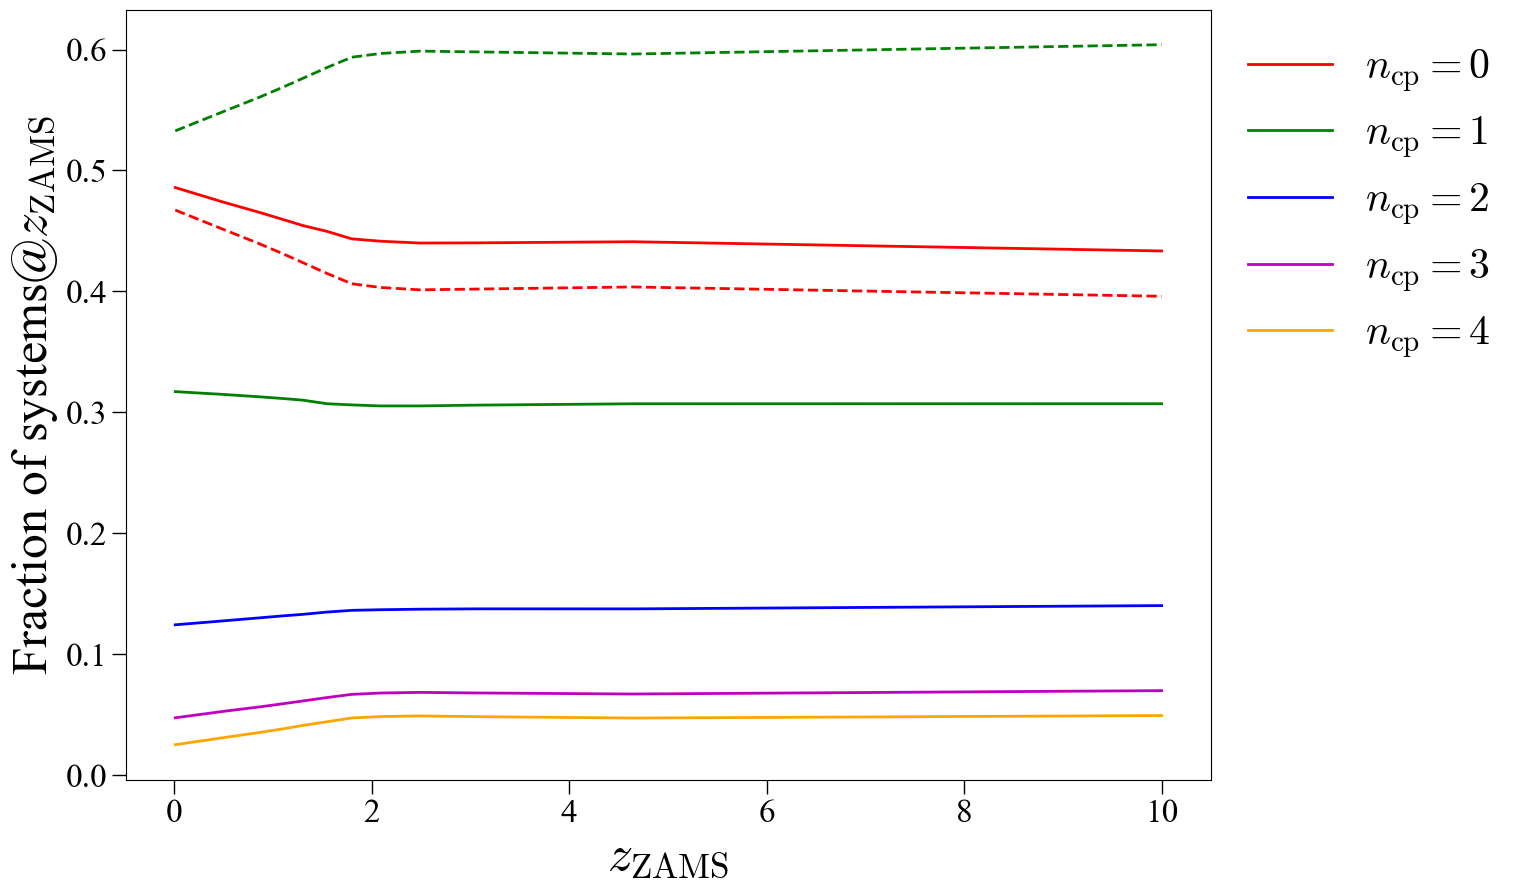

In [201]:
fig, ax = plt.subplots(figsize=(14, 10))
#colors = [(z-plot_redshifts.min())/(plot_redshifts.max()-plot_redshifts.min()) for z in plot_redshifts]
#colors = [cmap(c) for c in colors]
colors = ['r', 'g', 'b', 'm', 'orange']

for ncp, n_frac_arr in enumerate(onlybin_n_fracs[:2]):
    c = colors[ncp]
    ax.plot(onlybin_sample_redshifts, n_frac_arr, c=c, ls='--')

for ncp, n_frac_arr in enumerate(allmult_n_fracs):
    c = colors[ncp]
    ax.plot(allmult_sample_redshifts, n_frac_arr, c=c, label=f'$n_\\mathrm{{cp}}={ncp}$')
    
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))
    
ax.set_ylabel('Fraction of systems@$z_\\mathrm{ZAMS}$')
ax.set_xlabel('$z_\\mathrm{ZAMS}$')

<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_697613/1118484950.py:12: SyntaxWarning: invalid escape sequence '\m'
  ax.plot(allmult_sample_redshifts, m_frac_arr, c=c, label=f'$n_\mathrm{{cp}}={ncp}$')


(0.01, 10.0)

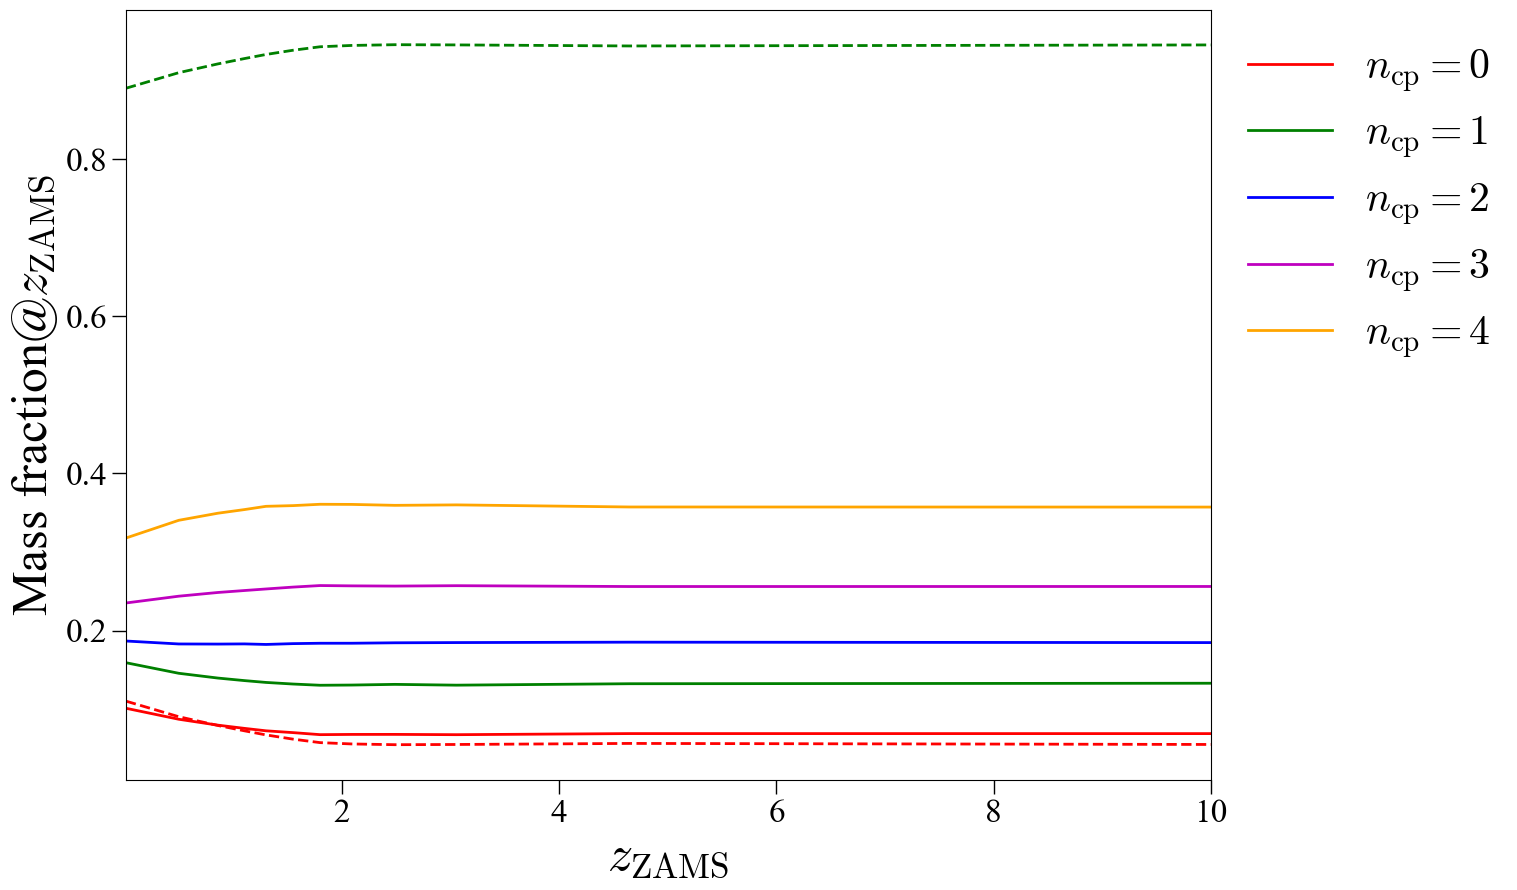

In [202]:
fig, ax = plt.subplots(figsize=(14, 10))
#colors = [(z-plot_redshifts.min())/(plot_redshifts.max()-plot_redshifts.min()) for z in plot_redshifts]
#colors = [cmap(c) for c in colors]
colors = ['r', 'g', 'b', 'm', 'orange']

for ncp, m_frac_arr in enumerate(onlybin_m_fracs[:2]):
    c = colors[ncp]
    ax.plot(onlybin_sample_redshifts, m_frac_arr, c=c, ls='--')

for ncp, m_frac_arr in enumerate(allmult_m_fracs):
    c = colors[ncp]
    ax.plot(allmult_sample_redshifts, m_frac_arr, c=c, label=f'$n_\mathrm{{cp}}={ncp}$')
    
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))

ax.set_ylabel('Mass fraction@$z_\\mathrm{ZAMS}$')
ax.set_xlabel('$z_\\mathrm{ZAMS}$')
ax.set_xlim(sample_redshifts.min(), sample_redshifts.max())

<>:26: SyntaxWarning: invalid escape sequence '\m'
<>:26: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_697613/3449211492.py:26: SyntaxWarning: invalid escape sequence '\m'
  axes[1].plot(allmult_sample_redshifts, m_frac_arr, c=c, label=f'$n_\mathrm{{cp}}={ncp}$')


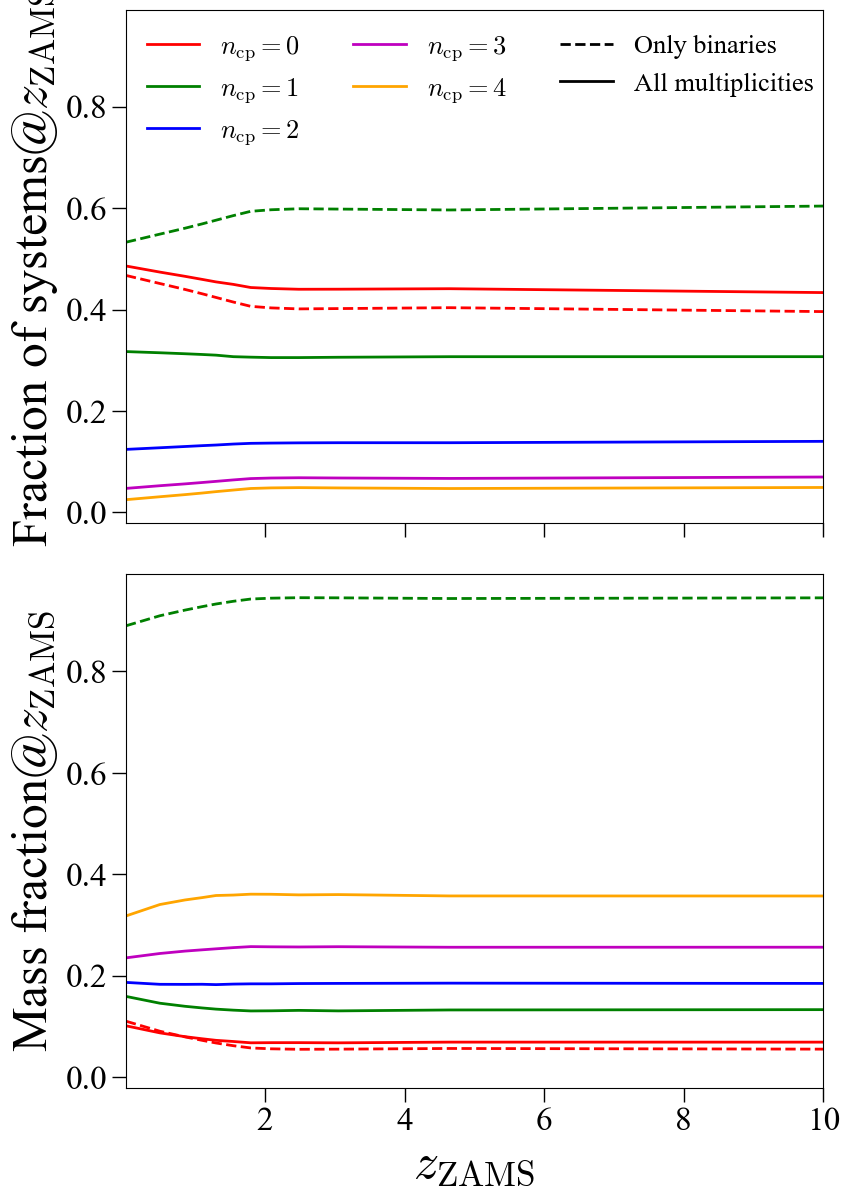

In [203]:
fig, axes = plt.subplots(2, 1, figsize=(9, 14), sharex=True, sharey=True)
axes = axes
fig.subplots_adjust(hspace=0.1, wspace=0)
rect = fig.patch
rect.set_facecolor('white')
#colors = [(z-plot_redshifts.min())/(plot_redshifts.max()-plot_redshifts.min()) for z in plot_redshifts]
#colors = [cmap(c) for c in colors]
colors = ['r', 'g', 'b', 'm', 'orange']

for ncp, n_frac_arr in enumerate(onlybin_n_fracs[:2]):
    c = colors[ncp]
    axes[0].plot(onlybin_sample_redshifts, n_frac_arr, c=c, ls='--')

for ncp, n_frac_arr in enumerate(allmult_n_fracs):
    c = colors[ncp]
    axes[0].plot(allmult_sample_redshifts, n_frac_arr, c=c, label=f'$n_\\mathrm{{cp}}={ncp}$')
    
axes[0].set_ylabel('Fraction of systems@$z_\\mathrm{ZAMS}$')

for ncp, m_frac_arr in enumerate(onlybin_m_fracs[:2]):
    c = colors[ncp]
    axes[1].plot(onlybin_sample_redshifts, m_frac_arr, c=c, ls='--')

for ncp, m_frac_arr in enumerate(allmult_m_fracs):
    c = colors[ncp]
    axes[1].plot(allmult_sample_redshifts, m_frac_arr, c=c, label=f'$n_\mathrm{{cp}}={ncp}$')
    
axes[1].set_ylabel('Mass fraction@$z_\\mathrm{ZAMS}$')
axes[1].set_xlabel('$z_\\mathrm{ZAMS}$')
axes[1].set_xlim(sample_redshifts.min(), sample_redshifts.max())

handles, labels = axes[1].get_legend_handles_labels()
onlybin_handle = Line2D([-1], [-1], c='k', ls='--', label='Only binaries')
allmult_handle = Line2D([-1], [-1], c='k', ls='-', label='All multiplicities')
handles += [onlybin_handle, allmult_handle]

axes[0].legend(handles=handles, frameon=False, loc='upper right', bbox_to_anchor=(1.02,1), ncol=3, fontsize=19)
#axes[1].legend(handles=handles, frameon=True, loc='lower left', bbox_to_anchor=(0,1.05), ncol=3, edgecolor='black', fancybox=False, borderpad=0.2, fontsize=19)

fig.savefig(FIGURE_FOLDER/'number_mass_fraction_redshift.png', bbox_inches='tight')
fig.savefig(FIGURE_FOLDER/'number_mass_fraction_redshift.pdf', bbox_inches='tight')

Figure 14

<>:26: SyntaxWarning: invalid escape sequence '\m'
<>:26: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_697613/4051997765.py:26: SyntaxWarning: invalid escape sequence '\m'
  axes[1].plot(allmult_sample_redshifts, m_frac_arr, c=c, label=f'$n_\mathrm{{cp}}={ncp}$')


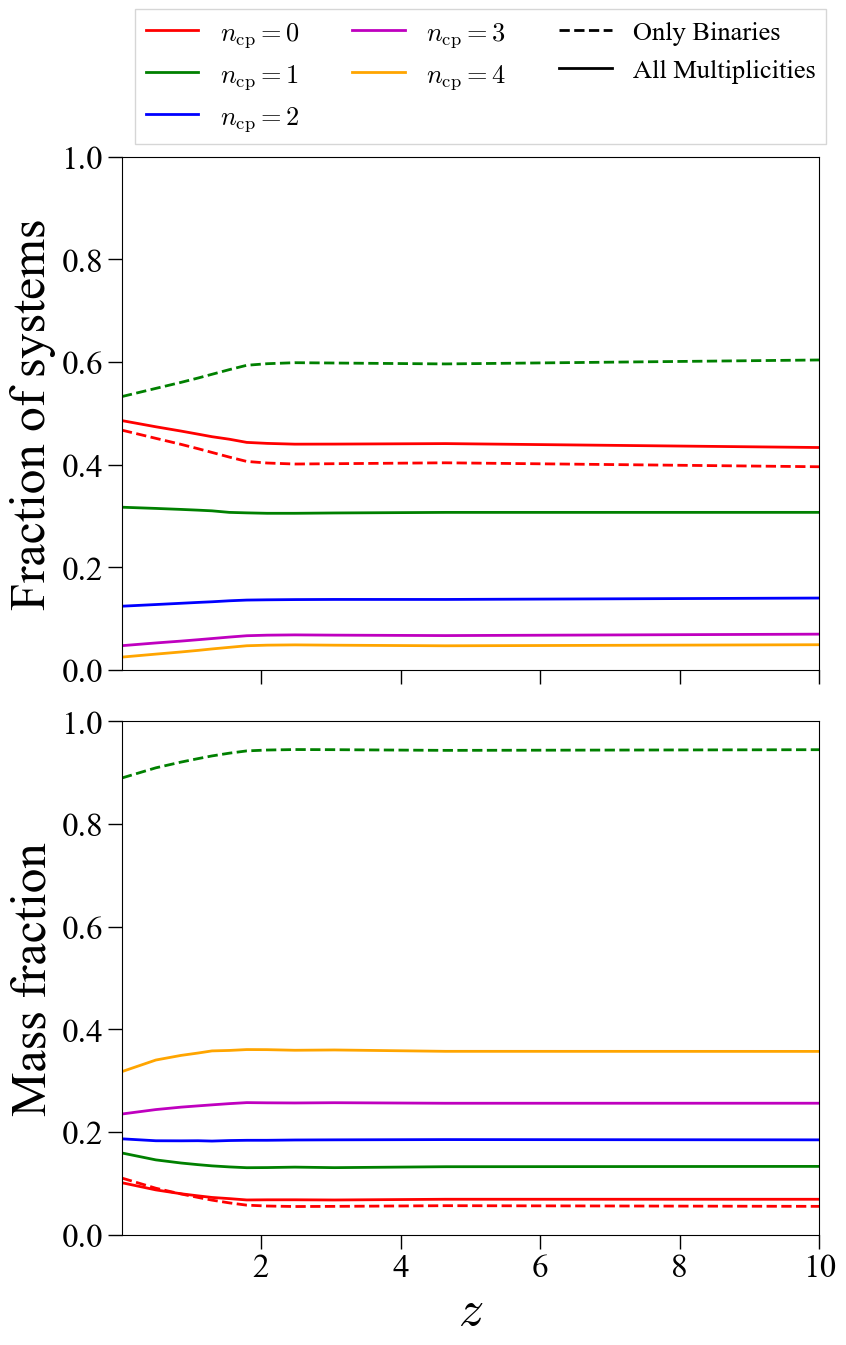

In [217]:
fig, axes = plt.subplots(2, 1, figsize=(9, 14), sharex=True, sharey=True)
axes = axes
fig.subplots_adjust(hspace=0.1, wspace=0)
rect = fig.patch
rect.set_facecolor('white')
#colors = [(z-plot_redshifts.min())/(plot_redshifts.max()-plot_redshifts.min()) for z in plot_redshifts]
#colors = [cmap(c) for c in colors]
colors = ['r', 'g', 'b', 'm', 'orange']

for ncp, n_frac_arr in enumerate(onlybin_n_fracs[:2]):
    c = colors[ncp]
    axes[0].plot(onlybin_sample_redshifts, n_frac_arr, c=c, ls='--')

for ncp, n_frac_arr in enumerate(allmult_n_fracs):
    c = colors[ncp]
    axes[0].plot(allmult_sample_redshifts, n_frac_arr, c=c, label=f'$n_\\mathrm{{cp}}={ncp}$')
    
axes[0].set_ylabel('Fraction of systems')

for ncp, m_frac_arr in enumerate(onlybin_m_fracs[:2]):
    c = colors[ncp]
    axes[1].plot(onlybin_sample_redshifts, m_frac_arr, c=c, ls='--')

for ncp, m_frac_arr in enumerate(allmult_m_fracs):
    c = colors[ncp]
    axes[1].plot(allmult_sample_redshifts, m_frac_arr, c=c, label=f'$n_\mathrm{{cp}}={ncp}$')
    
axes[1].set_ylabel('Mass fraction')
axes[1].set_xlabel('$z$')
axes[1].set_xlim(sample_redshifts.min(), sample_redshifts.max())
axes[1].set_ylim(0,1)

handles, labels = axes[1].get_legend_handles_labels()
onlybin_handle = Line2D([-1], [-1], c='k', ls='--', label='Only Binaries')
allmult_handle = Line2D([-1], [-1], c='k', ls='-', label='All Multiplicities')
handles += [onlybin_handle, allmult_handle]

axes[0].legend(handles=handles, frameon=True, fancybox=False, loc='lower left', bbox_to_anchor=(0, 1), ncol=3, fontsize=19)
#axes[1].legend(handles=handles, frameon=True, loc='lower left', bbox_to_anchor=(0,1.05), ncol=3, edgecolor='black', fancybox=False, borderpad=0.2, fontsize=19)

fig.savefig(FIGURE_FOLDER/'number_mass_fraction_redshift_massive.png', bbox_inches='tight')
fig.savefig(FIGURE_FOLDER/'number_mass_fraction_redshift_massive.pdf', bbox_inches='tight')

Number fraction mean for onlybin is 0=0.4200487064123679

Number fraction mean for onlybin is 1=0.5799512935876322

Number fraction mean for allmult is 0=0.4523780323050015

Number fraction mean for allmult is 1=0.3092128614935417

Number fraction mean for allmult is 2=0.13392044307563256

Number fraction mean for allmult is 3=0.06243961672494657

Number fraction mean for allmult is 4=0.042049046400877726

Mass fraction mean for onlybin is 0=0.06809530992526458

Mass fraction mean for onlybin is 1=0.9319045745859565

Mass fraction mean for allmult is 0=0.0746705560287794

Mass fraction mean for allmult is 1=0.1363342495166662

Mass fraction mean for allmult is 2=0.1840517343887502

Mass fraction mean for allmult is 3=0.25221735893228

Mass fraction mean for allmult is 4=0.3527261098269005

Number fraction mean for canon onlybin is 0=0.5272755461809399

Number fraction mean for canon onlybin is 1=0.4727244538190602

Number fraction mean for canon allmult is 0=0.5335570699988794

Number 

<>:29: SyntaxWarning: invalid escape sequence '\m'
<>:51: SyntaxWarning: invalid escape sequence '\m'
<>:29: SyntaxWarning: invalid escape sequence '\m'
<>:51: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_697613/152028865.py:29: SyntaxWarning: invalid escape sequence '\m'
  axes[1,0].plot(allmult_sample_redshifts, m_frac_arr, c=c, label=f'$n_\mathrm{{cp}}={ncp}$')
/tmp/ipykernel_697613/152028865.py:51: SyntaxWarning: invalid escape sequence '\m'
  axes[1,1].plot(allmult_canon_sample_redshifts, m_frac_arr, c=c, label=f'$n_\mathrm{{cp}}={ncp}$')


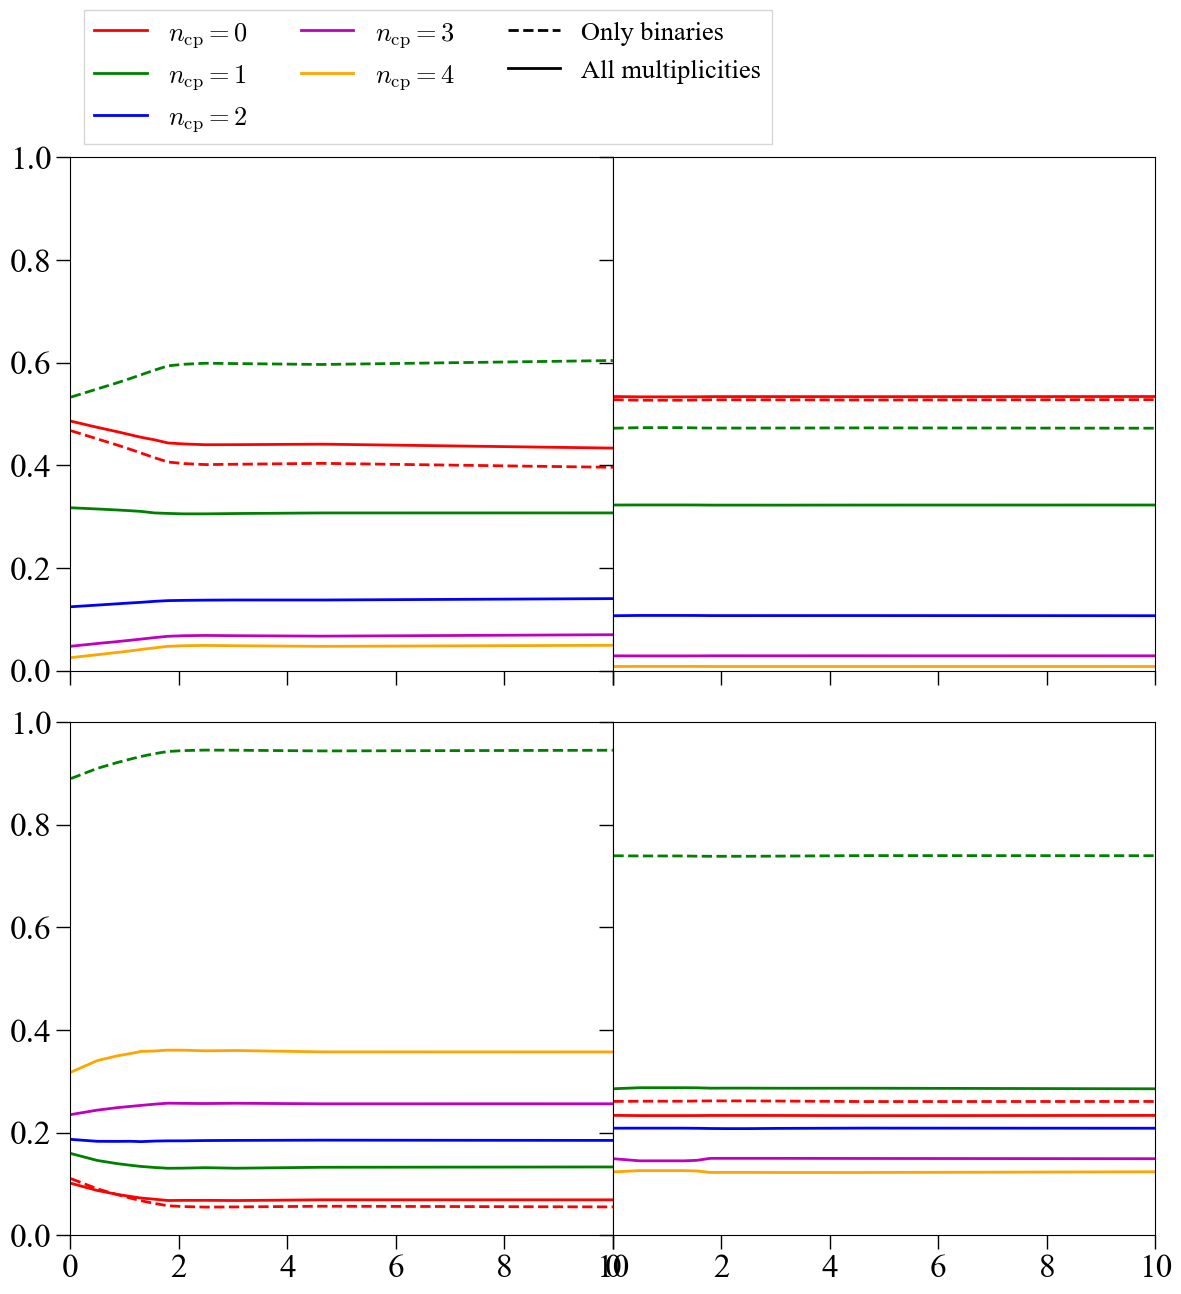

In [205]:
fig, axes = plt.subplots(2, 2, figsize=(14, 14), sharex=True, sharey=True)
axes = axes
fig.subplots_adjust(hspace=0.1, wspace=0)
rect = fig.patch
rect.set_facecolor('white')
#colors = [(z-plot_redshifts.min())/(plot_redshifts.max()-plot_redshifts.min()) for z in plot_redshifts]
#colors = [cmap(c) for c in colors]
colors = ['r', 'g', 'b', 'm', 'orange']

for ncp, n_frac_arr in enumerate(onlybin_n_fracs[:2]):
    c = colors[ncp]
    axes[0,0].plot(onlybin_sample_redshifts, n_frac_arr, c=c, ls='--')
    print(f'Number fraction mean for onlybin is {ncp}={n_frac_arr.mean()}\n')

for ncp, n_frac_arr in enumerate(allmult_n_fracs):
    c = colors[ncp]
    axes[0,0].plot(allmult_sample_redshifts, n_frac_arr, c=c, label=f'$n_\\mathrm{{cp}}={ncp}$')
    print(f'Number fraction mean for allmult is {ncp}={n_frac_arr.mean()}\n')
    
#axes[0].set_ylabel('Fraction of systems@$z_\\mathrm{ZAMS}$')

for ncp, m_frac_arr in enumerate(onlybin_m_fracs[:2]):
    c = colors[ncp]
    axes[1,0].plot(onlybin_sample_redshifts, m_frac_arr, c=c, ls='--')
    print(f'Mass fraction mean for onlybin is {ncp}={m_frac_arr.mean()}\n')

for ncp, m_frac_arr in enumerate(allmult_m_fracs):
    c = colors[ncp]
    axes[1,0].plot(allmult_sample_redshifts, m_frac_arr, c=c, label=f'$n_\mathrm{{cp}}={ncp}$')
    print(f'Mass fraction mean for allmult is {ncp}={m_frac_arr.mean()}\n')
    
for ncp, n_frac_arr in enumerate(onlybin_canon_n_fracs[:2]):
    c = colors[ncp]
    axes[0,1].plot(onlybin_canon_sample_redshifts, n_frac_arr, c=c, ls='--')
    print(f'Number fraction mean for canon onlybin is {ncp}={n_frac_arr.mean()}\n')

for ncp, n_frac_arr in enumerate(allmult_canon_n_fracs):
    c = colors[ncp]
    axes[0,1].plot(allmult_canon_sample_redshifts, n_frac_arr, c=c, label=f'$n_\\mathrm{{cp}}={ncp}$')
    print(f'Number fraction mean for canon allmult is {ncp}={n_frac_arr.mean()}\n')
    
#axes[0].set_ylabel('Fraction of systems@$z_\\mathrm{ZAMS}$')

for ncp, m_frac_arr in enumerate(onlybin_canon_m_fracs[:2]):
    c = colors[ncp]
    axes[1,1].plot(onlybin_canon_sample_redshifts, m_frac_arr, c=c, ls='--')
    print(f'Mass fraction mean for canon onlybin is {ncp}={m_frac_arr.mean()}\n')

for ncp, m_frac_arr in enumerate(allmult_canon_m_fracs):
    c = colors[ncp]
    axes[1,1].plot(allmult_canon_sample_redshifts, m_frac_arr, c=c, label=f'$n_\mathrm{{cp}}={ncp}$')
    print(f'Mass fraction mean for canon allmult is {ncp}={m_frac_arr.mean()}\n')
    
#axes[1].set_ylabel('Mass fraction@$z_\\mathrm{ZAMS}$')
#axes[1].set_xlabel('$z_\\mathrm{ZAMS}$')
axes[0,0].set_xlim(0, 10)
axes[0,0].set_ylim(0,1)

handles, labels = axes[0,0].get_legend_handles_labels()
onlybin_handle = Line2D([-1], [-1], c='k', ls='--', label='Only binaries')
allmult_handle = Line2D([-1], [-1], c='k', ls='-', label='All multiplicities')
handles += [onlybin_handle, allmult_handle]

axes[0,0].legend(handles=handles, frameon=True, fancybox=False, loc='lower left', bbox_to_anchor=(0, 1), ncol=3, fontsize=19)
#axes[1].legend(handles=handles, frameon=True, loc='lower left', bbox_to_anchor=(0,1.05), ncol=3, edgecolor='black', fancybox=False, borderpad=0.2, fontsize=19)

#fig.savefig(FIGURE_FOLDER/'number_mass_fraction_redshift_massive.png', bbox_inches='tight')
#fig.savefig(FIGURE_FOLDER/'number_mass_fraction_redshift_massive.pdf', bbox_inches='tight')

## Correlations

In [206]:
allmult_corr_df = allmult_df.copy()

In [207]:
allmult_corr_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 145976522 entries, 0 to 1085753
Data columns (total 9 columns):
 #   Column    Dtype  
---  ------    -----  
 0   m1        float16
 1   m2        float16
 2   q         float16
 3   logp      float16
 4   e         float16
 5   ncp       float16
 6   msys      float16
 7   Redshift  float16
 8   [Fe/H]    float16
dtypes: float16(9)
memory usage: 3.5 GB


In [208]:
rename_dict = {'m1': r'$m_1$',
              'm2': r'$m_2$',
              'q': r'$q$',
              'logp': r'$\log P$',
              'e': r'$e$',
              'ncp': r'$n_\mathrm{cp}$',
              'msys': 'm_\mathrm{sys}'}

<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_697613/238717275.py:7: SyntaxWarning: invalid escape sequence '\m'
  'msys': 'm_\mathrm{sys}'}


In [209]:
allmult_corr_df.rename(columns=rename_dict, inplace=True)

In [210]:
allmult_corr_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 145976522 entries, 0 to 1085753
Data columns (total 9 columns):
 #   Column           Dtype  
---  ------           -----  
 0   $m_1$            float16
 1   $m_2$            float16
 2   $q$              float16
 3   $\log P$         float16
 4   $e$              float16
 5   $n_\mathrm{cp}$  float16
 6   m_\mathrm{sys}   float16
 7   Redshift         float16
 8   [Fe/H]           float16
dtypes: float16(9)
memory usage: 3.5 GB


In [211]:
allmult_corr_df[r'$\log m_1$'] = np.log10(allmult_corr_df[r'$m_1$'])
allmult_corr_df[r'$\log m_2$'] = np.log10(allmult_corr_df[r'$m_2$'])

/home/lucasmdesa/anaconda3/envs/bossa/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [212]:
onlybin_corr_df = onlybin_df.copy()

KeyboardInterrupt: 

In [ ]:
onlybin_corr_df.info()

In [ ]:
onlybin_corr_df.rename(columns=rename_dict, inplace=True)

In [ ]:
onlybin_corr_df.info()

In [ ]:
onlybin_corr_df[r'$\log m_1$'] = np.log10(onlybin_corr_df[r'$m_1$'])
onlybin_corr_df[r'$\log m_2$'] = np.log10(onlybin_corr_df[r'$m_2$'])

In [ ]:
allmult_inner_df = allmult_corr_df[allmult_corr_df[r'$n_\mathrm{cp}$'] != 0]
allmult_inner_df.info(memory_usage='deep')
del allmult_corr_df
gc.collect()

allmult_bin_df = allmult_inner_df[allmult_inner_df[r'$n_\mathrm{cp}$'] == 1]
allmult_bin_df.info(memory_usage='deep')

onlybin_corr_df = onlybin_corr_df[onlybin_corr_df[r'$n_\mathrm{cp}$'] == 1]